In [17]:
# SETUP --------------------------
from analysis.toolbox import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from transformers import AutoTokenizer, GPT2LMHeadModel, PhrasalConstraint, QuantoConfig
from undecorated import undecorated
from types import MethodType

import time
import pickle
import io
import os
from tqdm import tqdm

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device = "cpu"
torch.set_default_device(device)
print(f"Using {device} device")
print(torch.tensor([1, 2, 3]).device)

# MAGICKS --------------------------
s_model = "gpt2"
iSeed = 4523522
sPadding = "left"
sNameAEModel = "autoencoder_hair20_eos"

lTargetStrings = [
    "Experience 50% more visible shine after just one use.",
]

i_num_beams = 1
i_no_repeat_ngram_size = 1
i_num_return = 1
iClaims = len(lTargetStrings)
print(f"Number of claims: {iClaims}")
iEncodingDim = 2  # Desired number of outtput dimensions
iOutputSize = 768  # Number of output features
iVocab = 50257
iBurnIn = 500
ae = Autoencoder(iClaims, iEncodingDim, iOutputSize)
ae_burnin = Autoencoder(iClaims, iEncodingDim, iOutputSize)
dLearningRatePrefit = 1e1
dLearningRate = 1
dLearningRate = 5
dLearningRate = 5e-1
optimizer = optim.Adam(ae.parameters(), lr=dLearningRate)
iEpoch = 0
iEpochBurnin = 0
dEps = 1
bStop = False

torch.manual_seed(iSeed)

quantization_config = QuantoConfig(weights="int8")
# TODO: Try out flash-attention
#model = GPT2LMHeadModel.from_pretrained(s_model, device_map=device, resume_download=True, quantization_config=quantization_config)
model = GPT2LMHeadModel.from_pretrained(s_model, device_map=device, resume_download=True)
# TODO: Link to this https://github.com/huggingface/transformers/issues/15552 (last comment)
generate_with_grad = model.generate.__closure__[1].cell_contents
model.generate_with_grad = MethodType(generate_with_grad, model)

tokenizer = AutoTokenizer.from_pretrained(s_model, resume_download=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = sPadding
print("EOS TOKEN ID", tokenizer.eos_token_id)

tOHETarget = create_input_data(iClaims)

lConstraints = [PhrasalConstraint(tokenizer(sentence, add_special_tokens=False).input_ids) for sentence in lTargetStrings]
lForceWords = [tokenizer(sentence, add_special_tokens=False).input_ids for sentence in lTargetStrings]

tTargetStrings, lLengths = TokenizeClaims(lTargetStrings, tokenizer)

iMaxTokens = max(lLengths) + 1 # add one for eos, see TokenizeClaims() fct.
iMinTokens = min(lLengths)
print(f"Lengths of target strings {lLengths}")
print(f"Max number of tokens {iMaxTokens}")

# NOTE: https://github.com/huggingface/transformers/blob/main/src/transformers/generation/logits_process.py

# TODO: Remove min_new_tokens again?
fn_generate_i = lambda x, i: model.generate_with_grad(
        inputs_embeds=x,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        max_new_tokens=i,
        #min_new_tokens=int(i),
        constraints = lConstraints,
        num_beams=10,
        num_return_sequences=i_num_return,
        return_dict_in_generate=True,
        output_scores=True)

fn_generate_max_constr = lambda x: model.generate_with_grad(
    inputs_embeds=x,
    do_sample=False,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
    max_new_tokens=iMaxTokens,
    constraints = lConstraints,
    force_words_ids = lForceWords,
    num_beams=10,
    num_return_sequences=i_num_return,
    return_dict_in_generate=True,
    output_scores=True)

fn_generate_max = lambda x: fn_generate_i(x, iMaxTokens)

# # 3 Training together
iEpoch = 0
dLearningRate = 5e0
#ae.load_state_dict(ae_burnin.state_dict())
optimizer = torch.optim.Adam(ae.parameters(),
                             lr = dLearningRate)
optimizer = torch.optim.SGD(ae.parameters(), lr = dLearningRate)

dEps = 1
bStop = False
aLLHistory = np.ones((1, iClaims))
lGradWeightsDecoder = []
lGradBiasDecoder = []
lGradWeightsEncoder = []
lGradBiasEncoder = []
lStepsWeightsDecoder = []
lStepsBiasDecoder = []
lStepsWeightsEncoder = []
lStepsBiasEncoder = []
lStepsWeightsDecoder = []
lStepsBiasDecoder = []
lStepsWeightsEncoder = []
lStepsBiasEncoder = []
aLLHistory[0, :] = np.nan
aLLHistory = np.ones((1, iClaims))
aLLHistory[0, :] = np.nan
lLoss = []

Using cpu device
cpu
Number of claims: 1
EOS TOKEN ID 50256
Lengths of target strings tensor([11])
Max number of tokens 12


Claim 0:  receiversExperience 50% more visible shine after just one use.
time: 3.99 s
Claim 0: ContractExperience 50% more visible shine after just one use.
time: 31.46 s
Claim 0: VALUEExperience 50% more visible shine after just one use.
time: 32.2 s
Claim 0: Experience 50% more visible shine after just one use.<|endoftext|>
time: 28.71 s
Claim 0: Experience 50% more visible shine after just one use.<|endoftext|>
time: 29.17 s
Claim 0: Experience 50% more visible shine after just one use.<|endoftext|>
time: 30.86 s
Claim 0: Experience 50% more visible shine after just one use.<|endoftext|>
time: 30.52 s
Claim 0: Experience 50% more visible shine after just one use.<|endoftext|>
time: 30.15 s
Claim 0: Experience 50% more visible shine after just one use.<|endoftext|>
time: 30.32 s
Claim 0: Experience 50% more visible shine after just one use.<|endoftext|>
time: 30.48 s
Claim 0: Experience 50% more visible shine after just one use.<|endoftext|>
time: 31.24 s
Claim 0: Experience 50% more

/Users/hoener/Documents/bds_lectures/mphil/src/analysis/toolbox.py:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 4, figsize=(32, 16))


Claim 0: Experience 50% more visible shine after just one use.<|endoftext|>
time: 15.01 s
Total time: 609.43 s
Verify the final generation...


Claim 0: Experience 50% more visible shine after just one use.<|endoftext|>


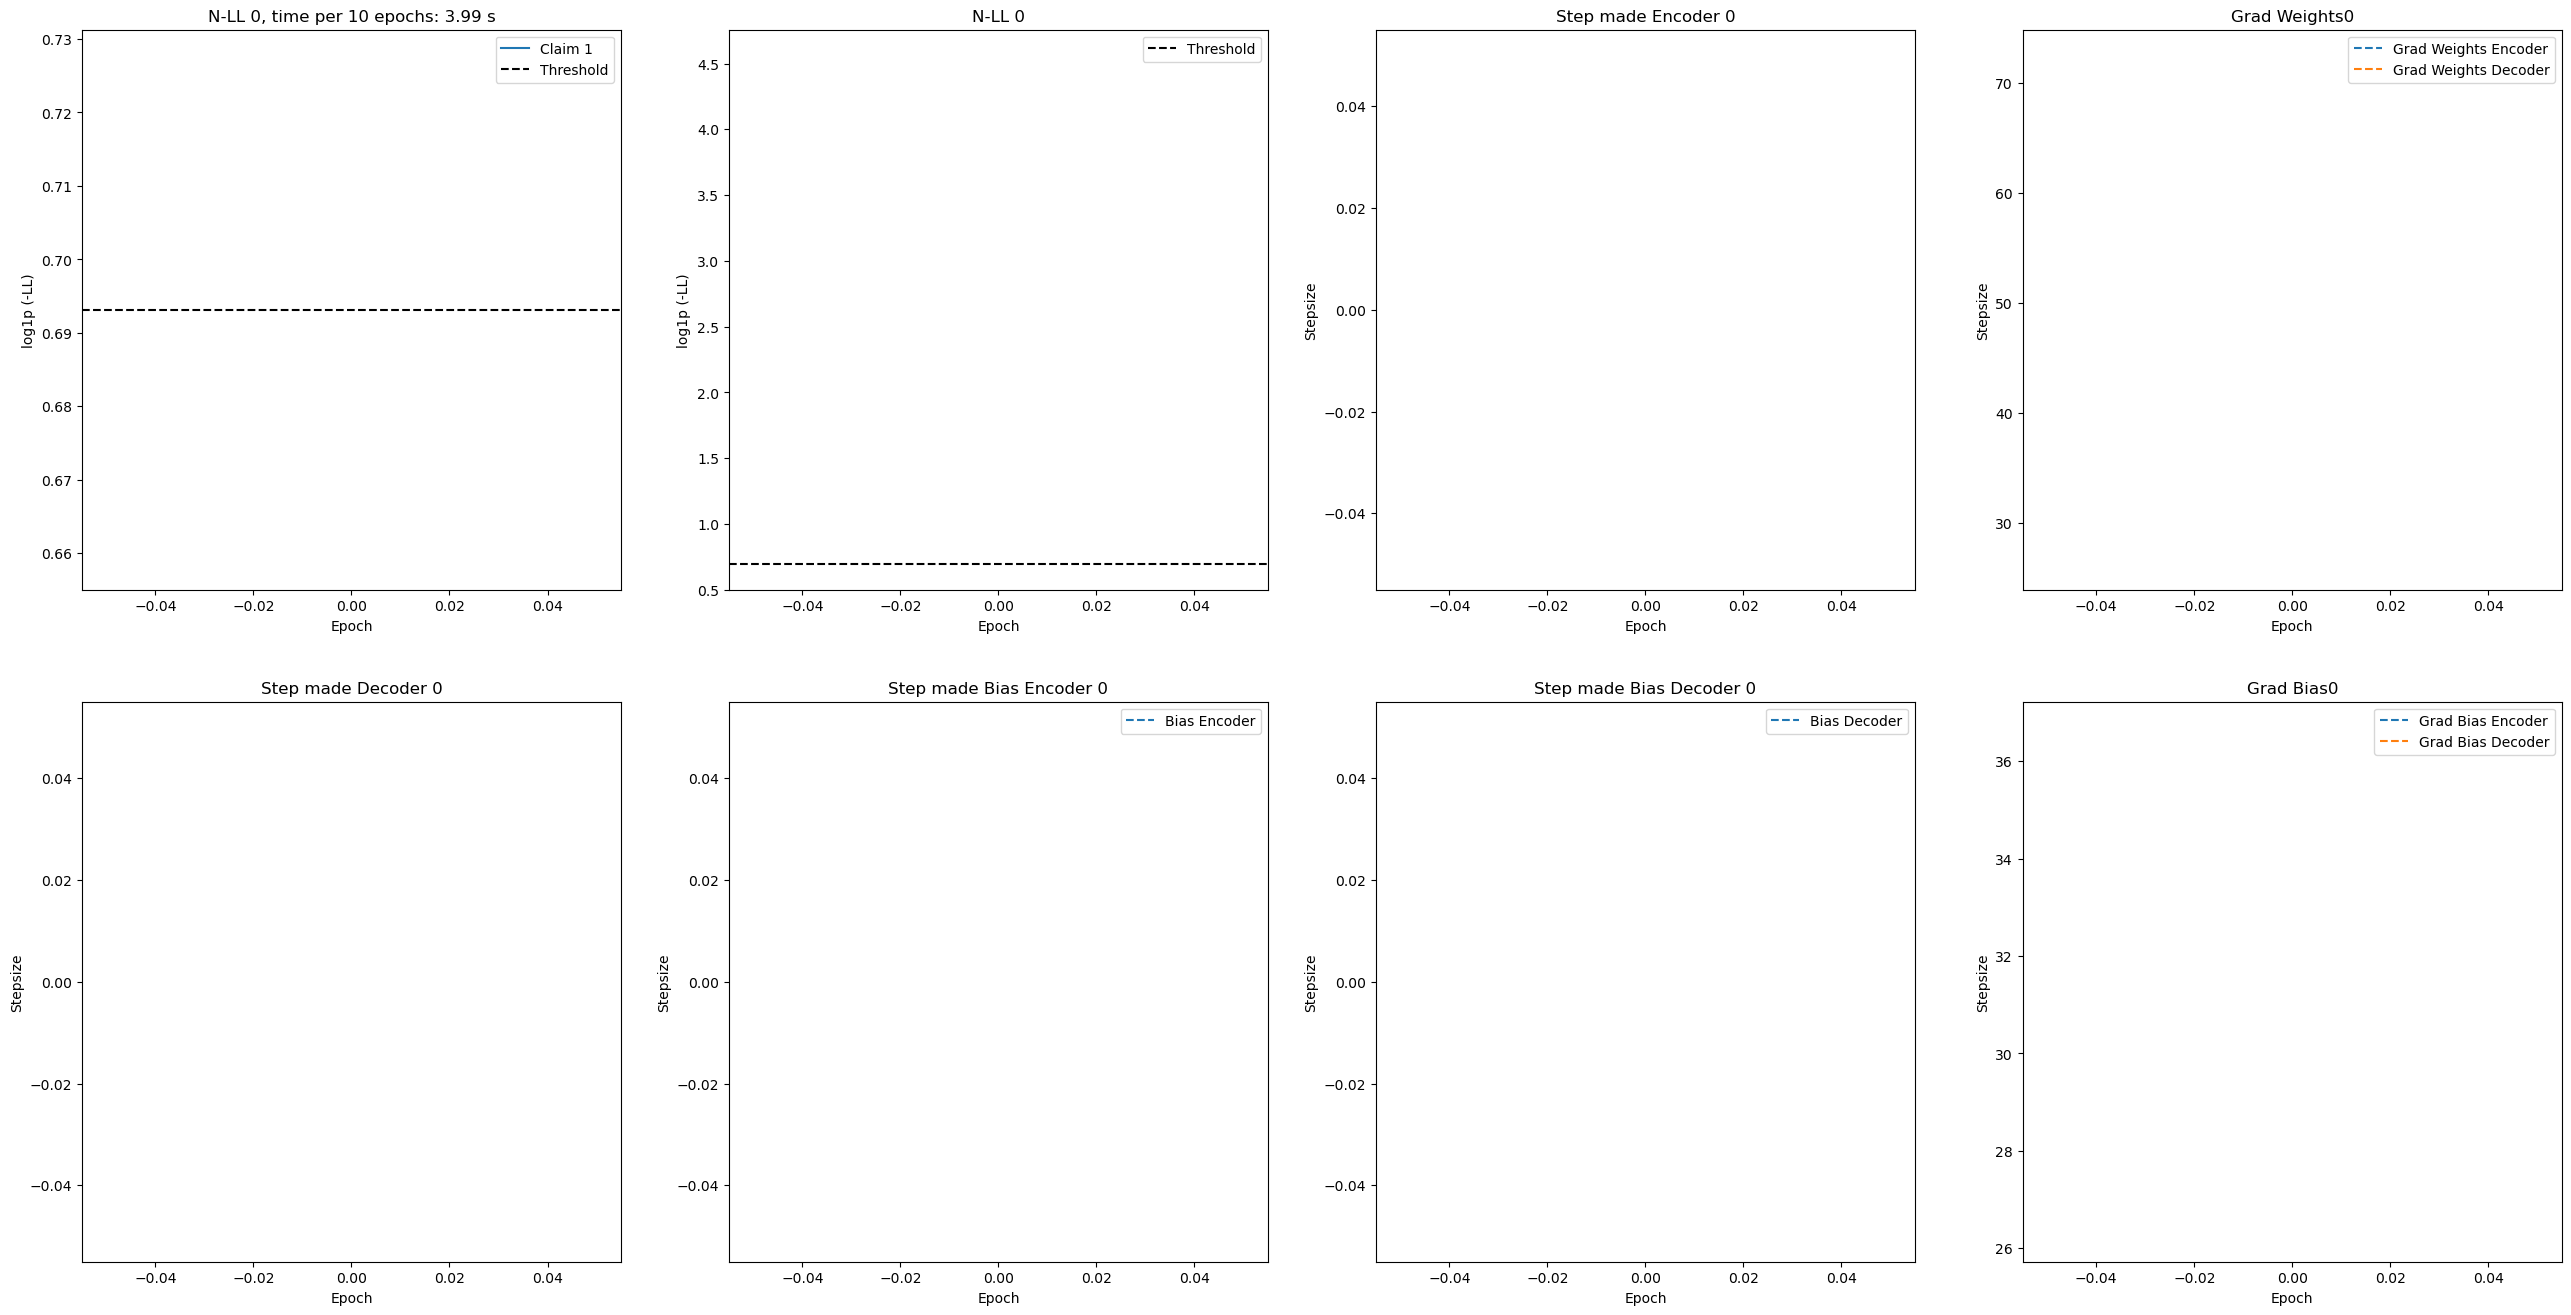

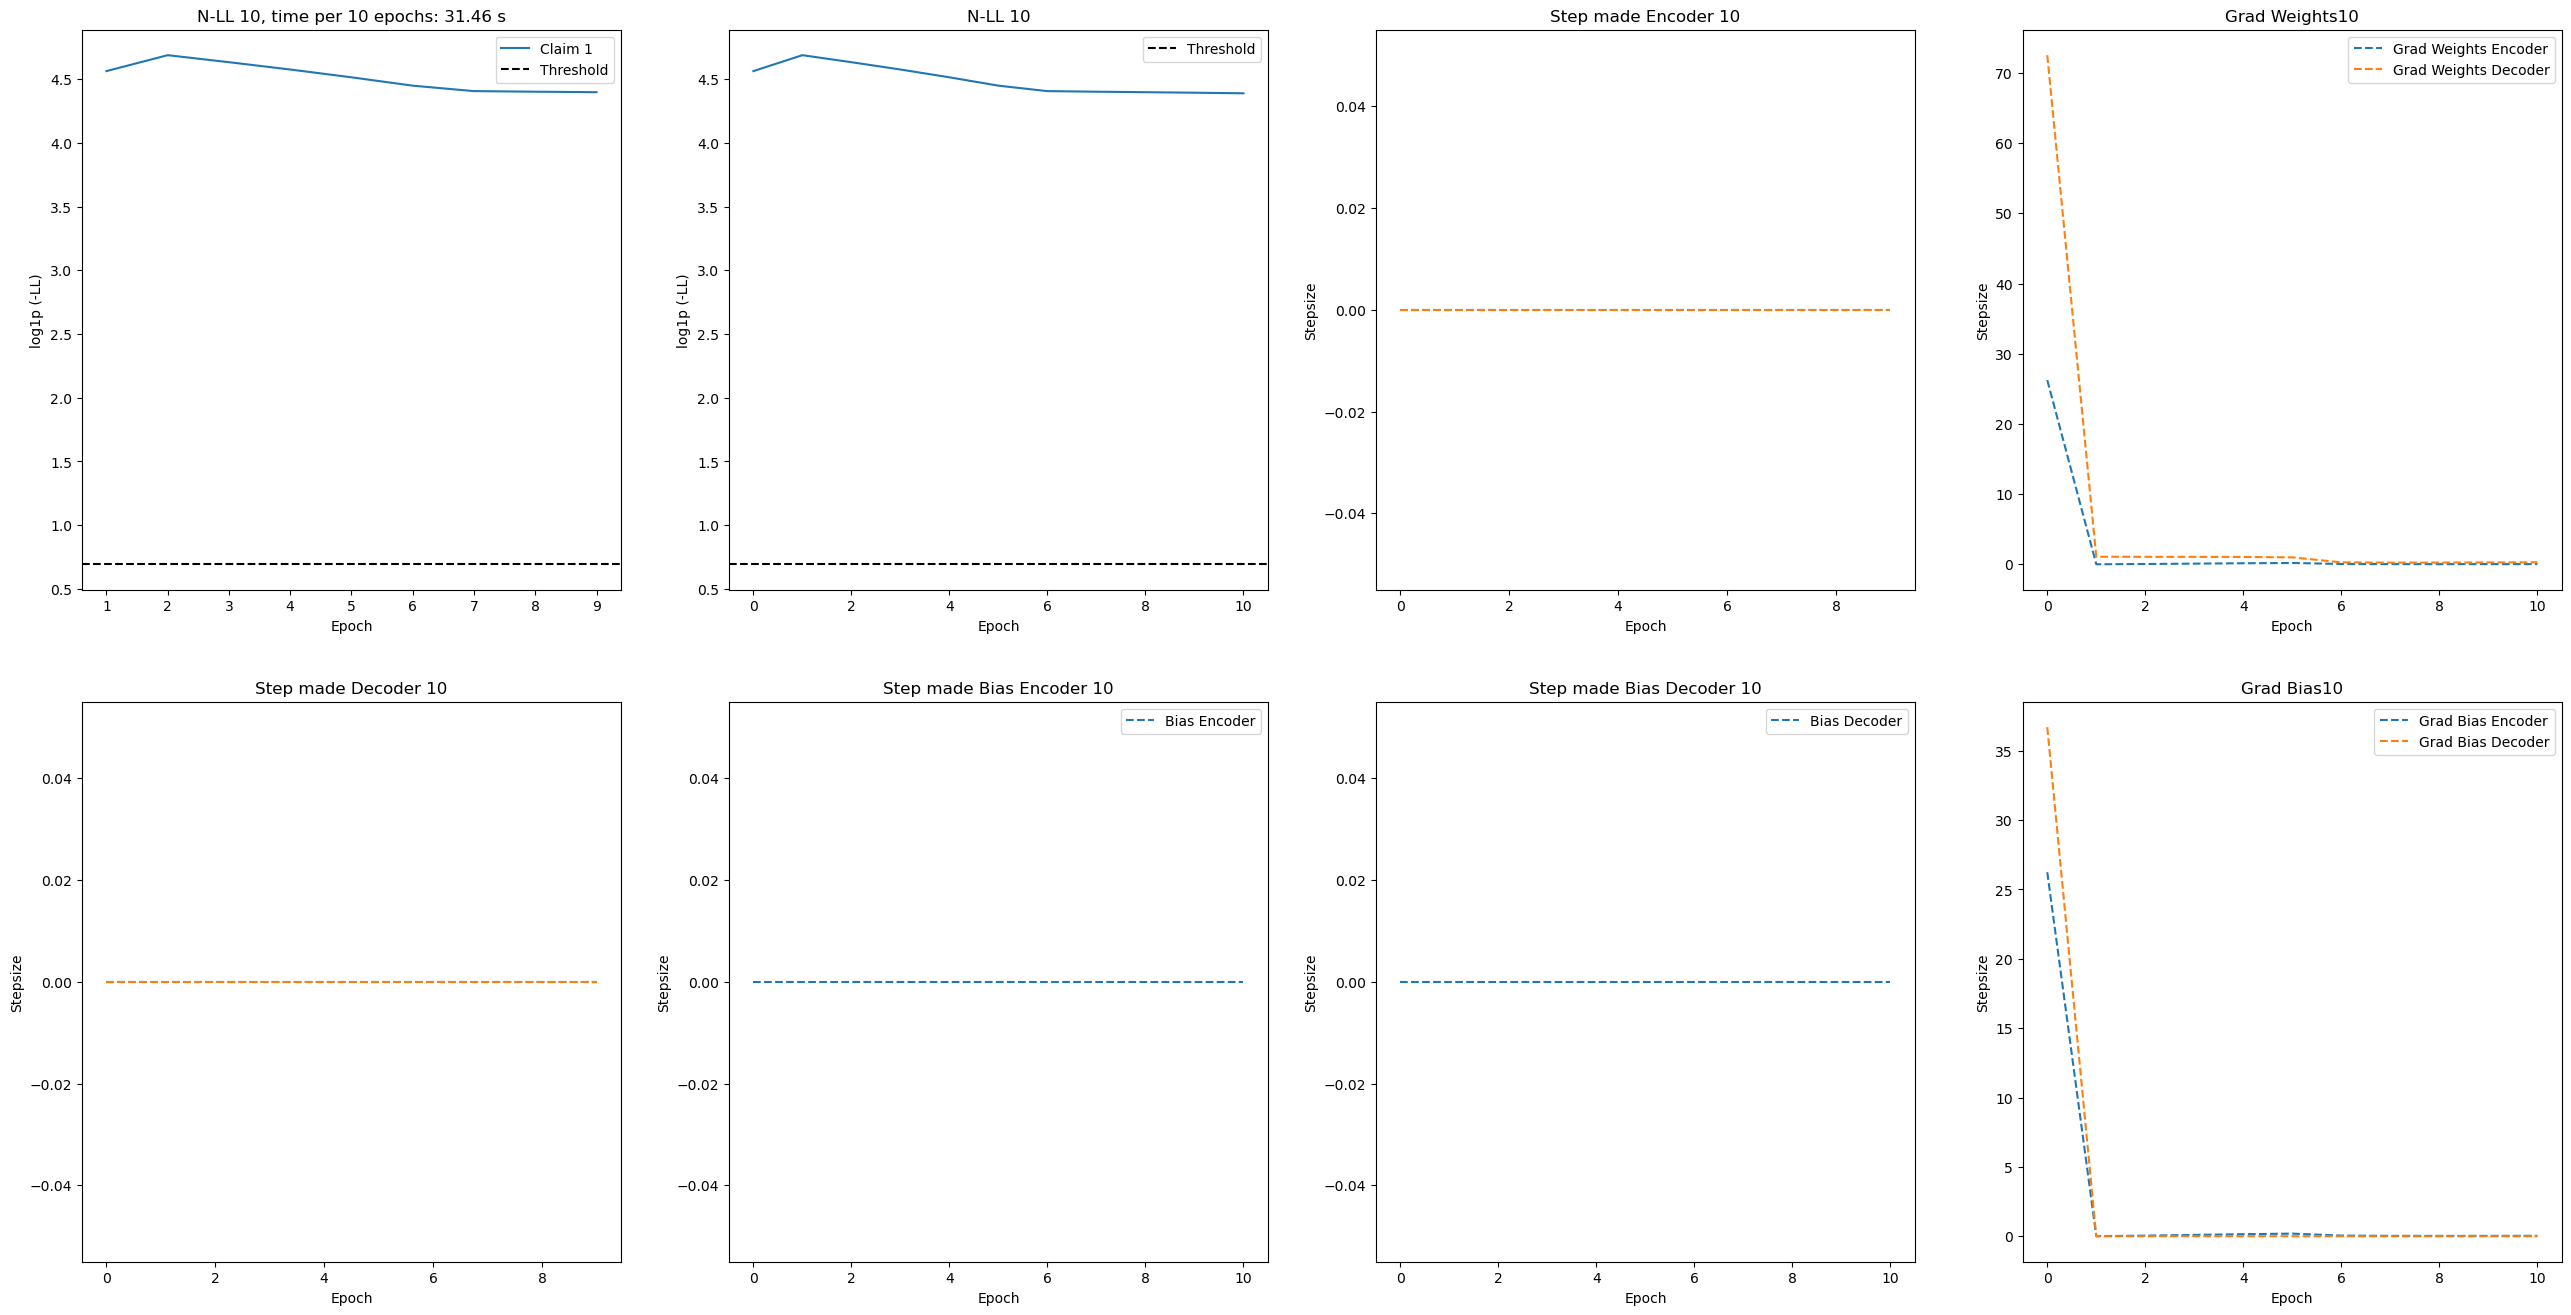

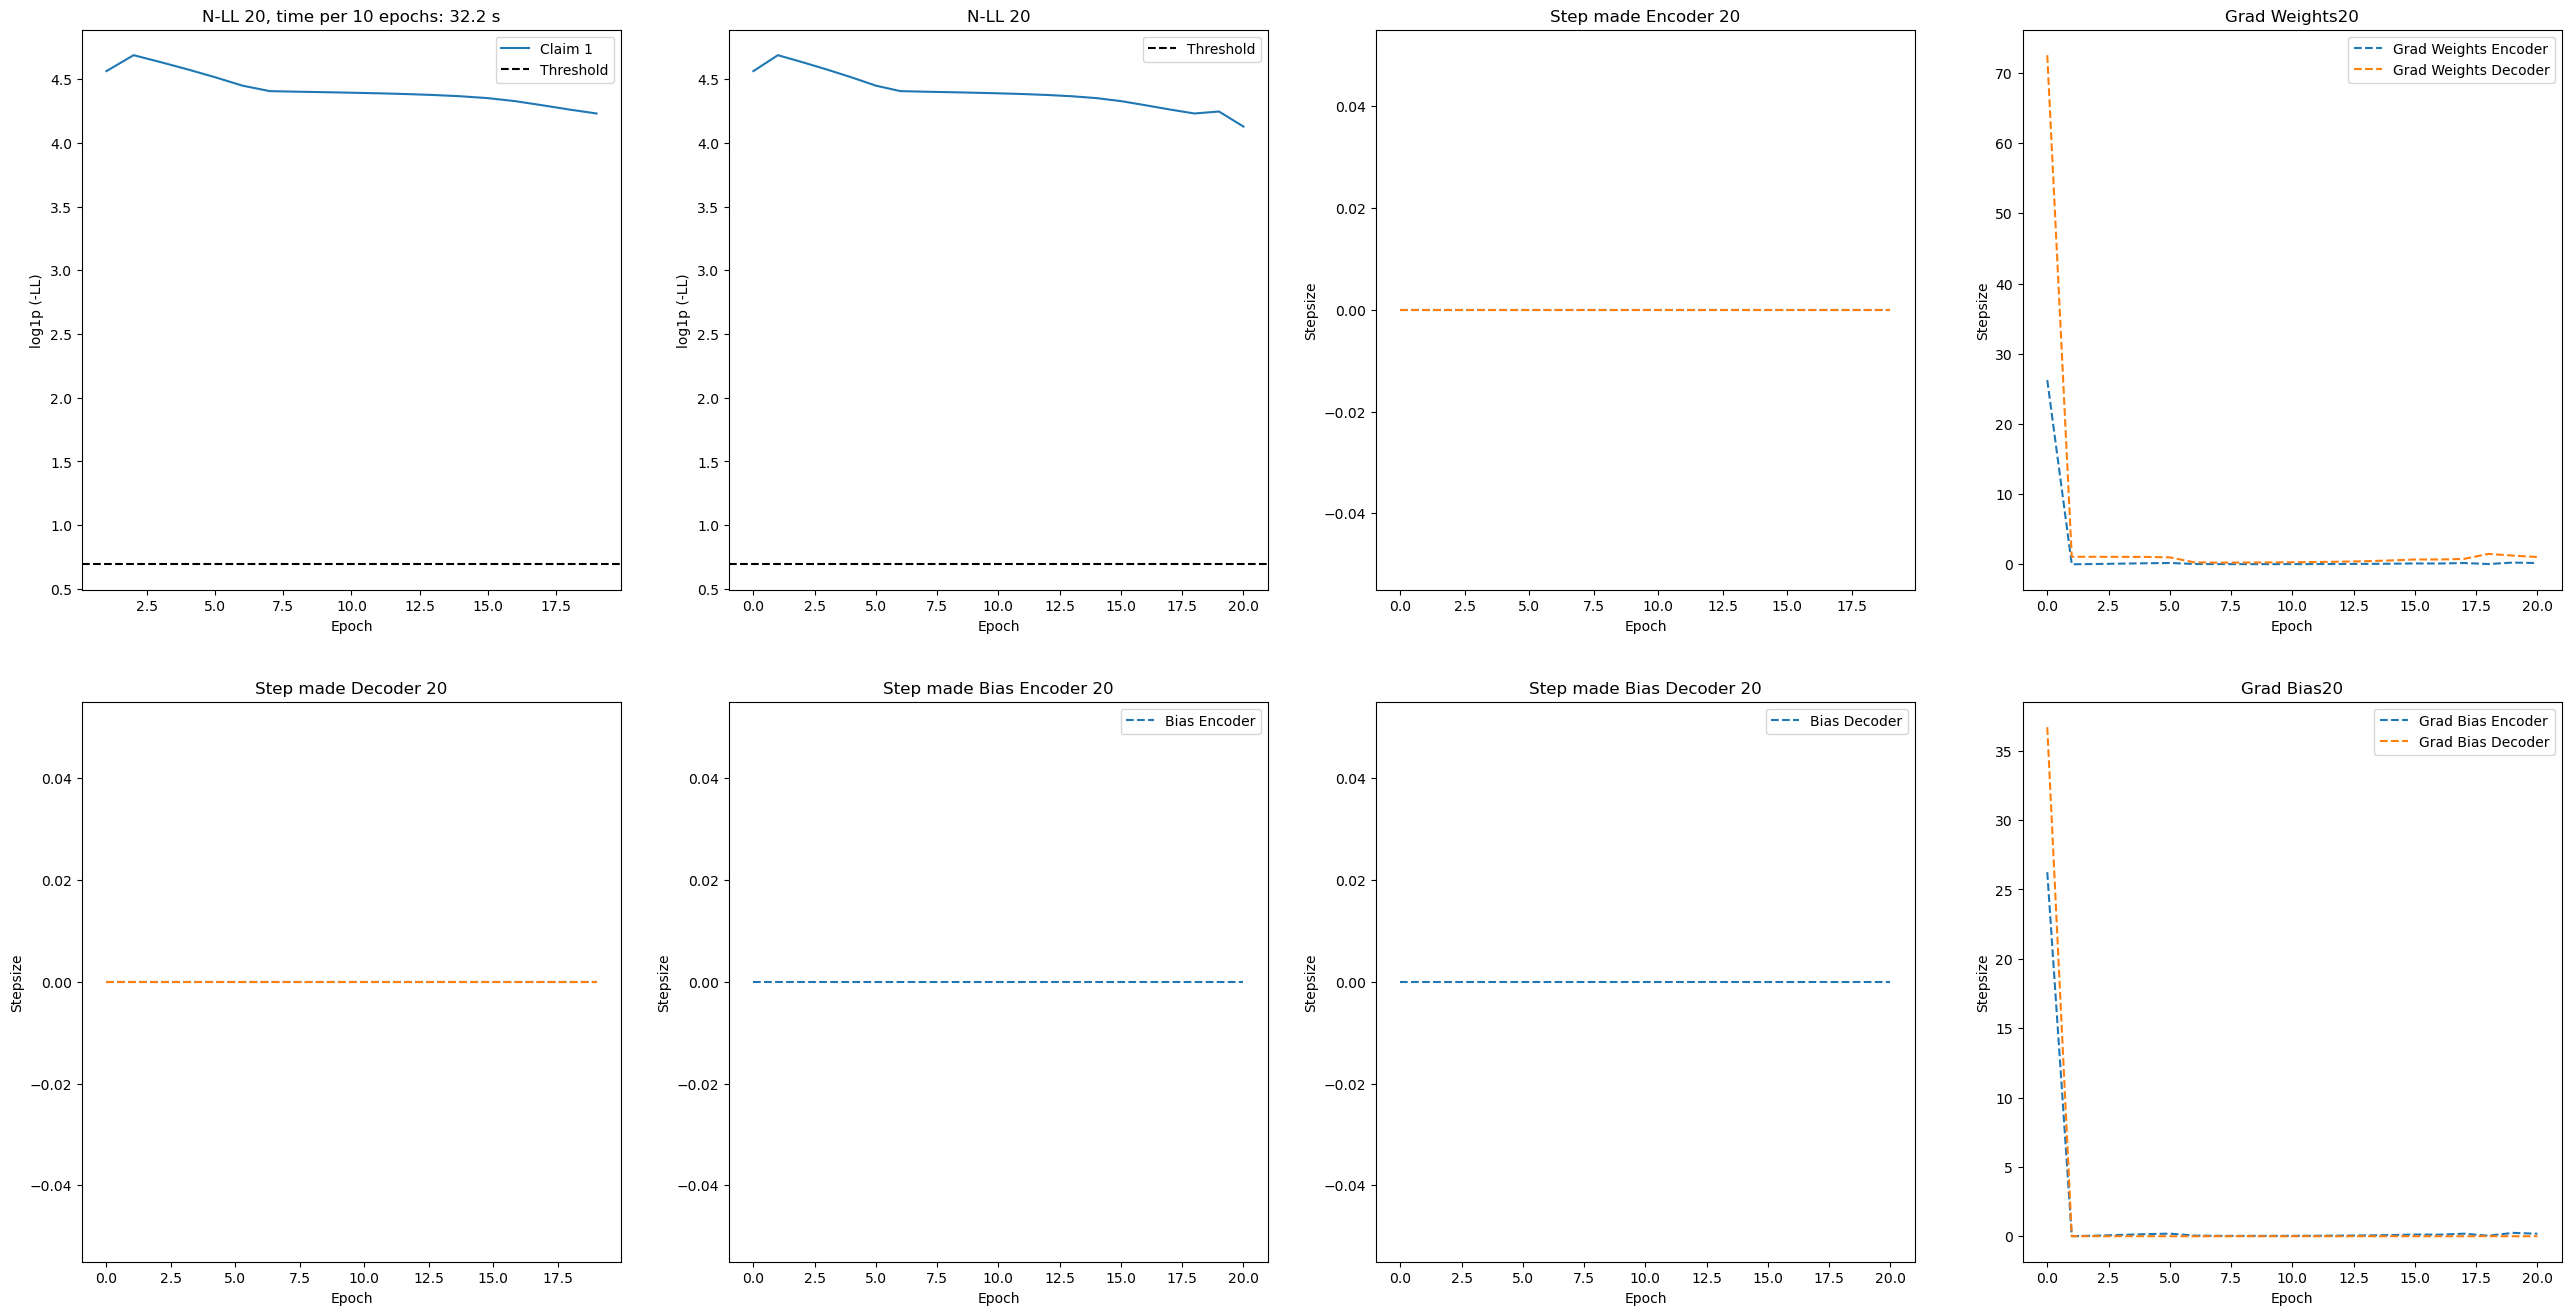

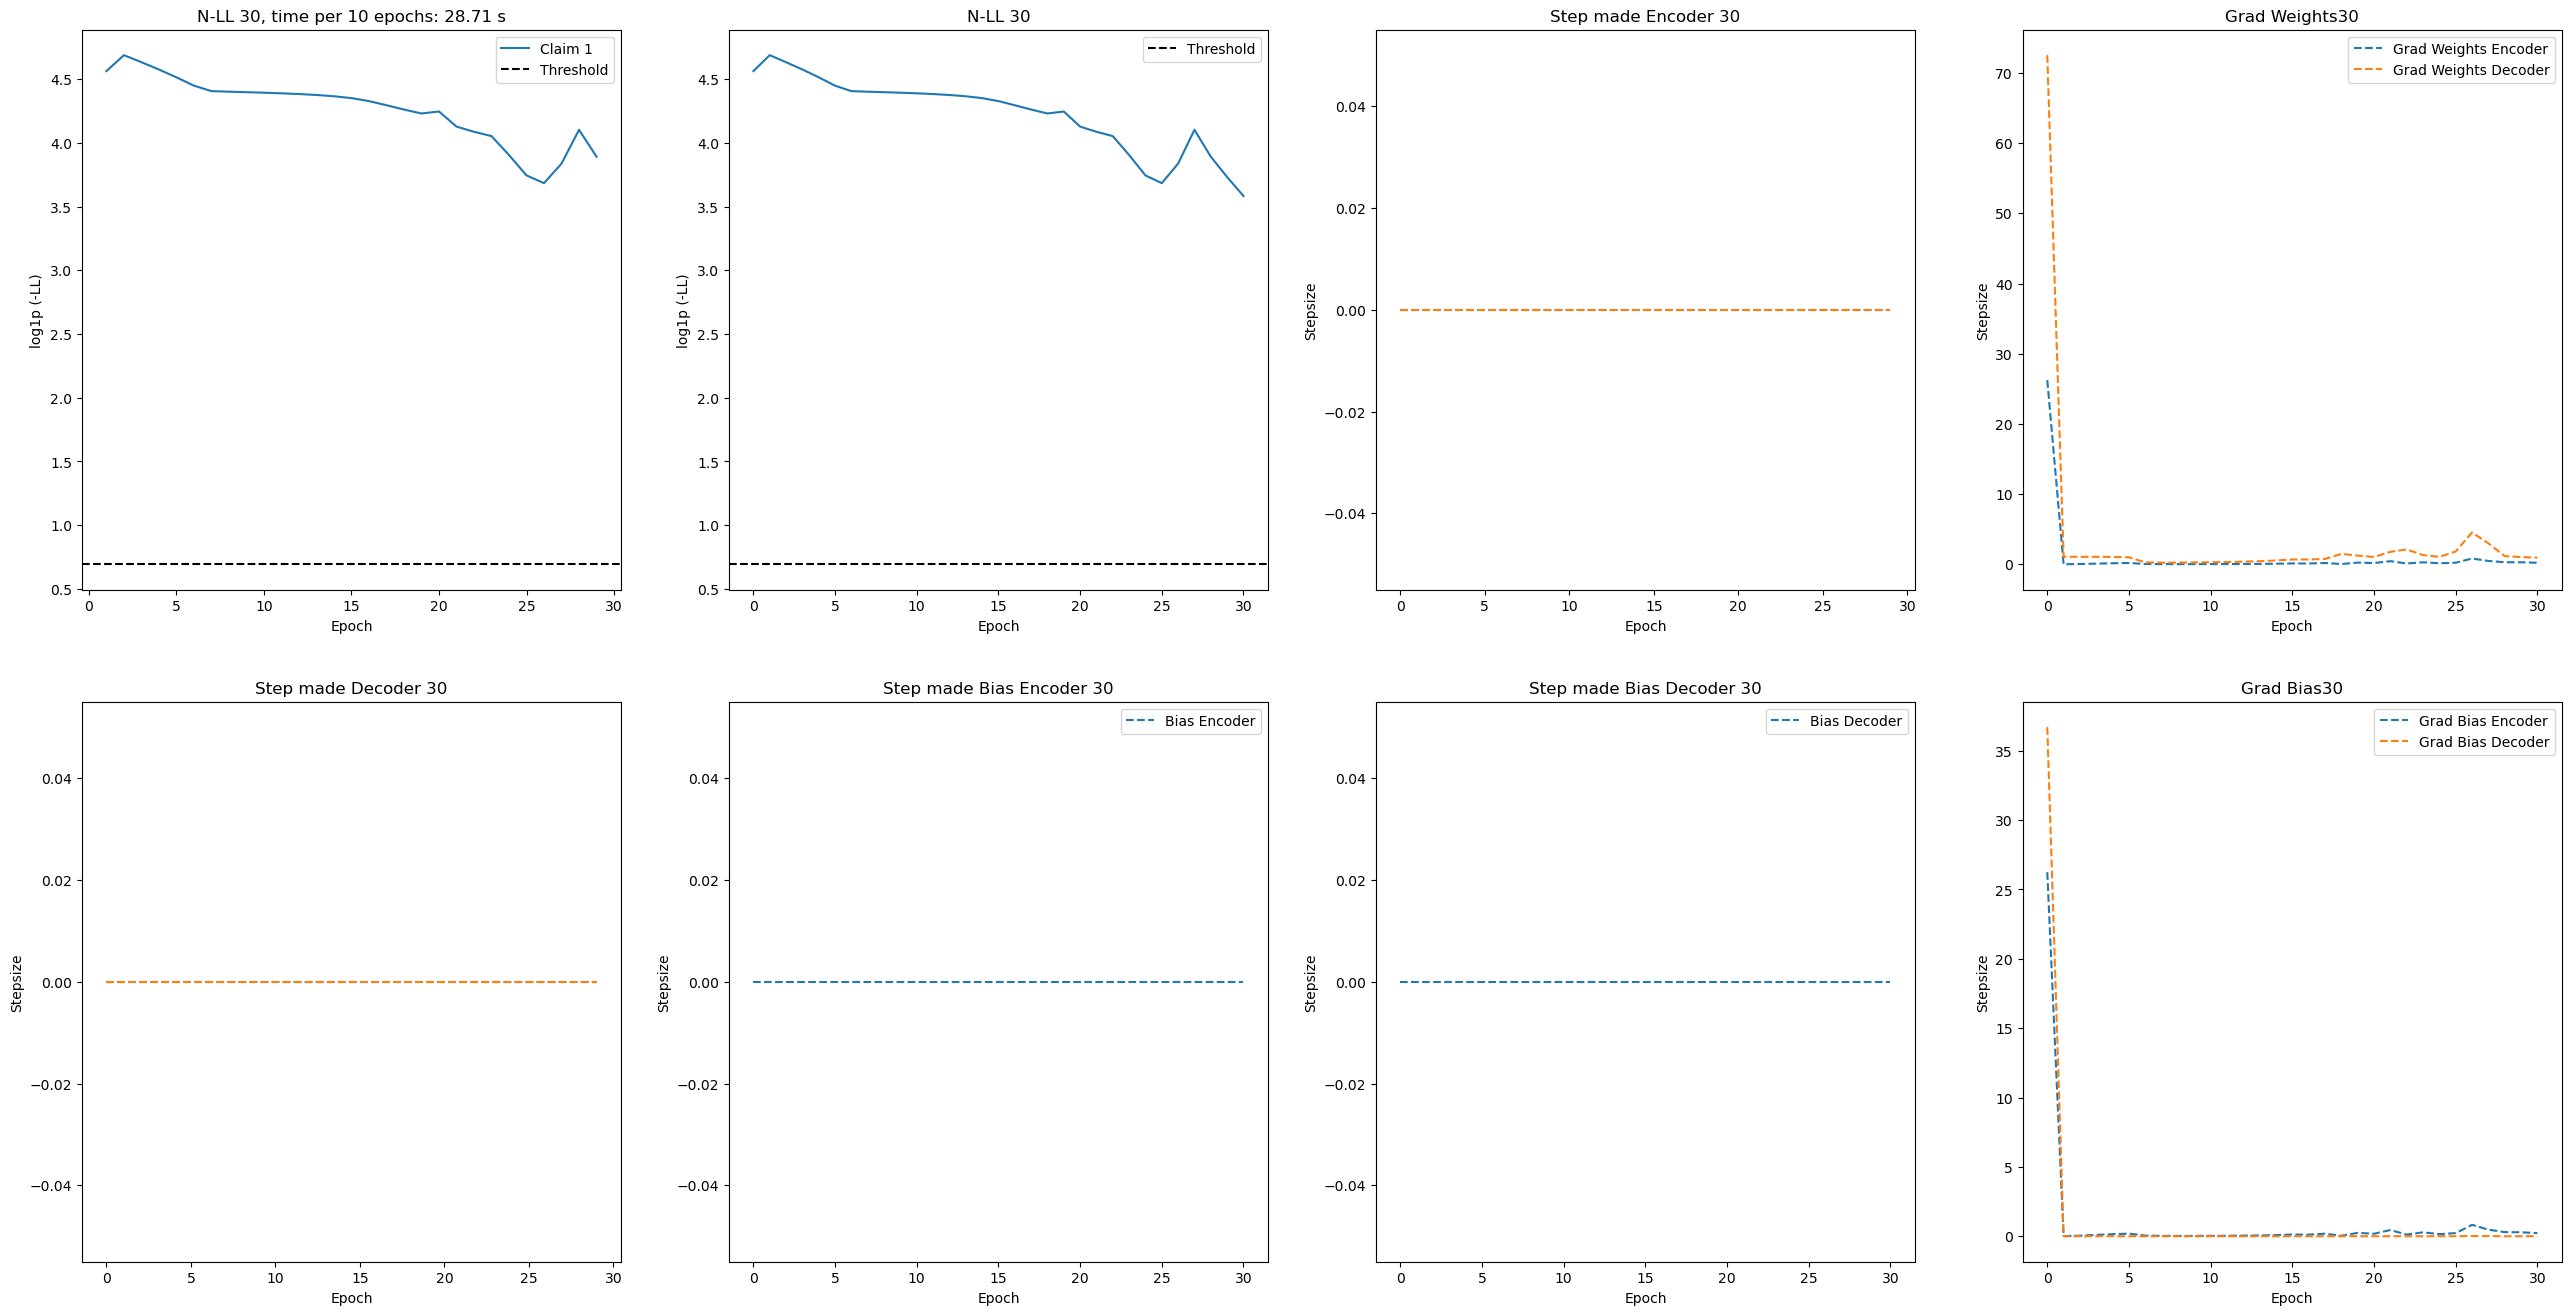

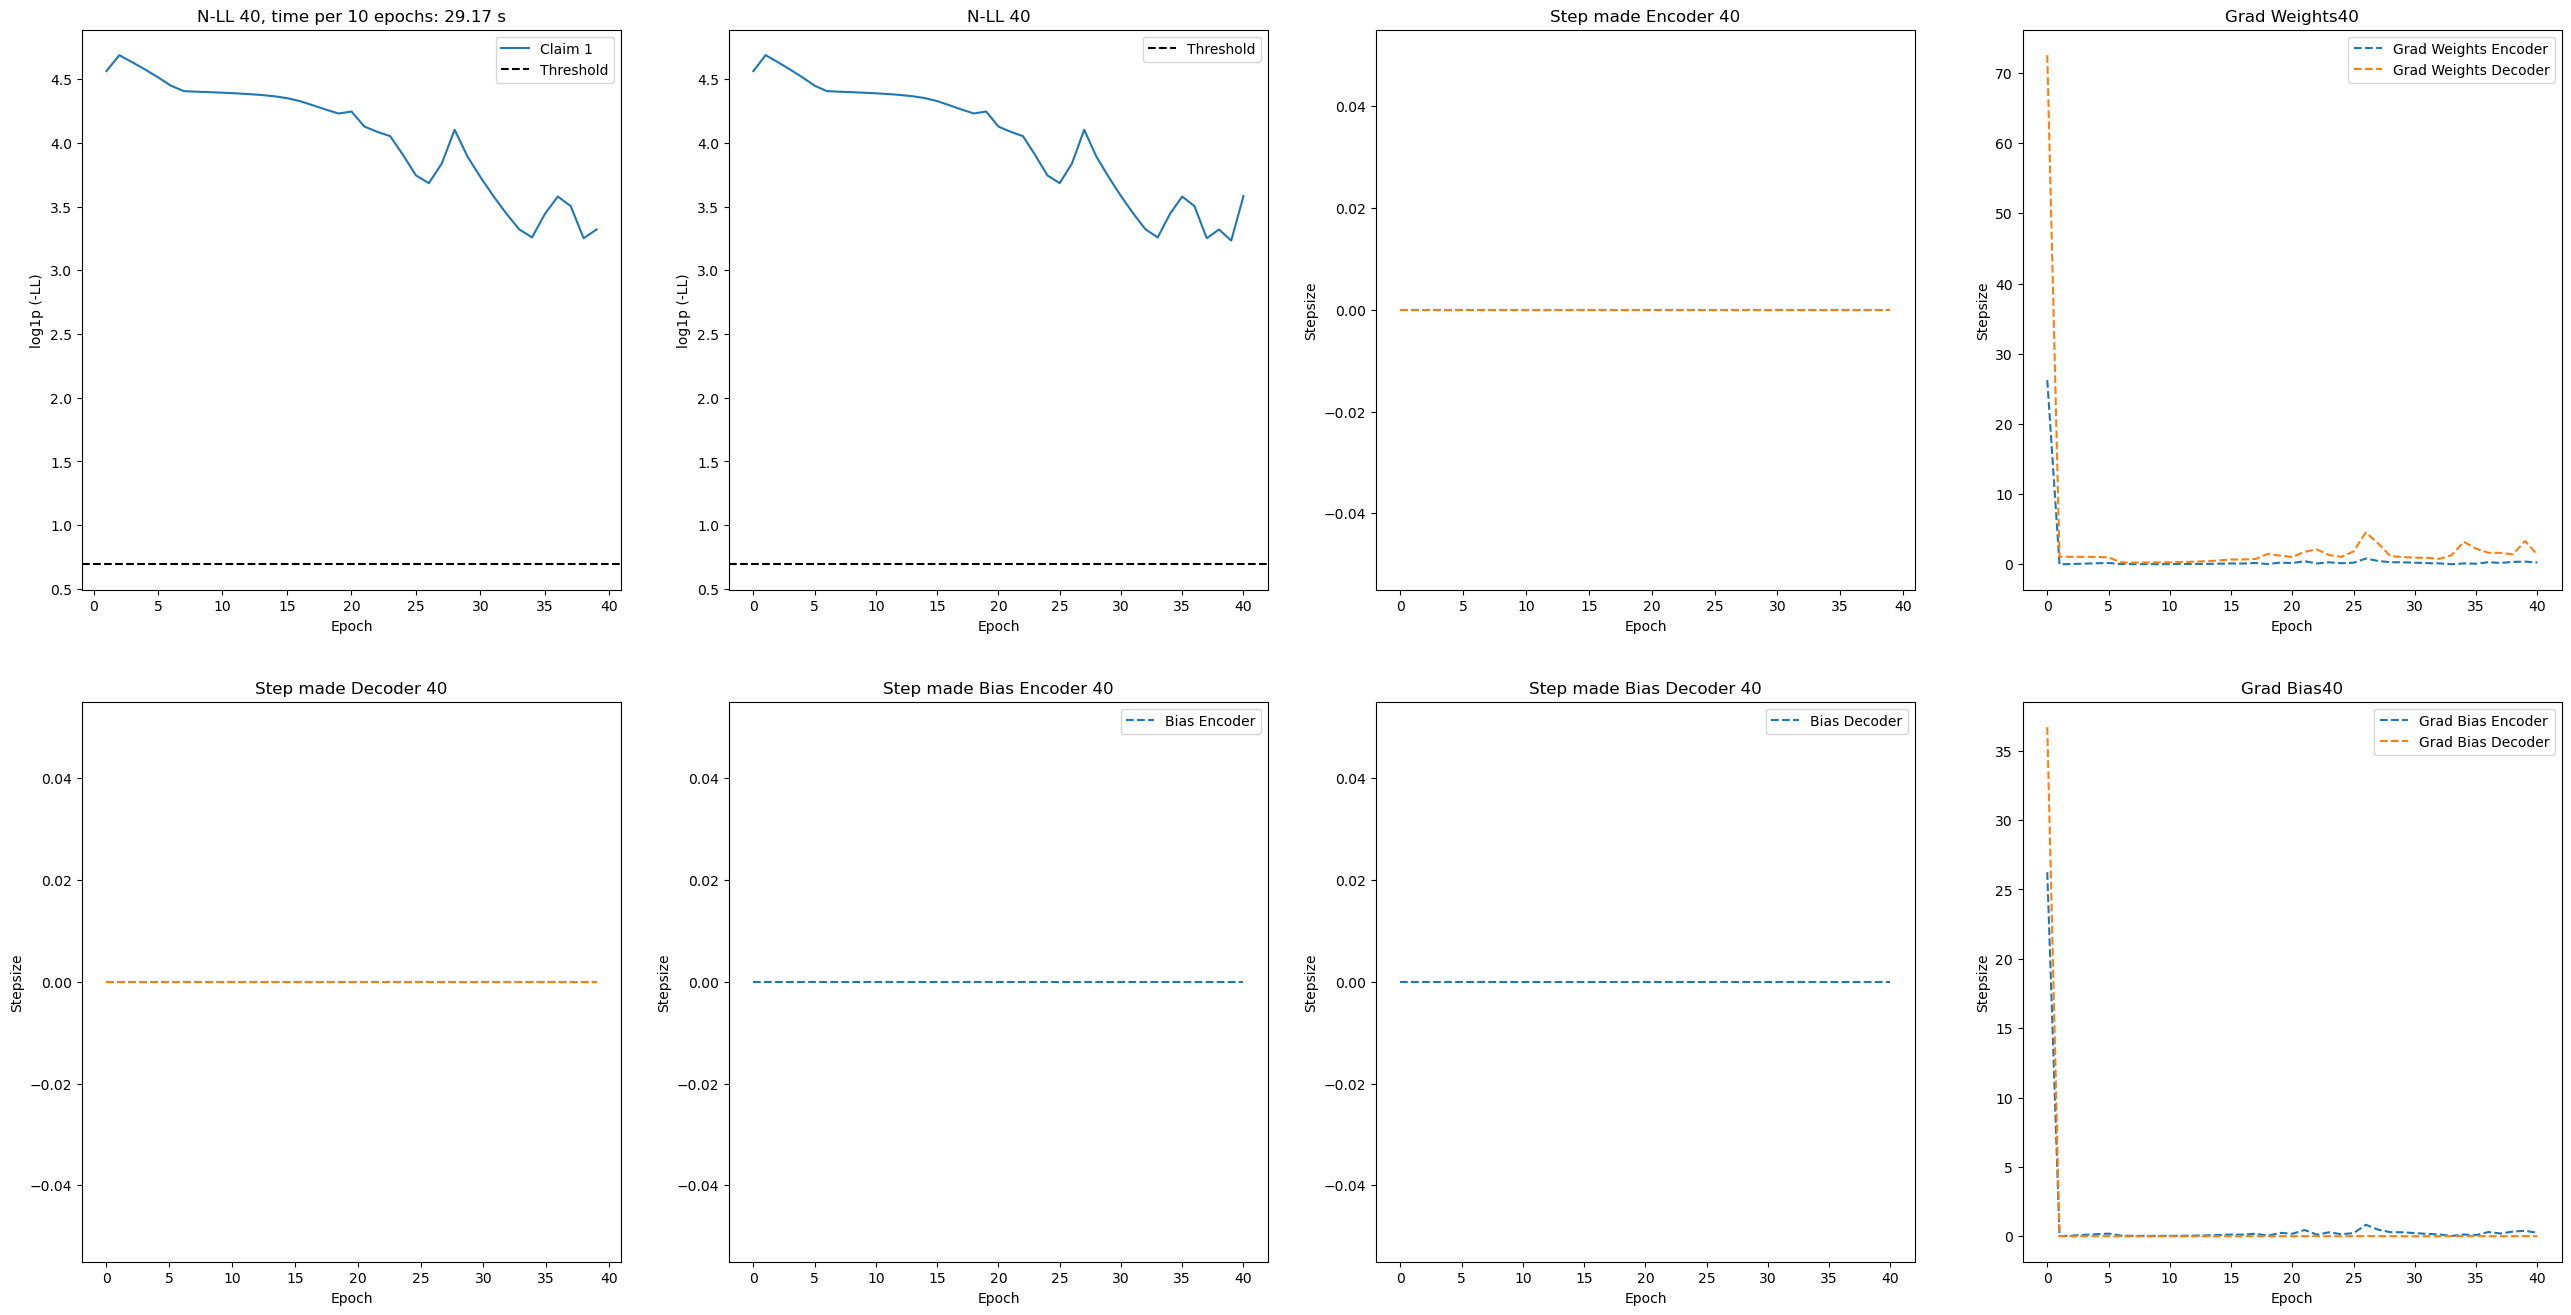

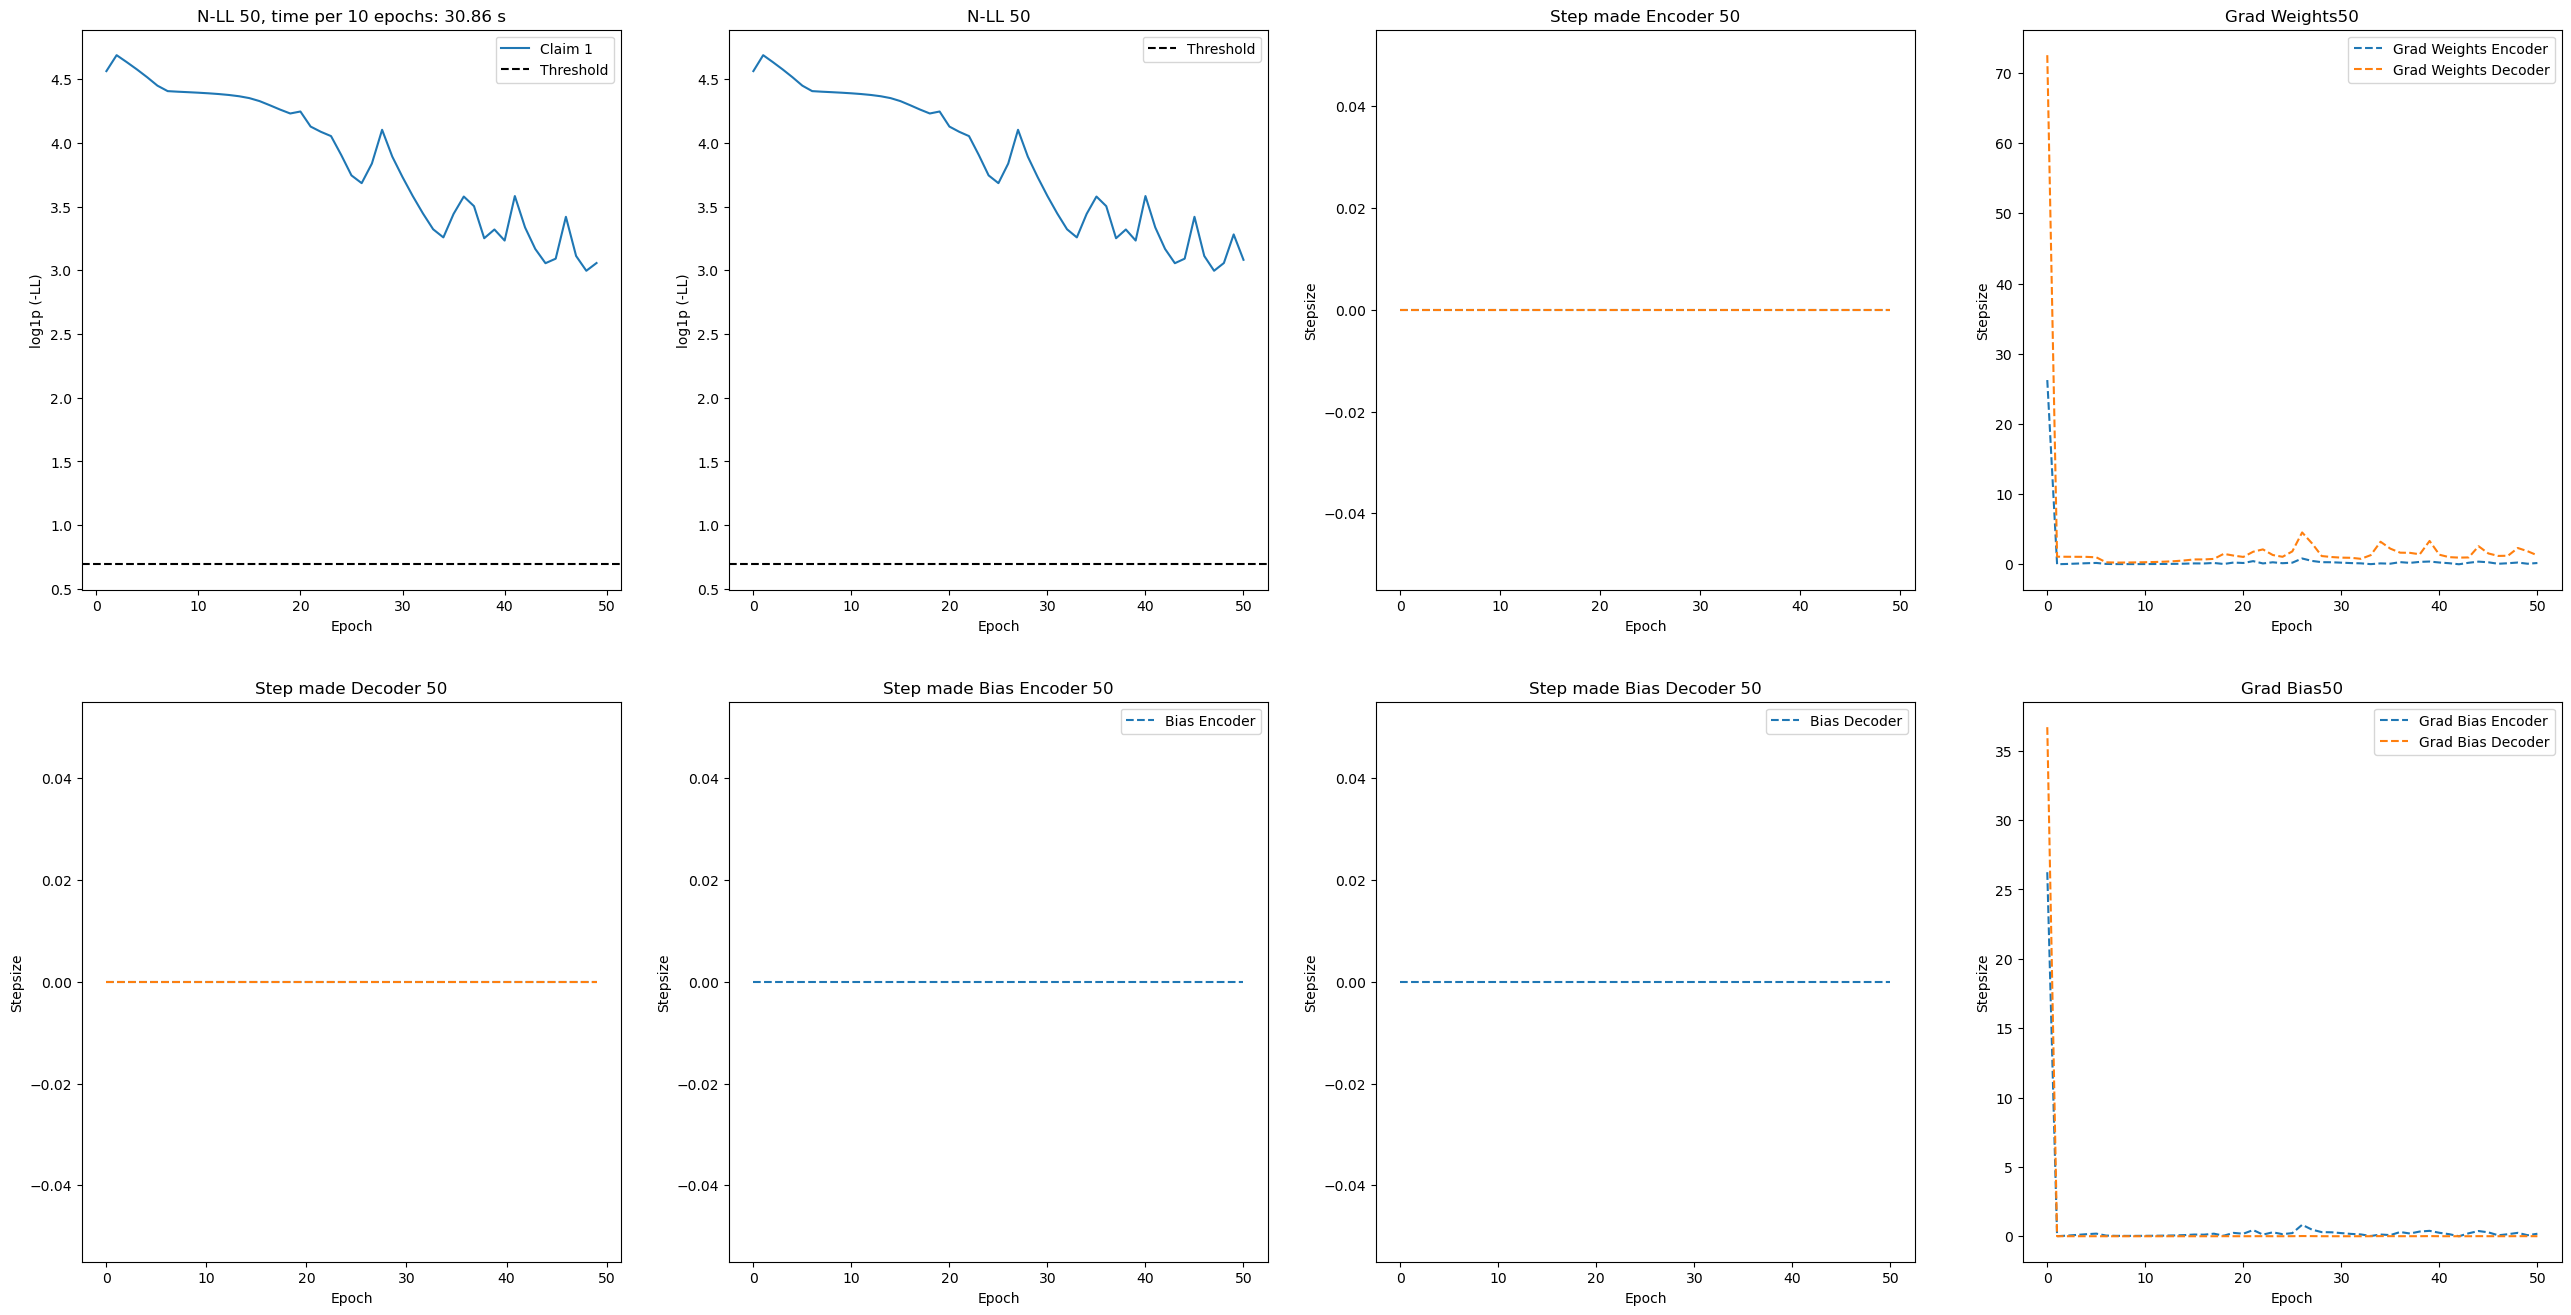

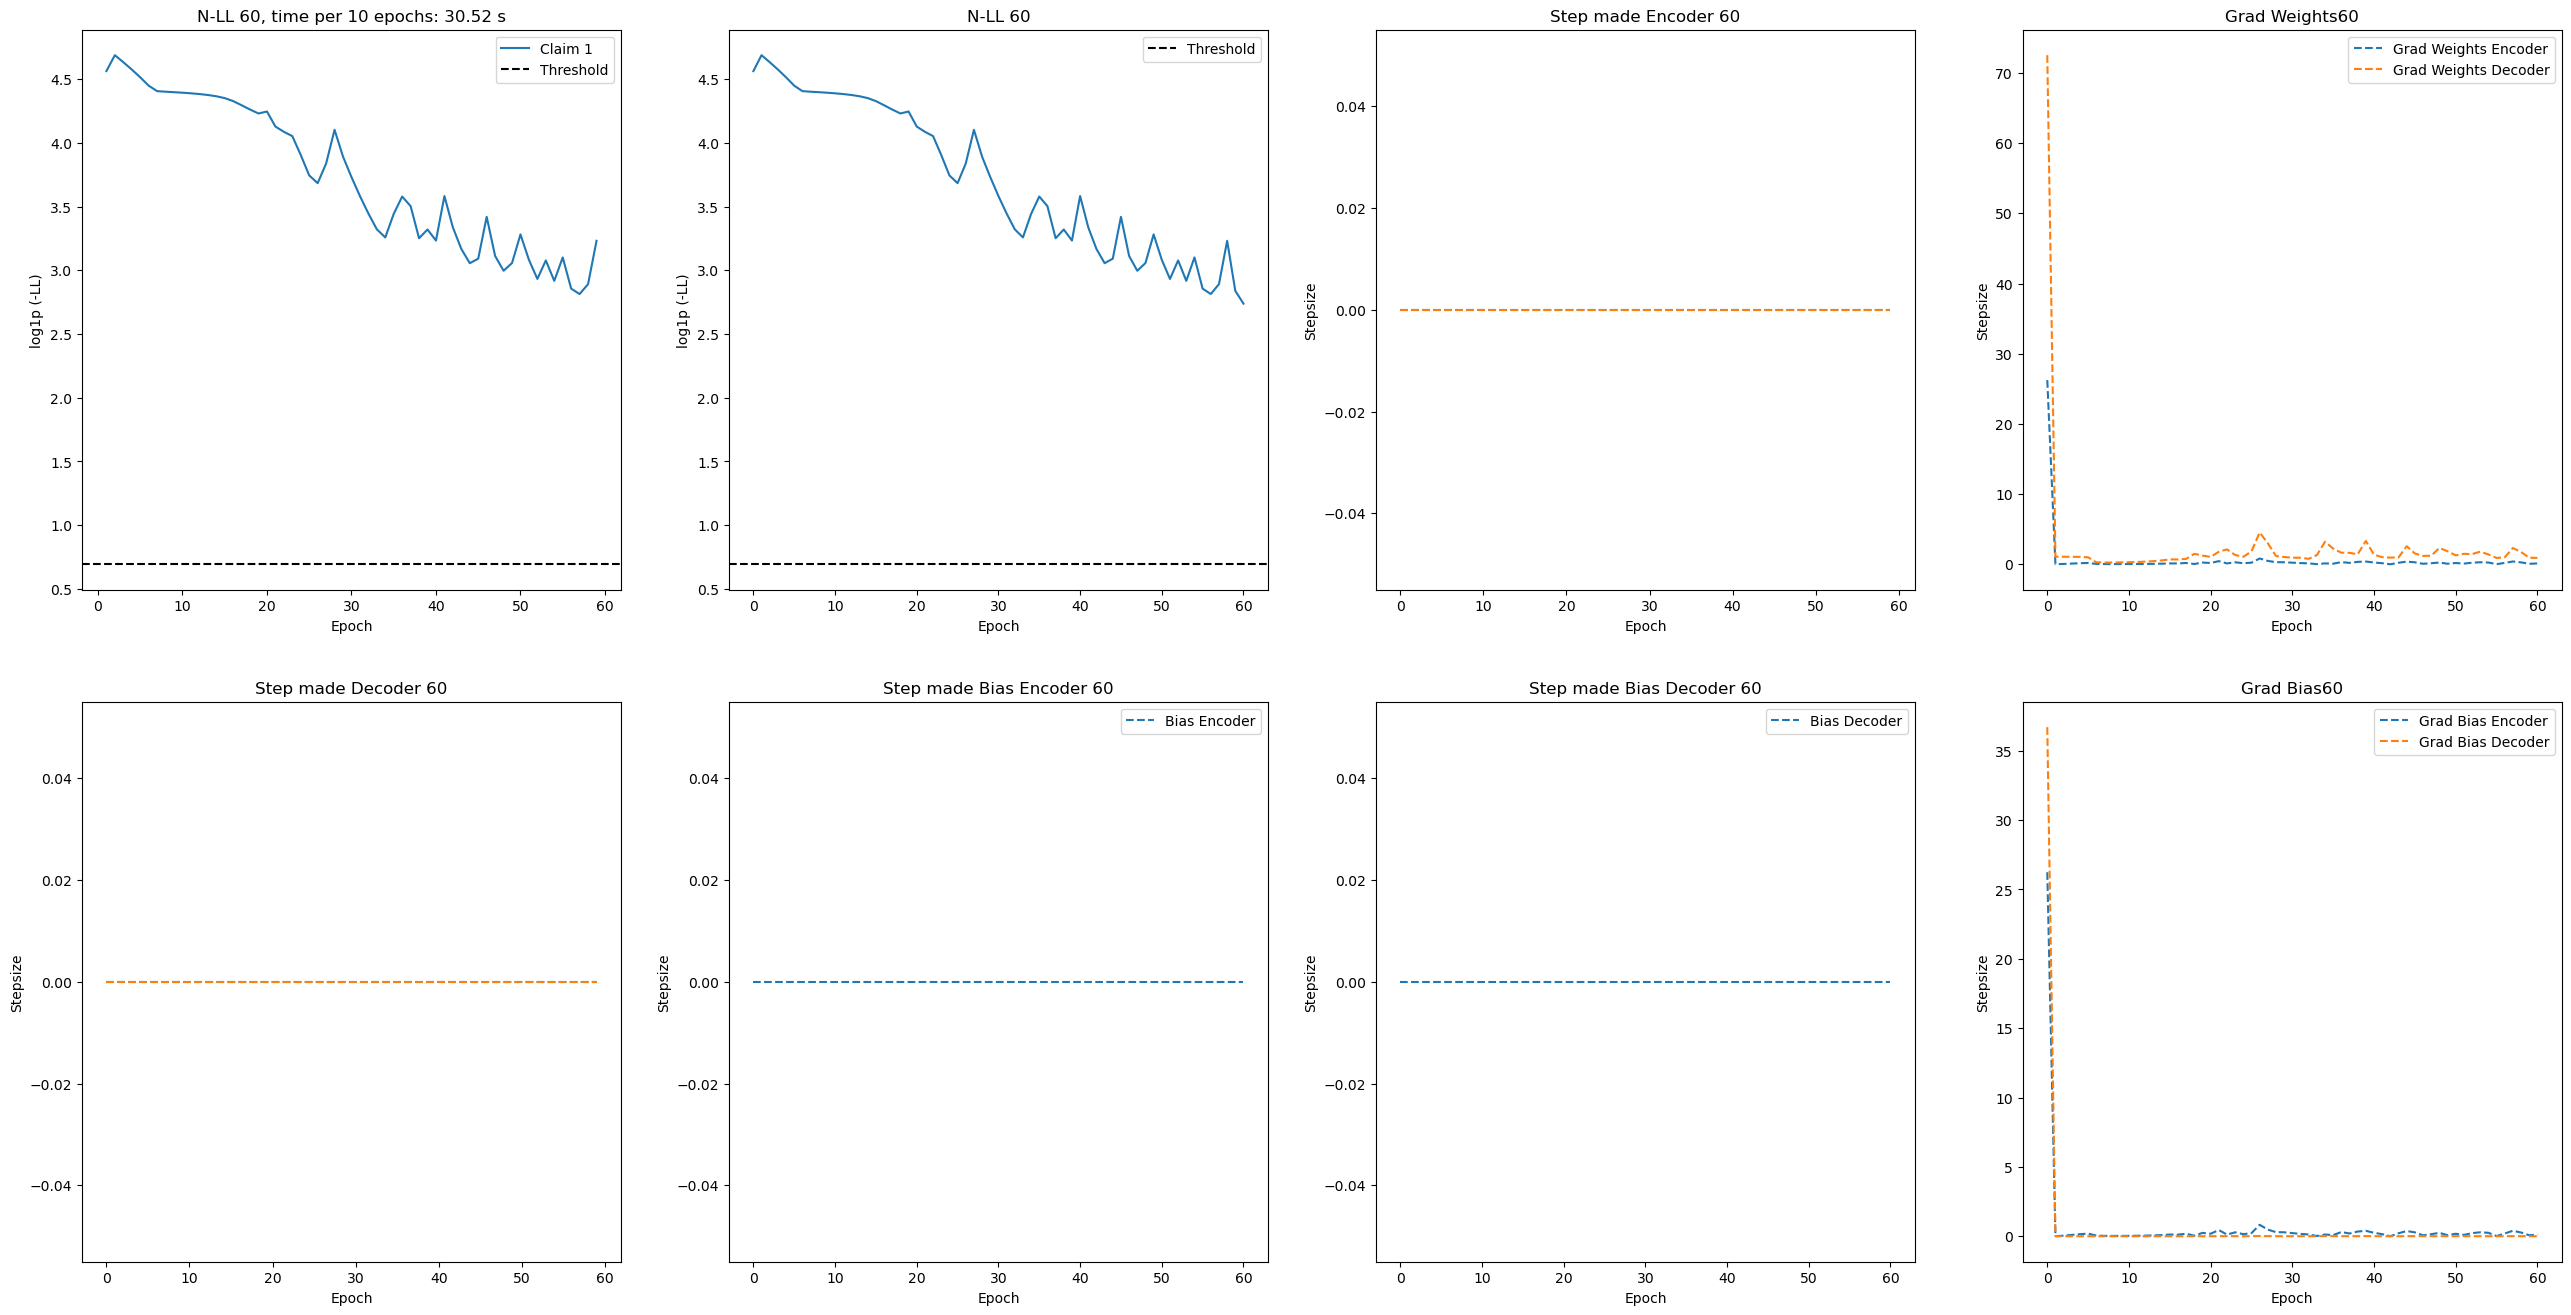

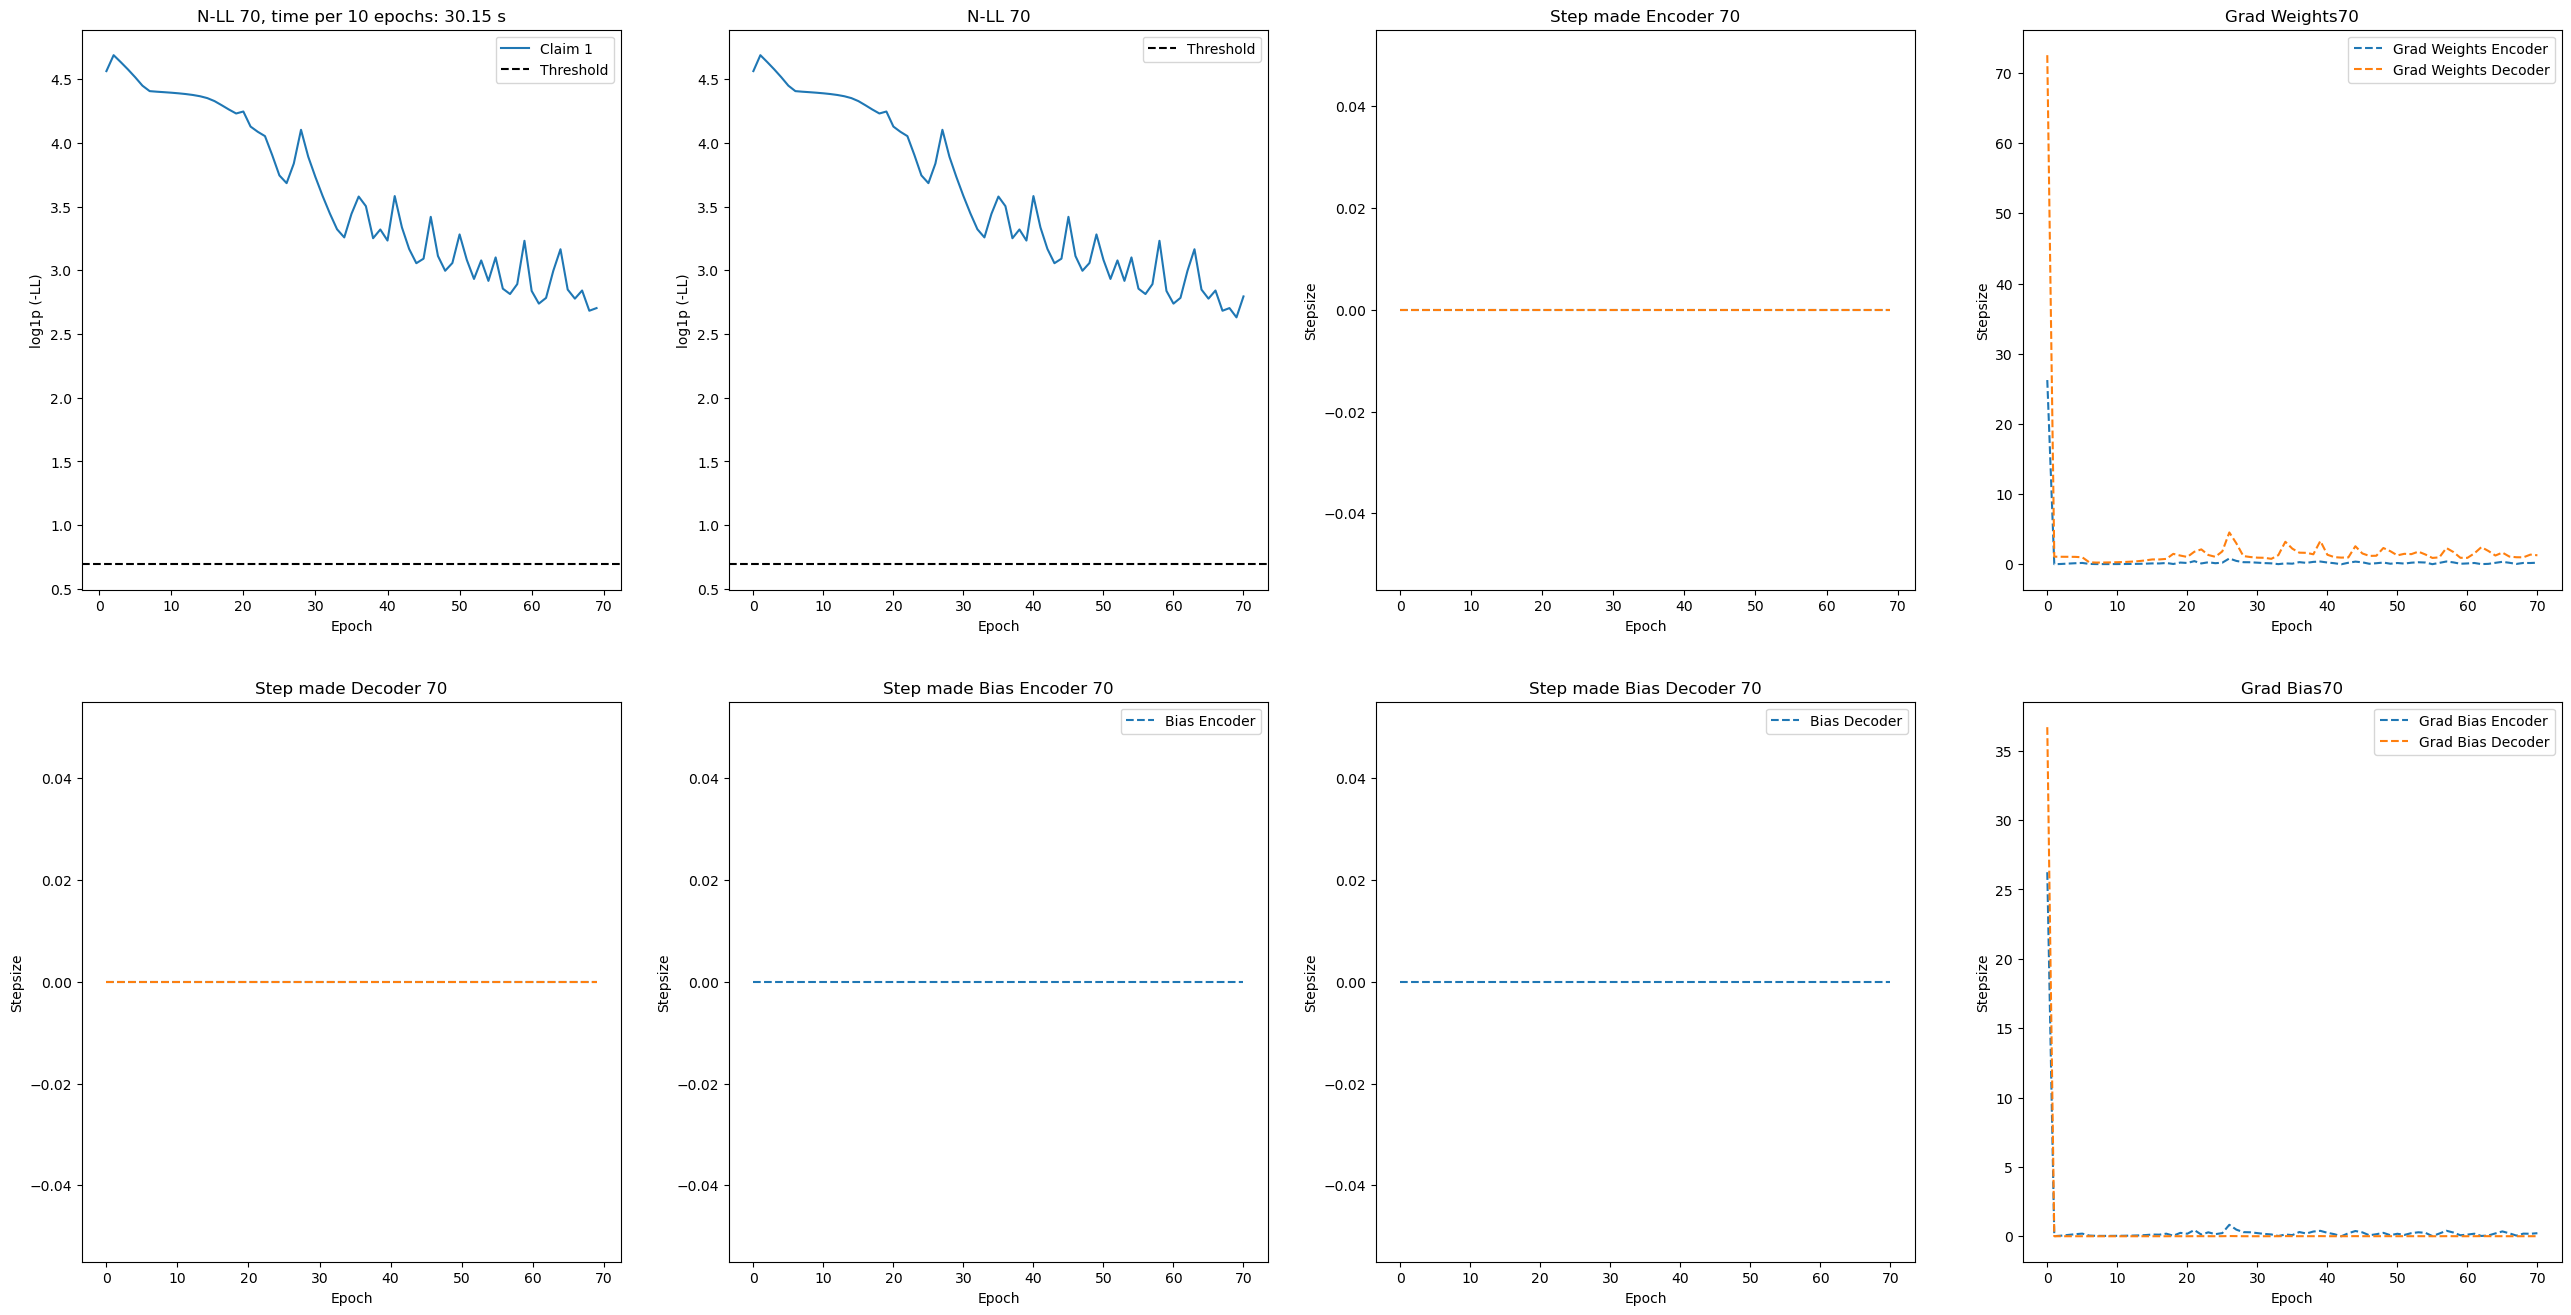

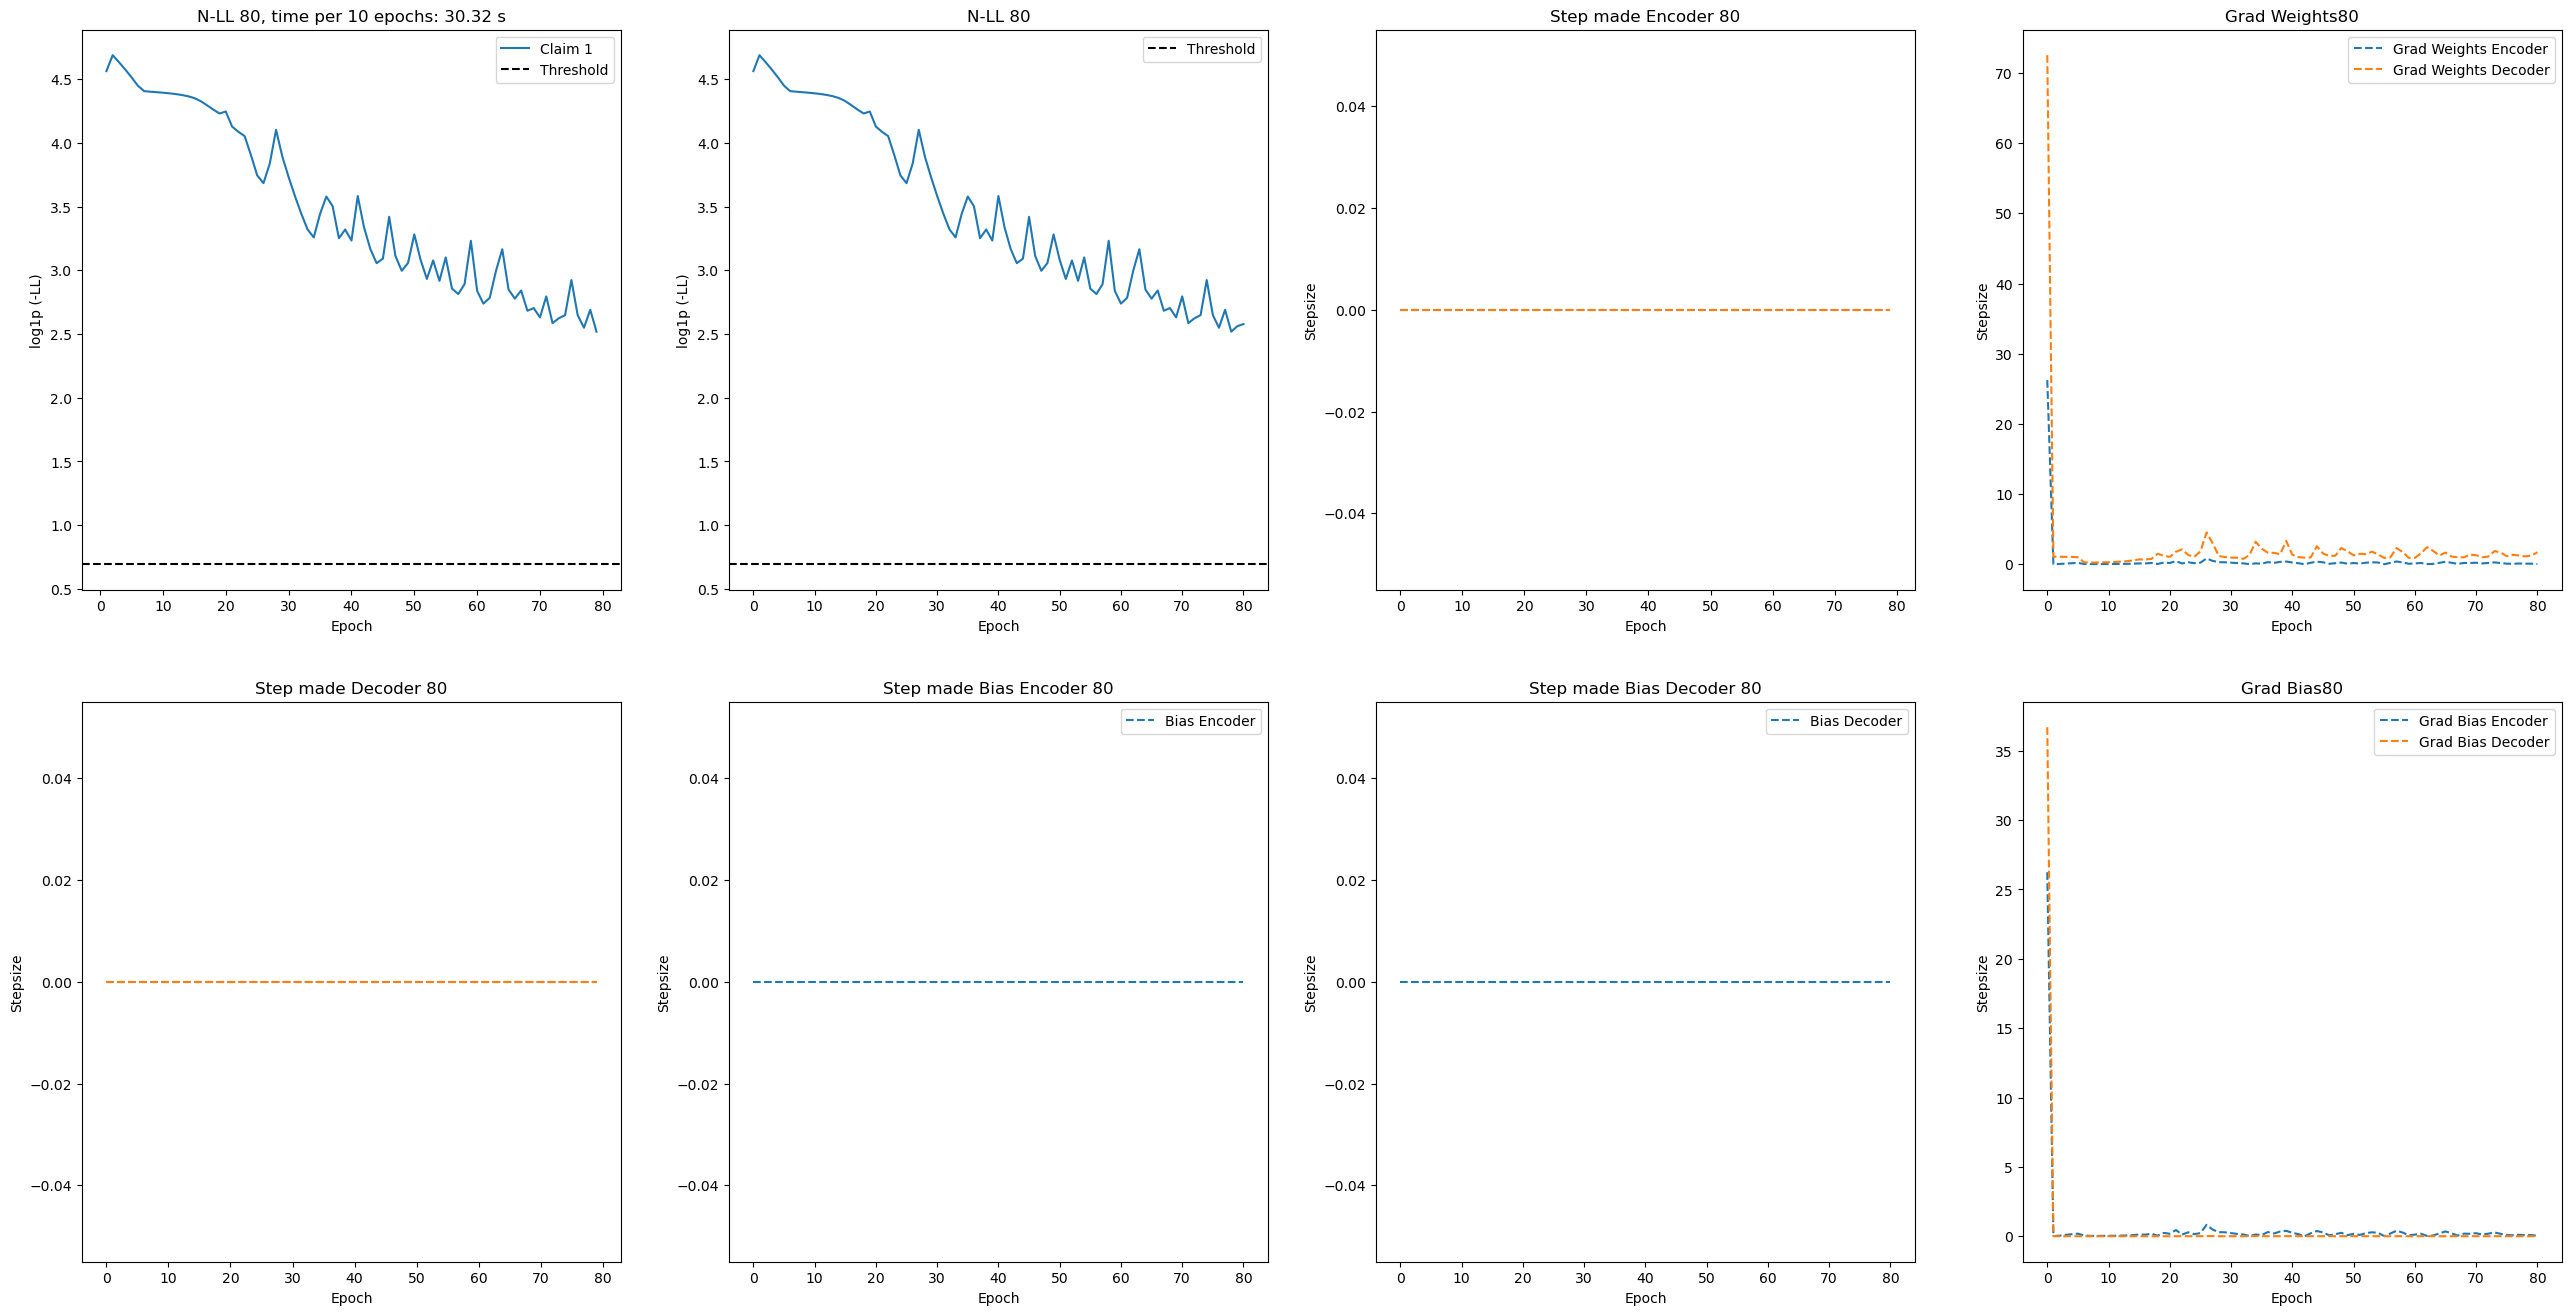

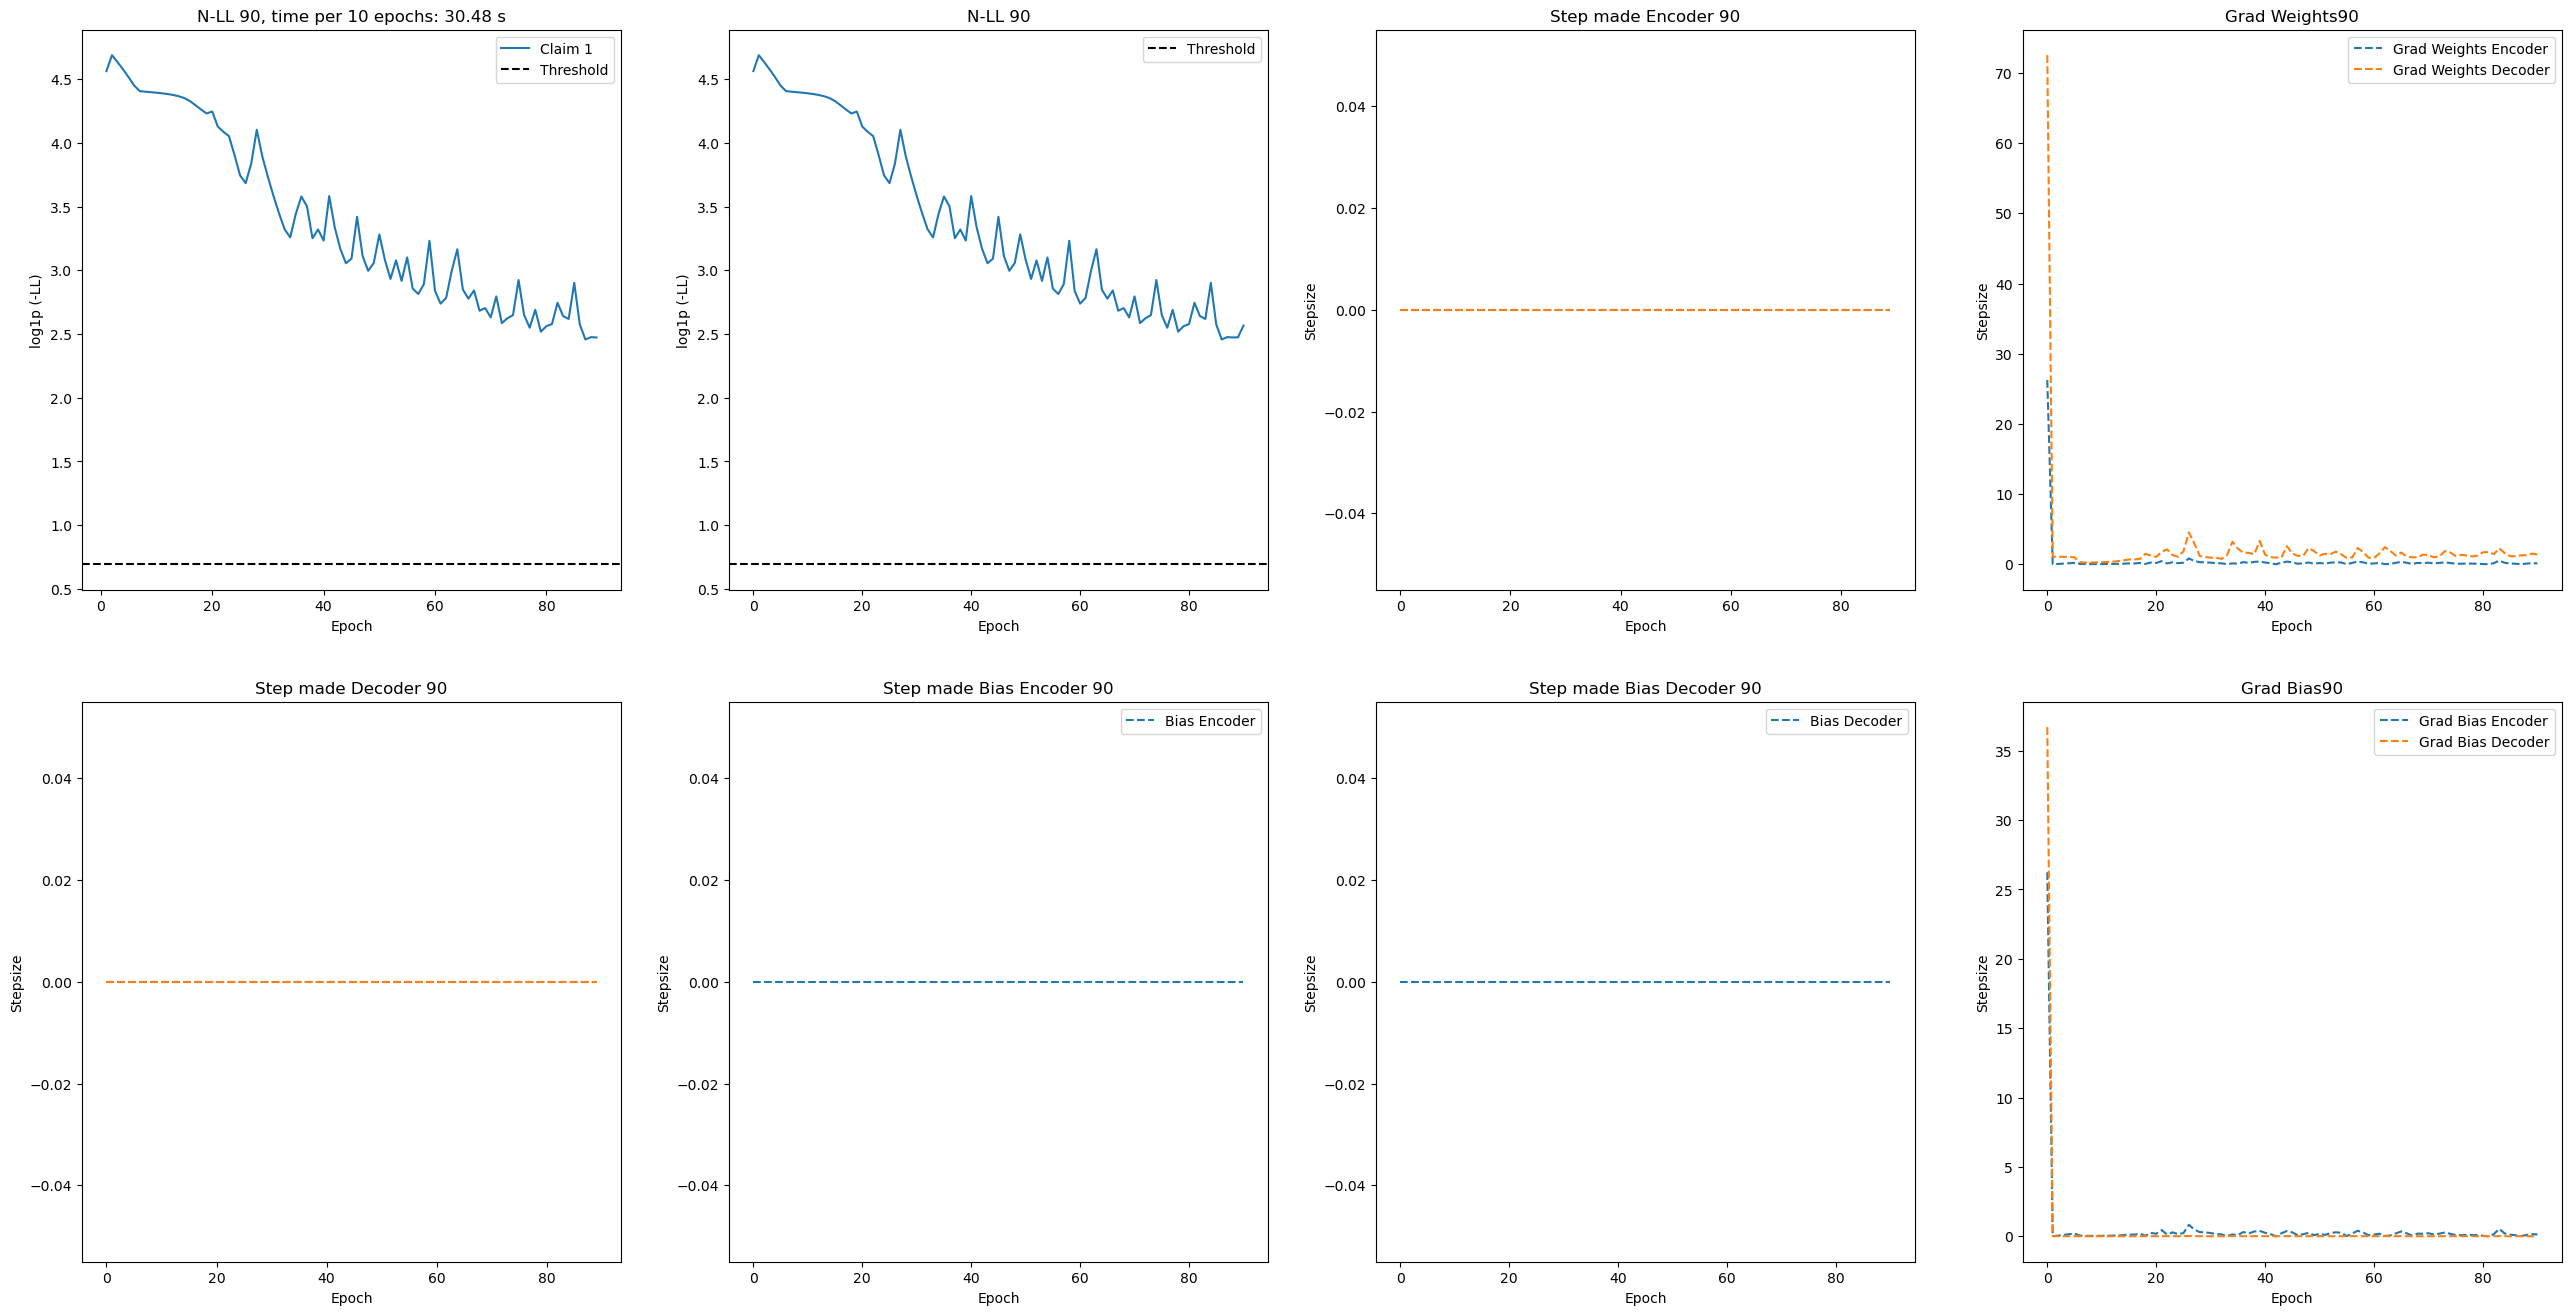

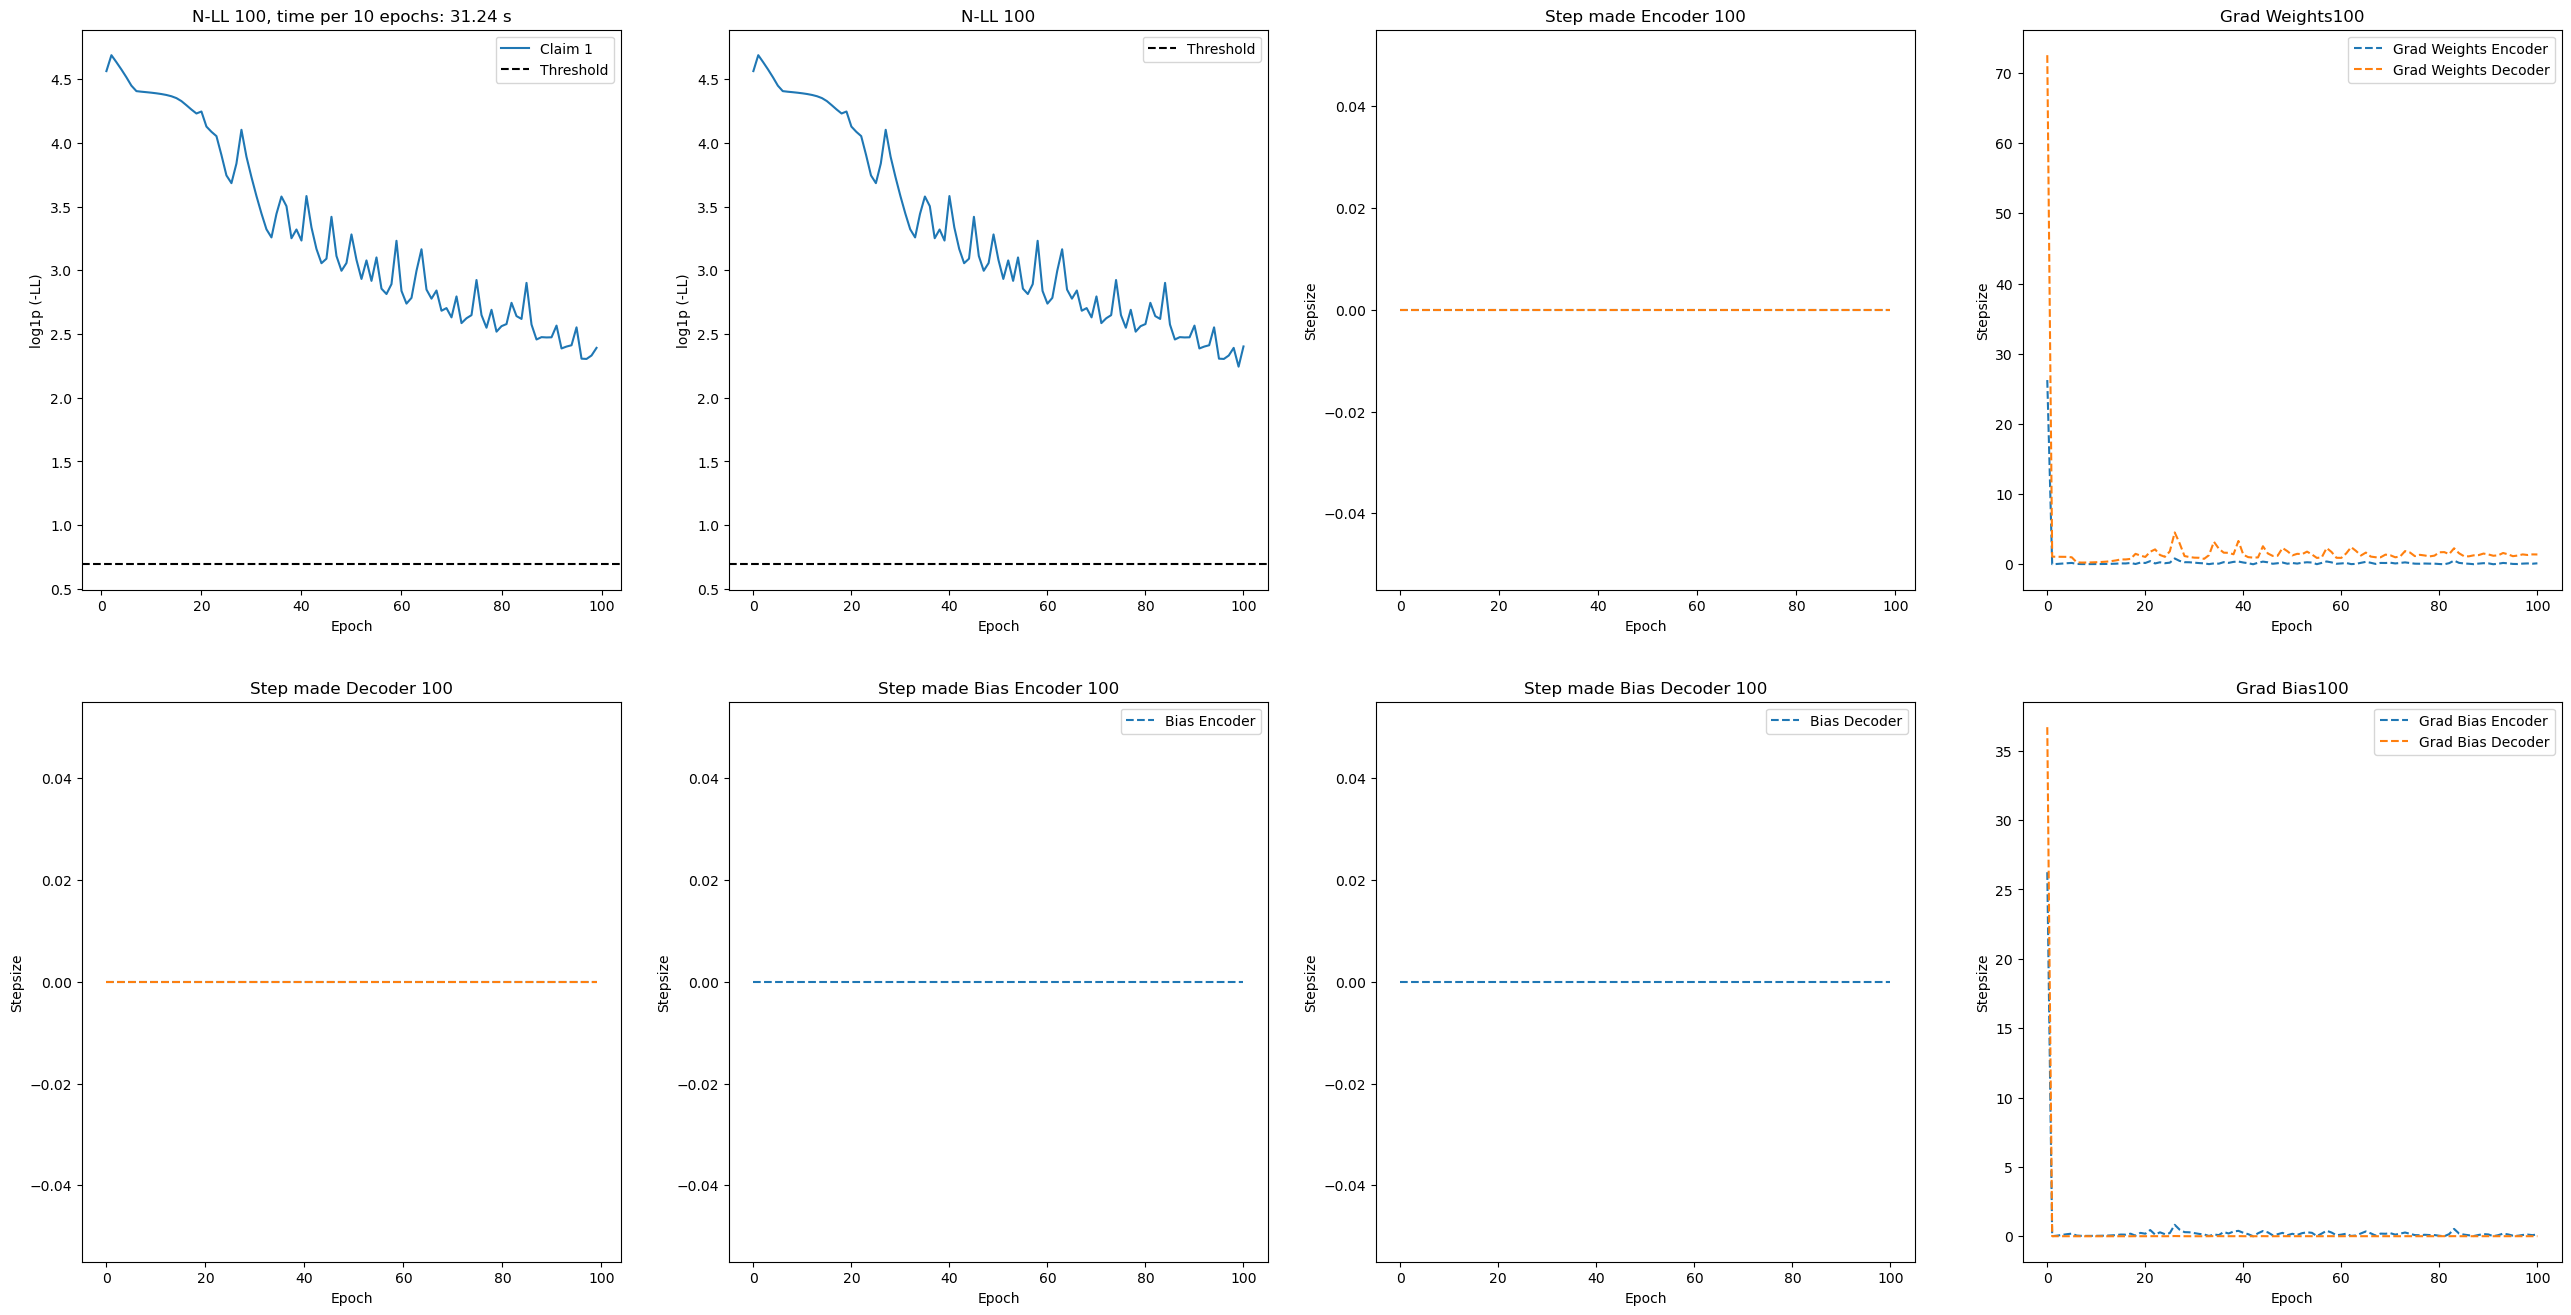

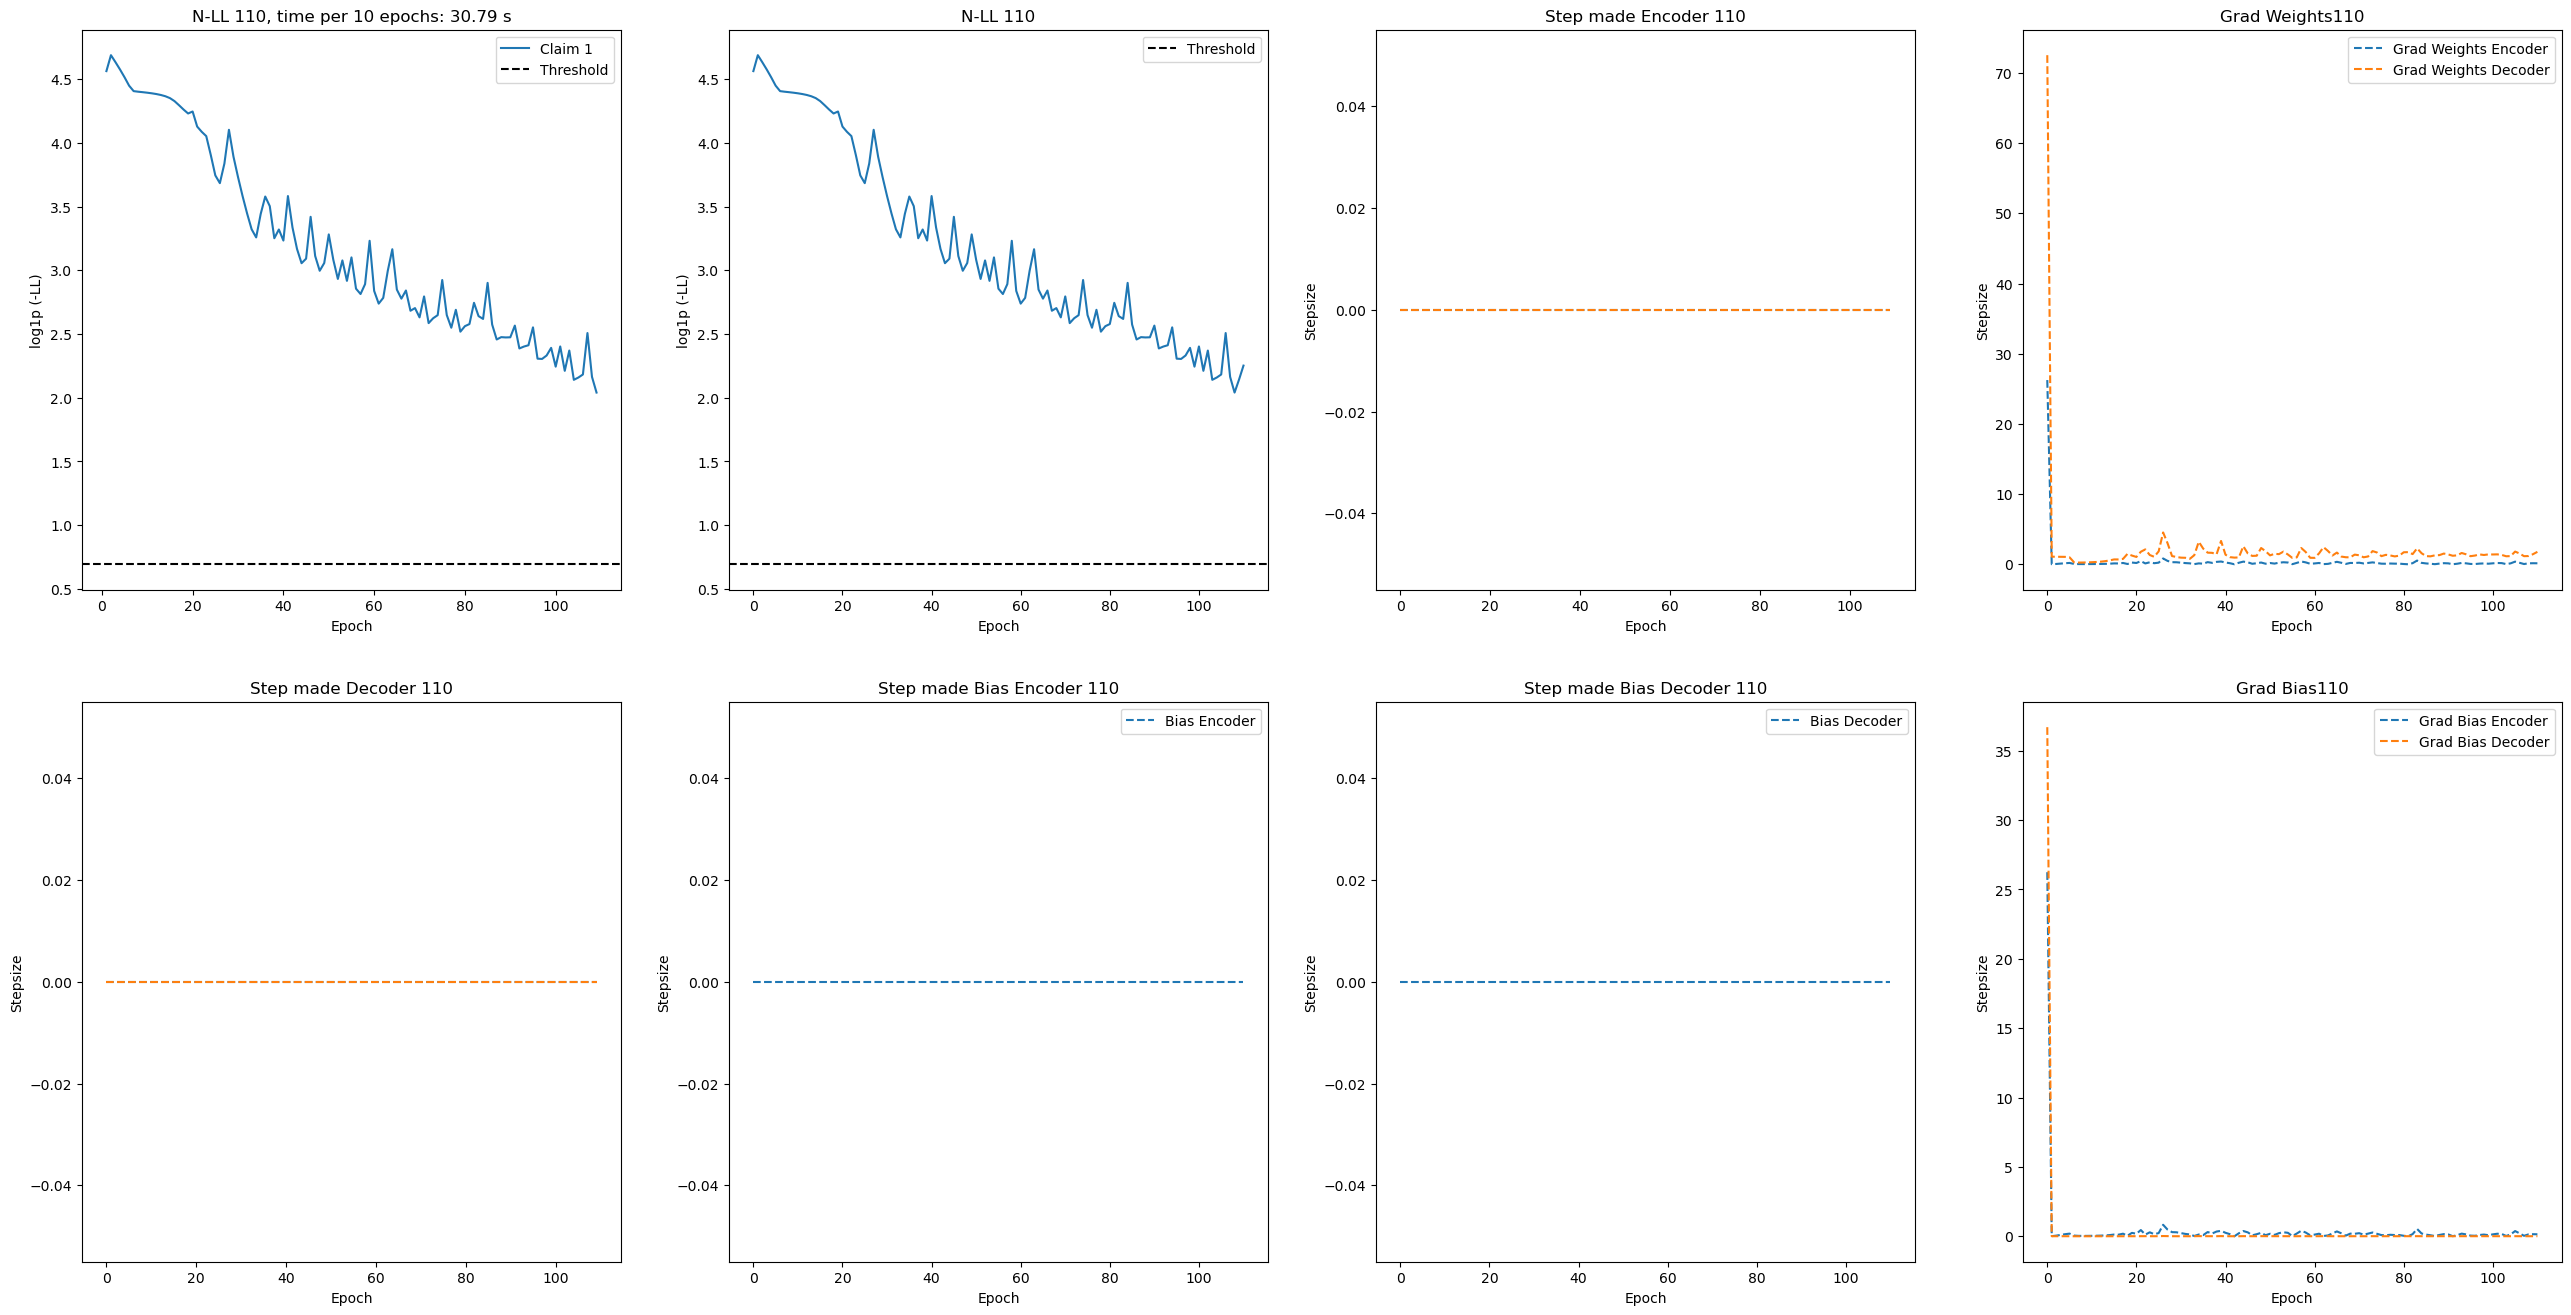

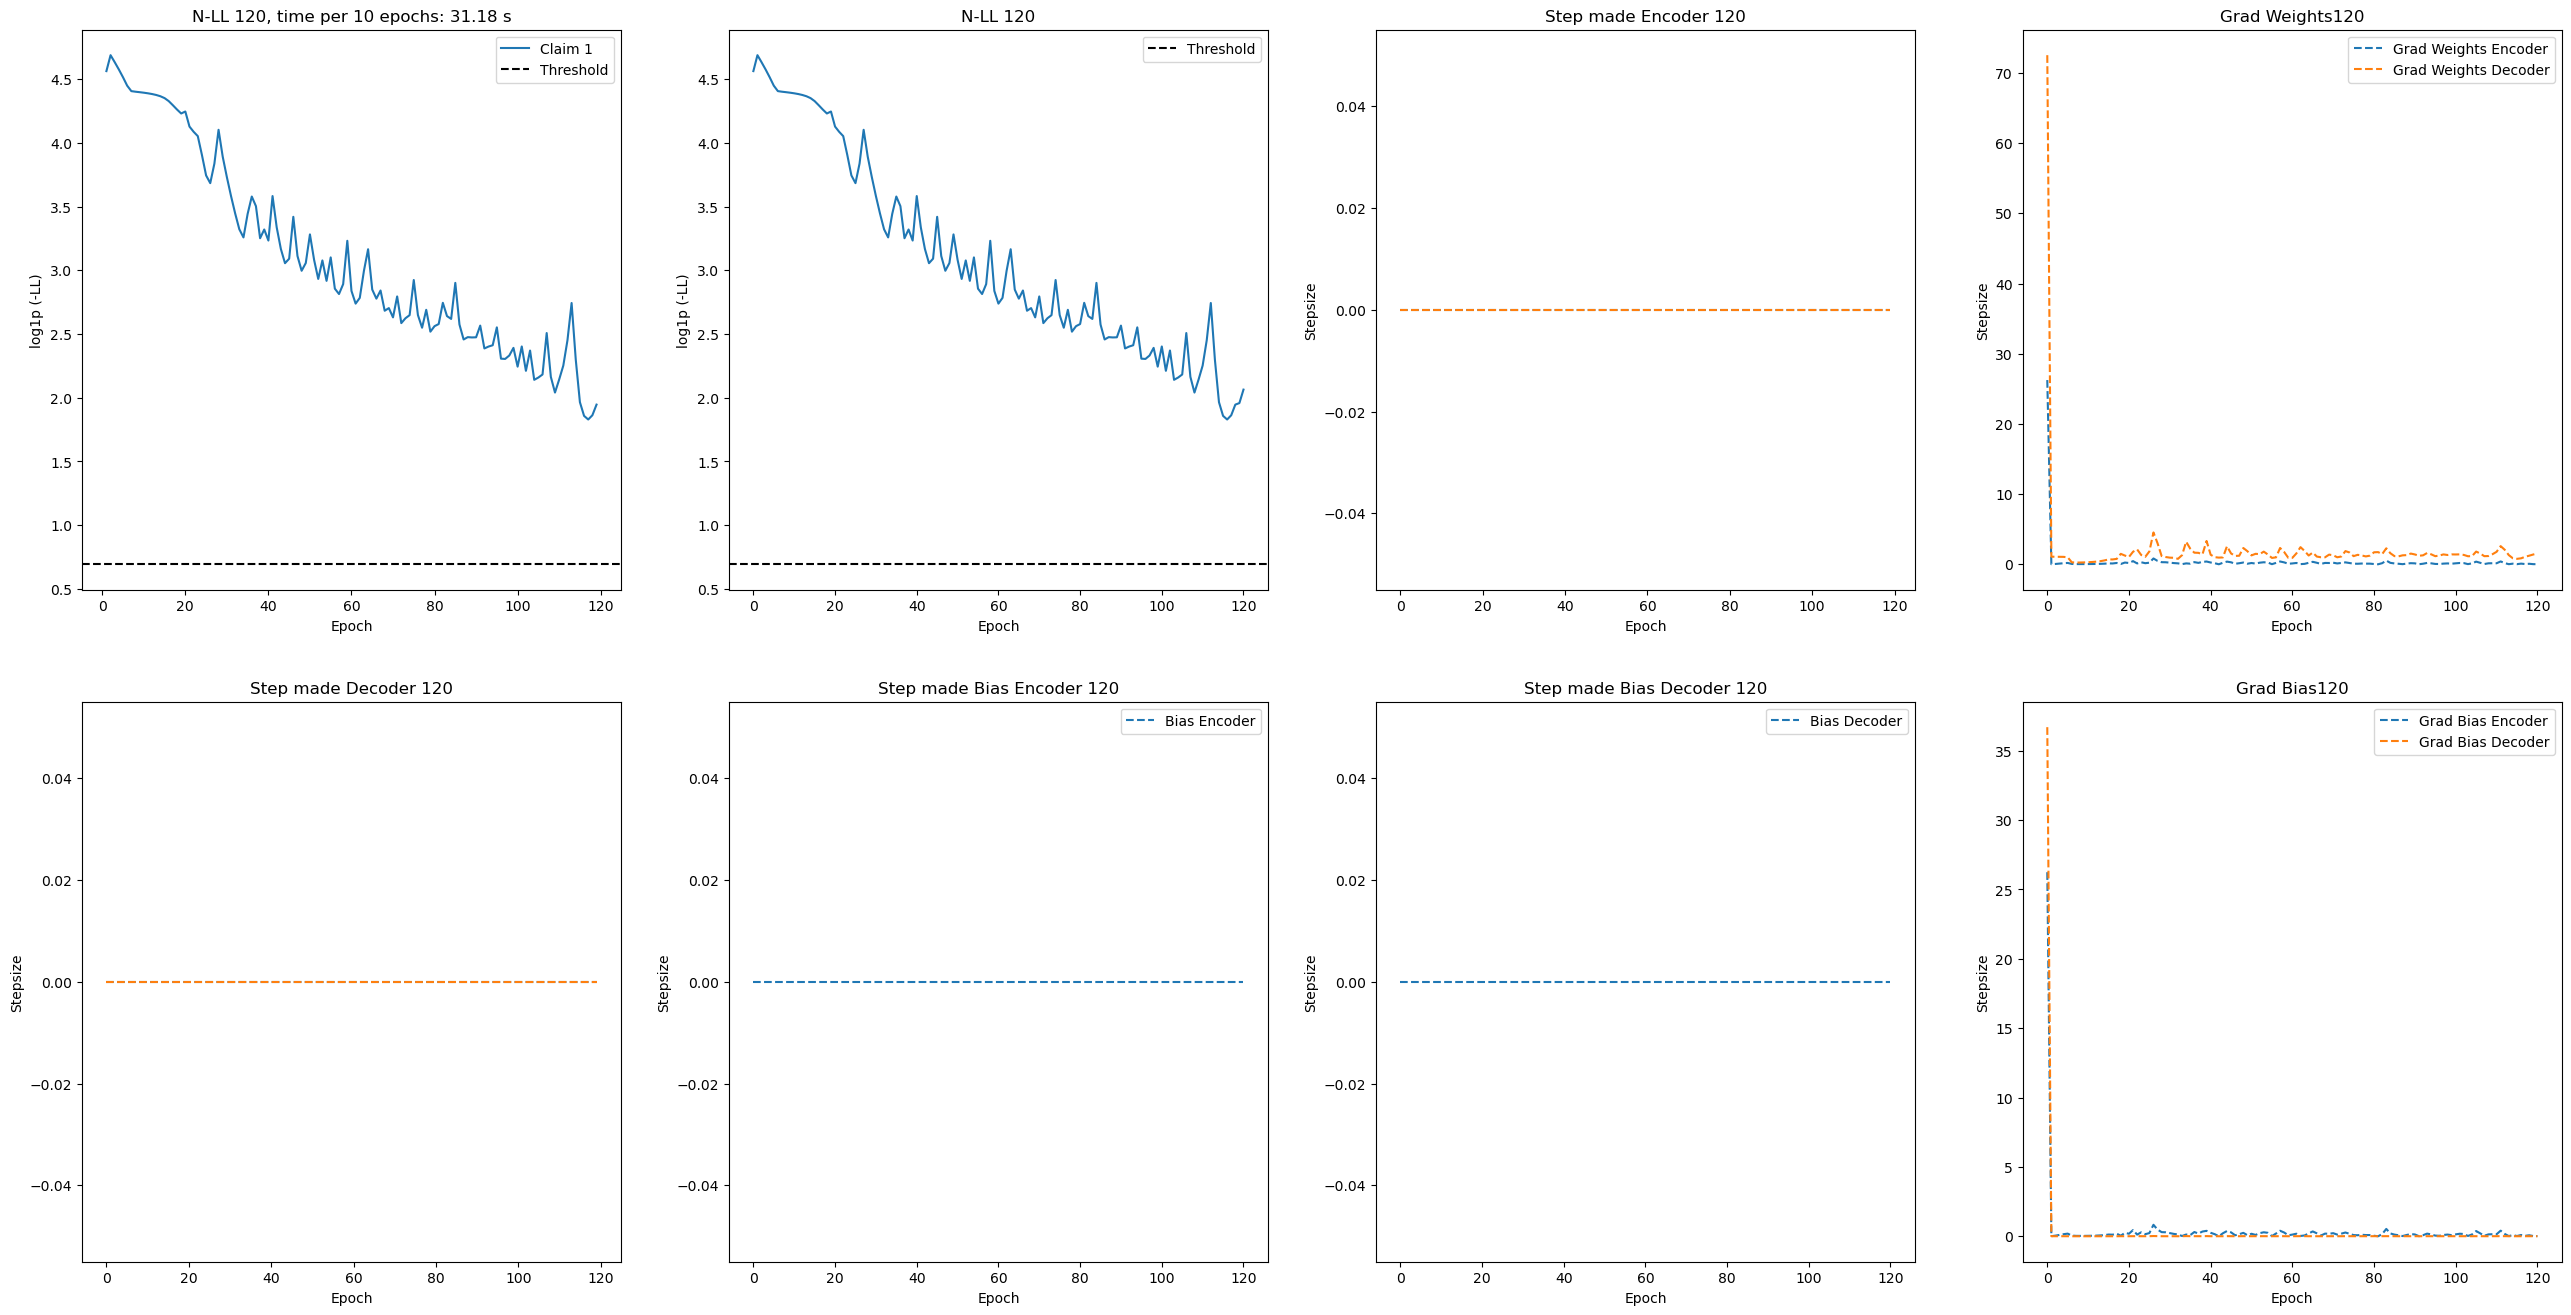

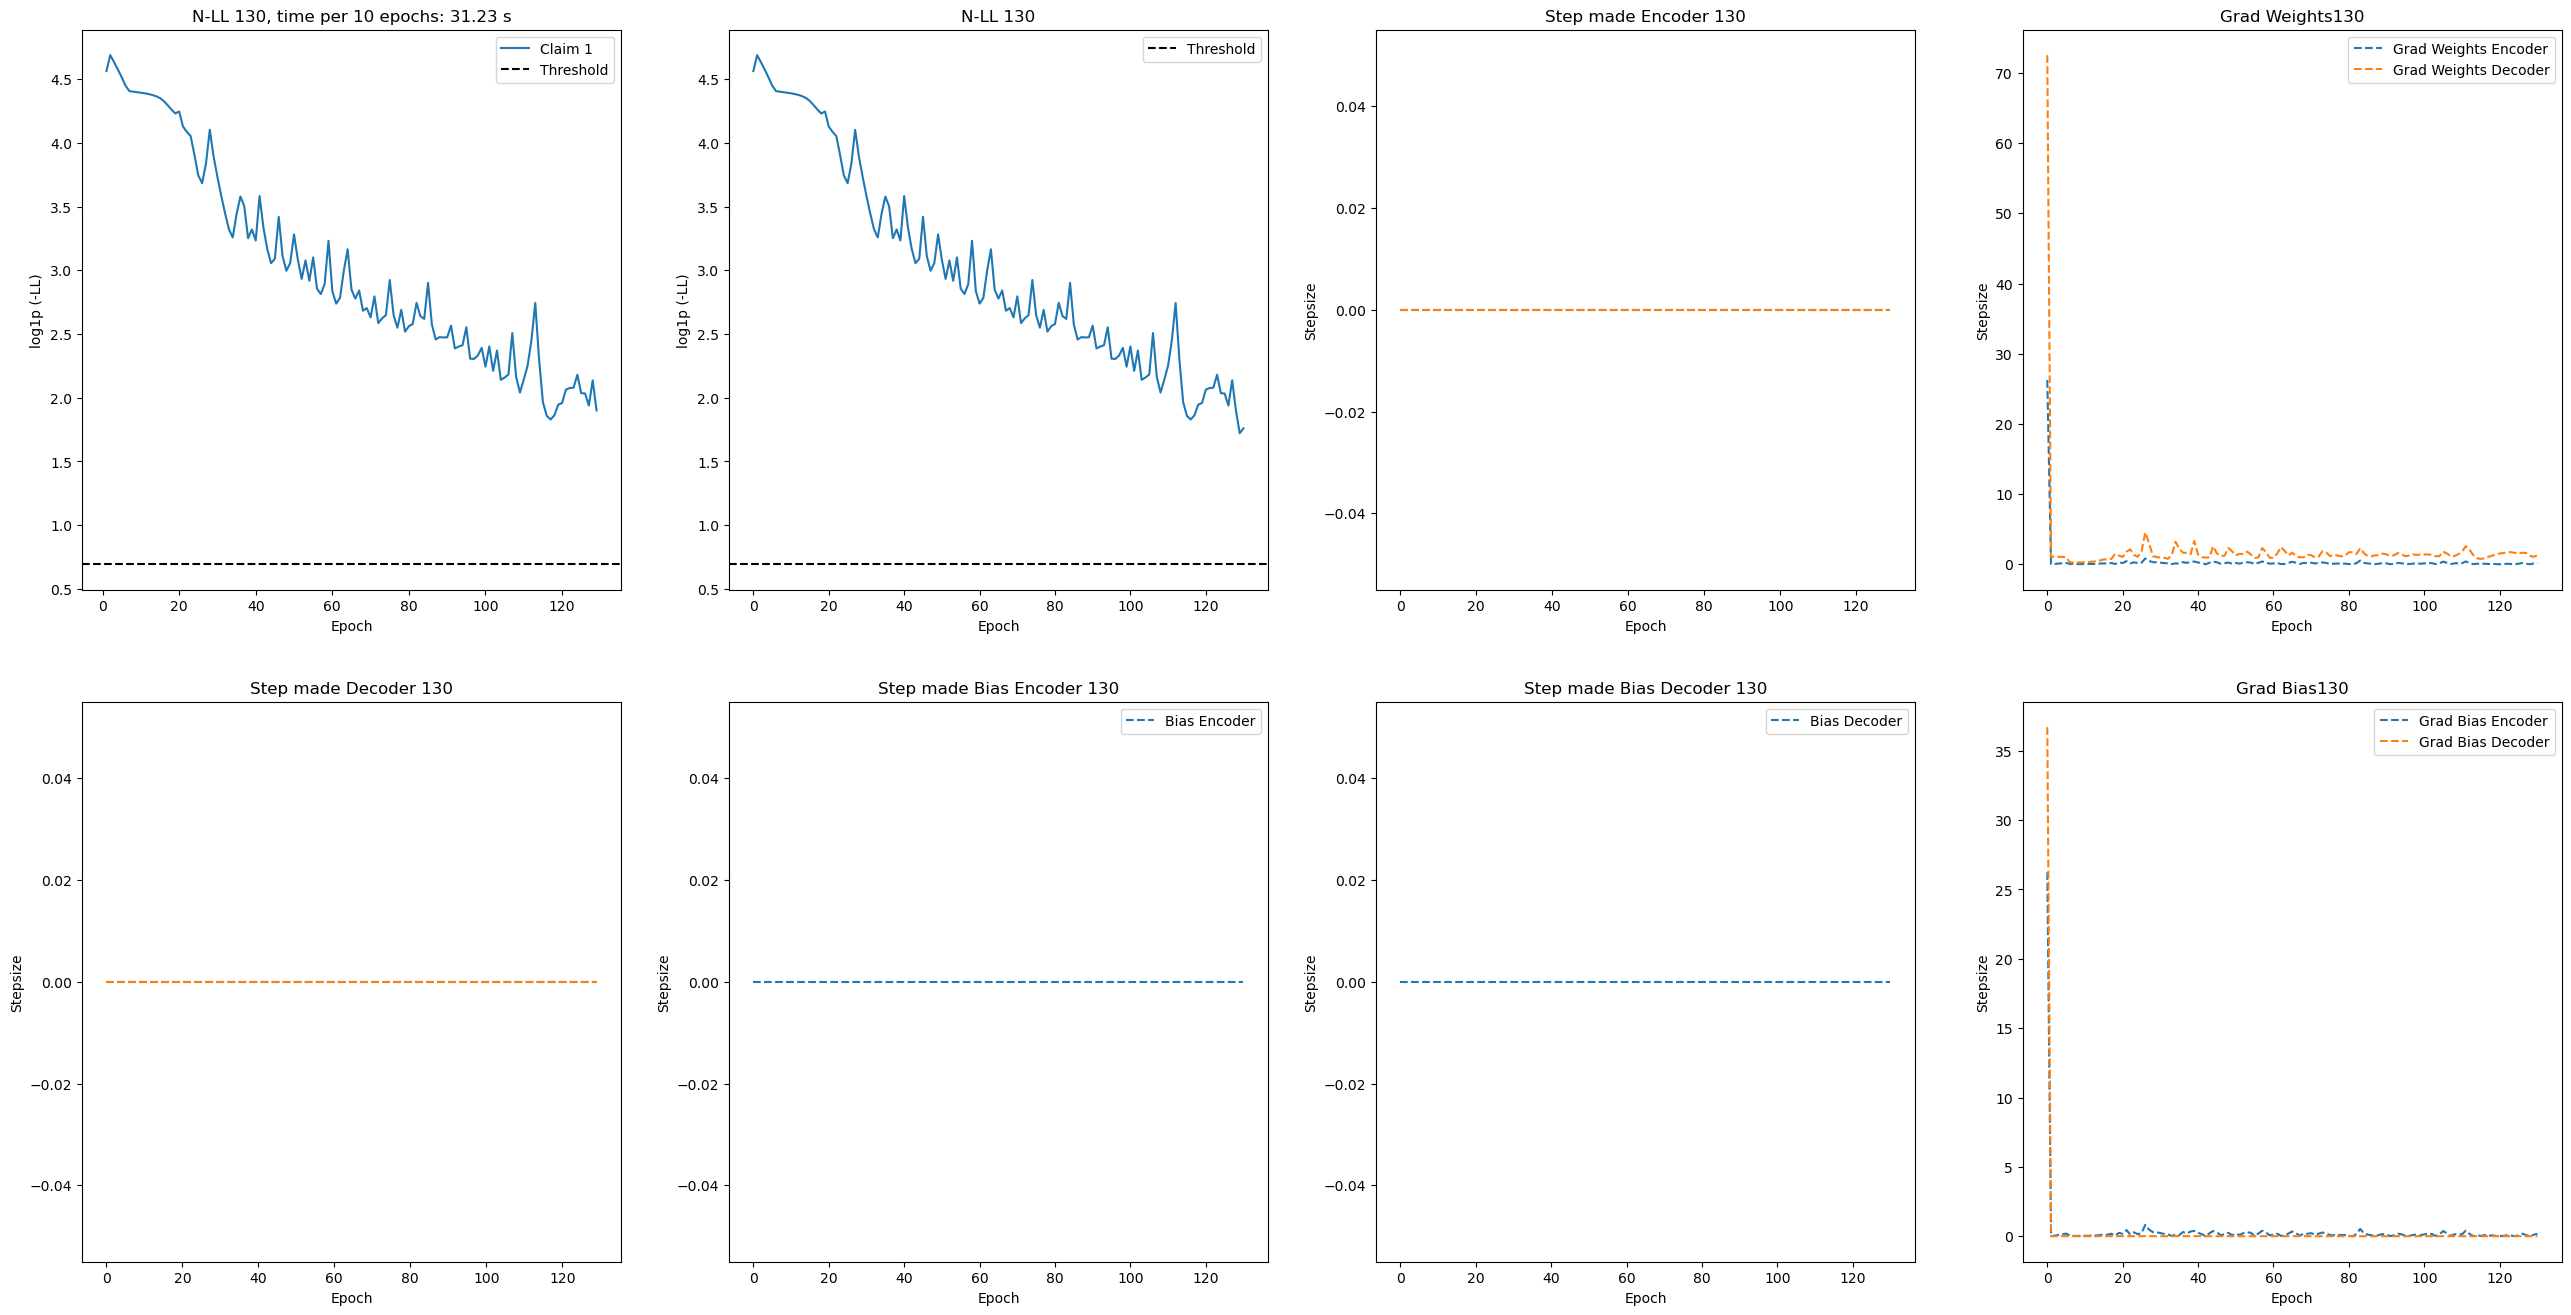

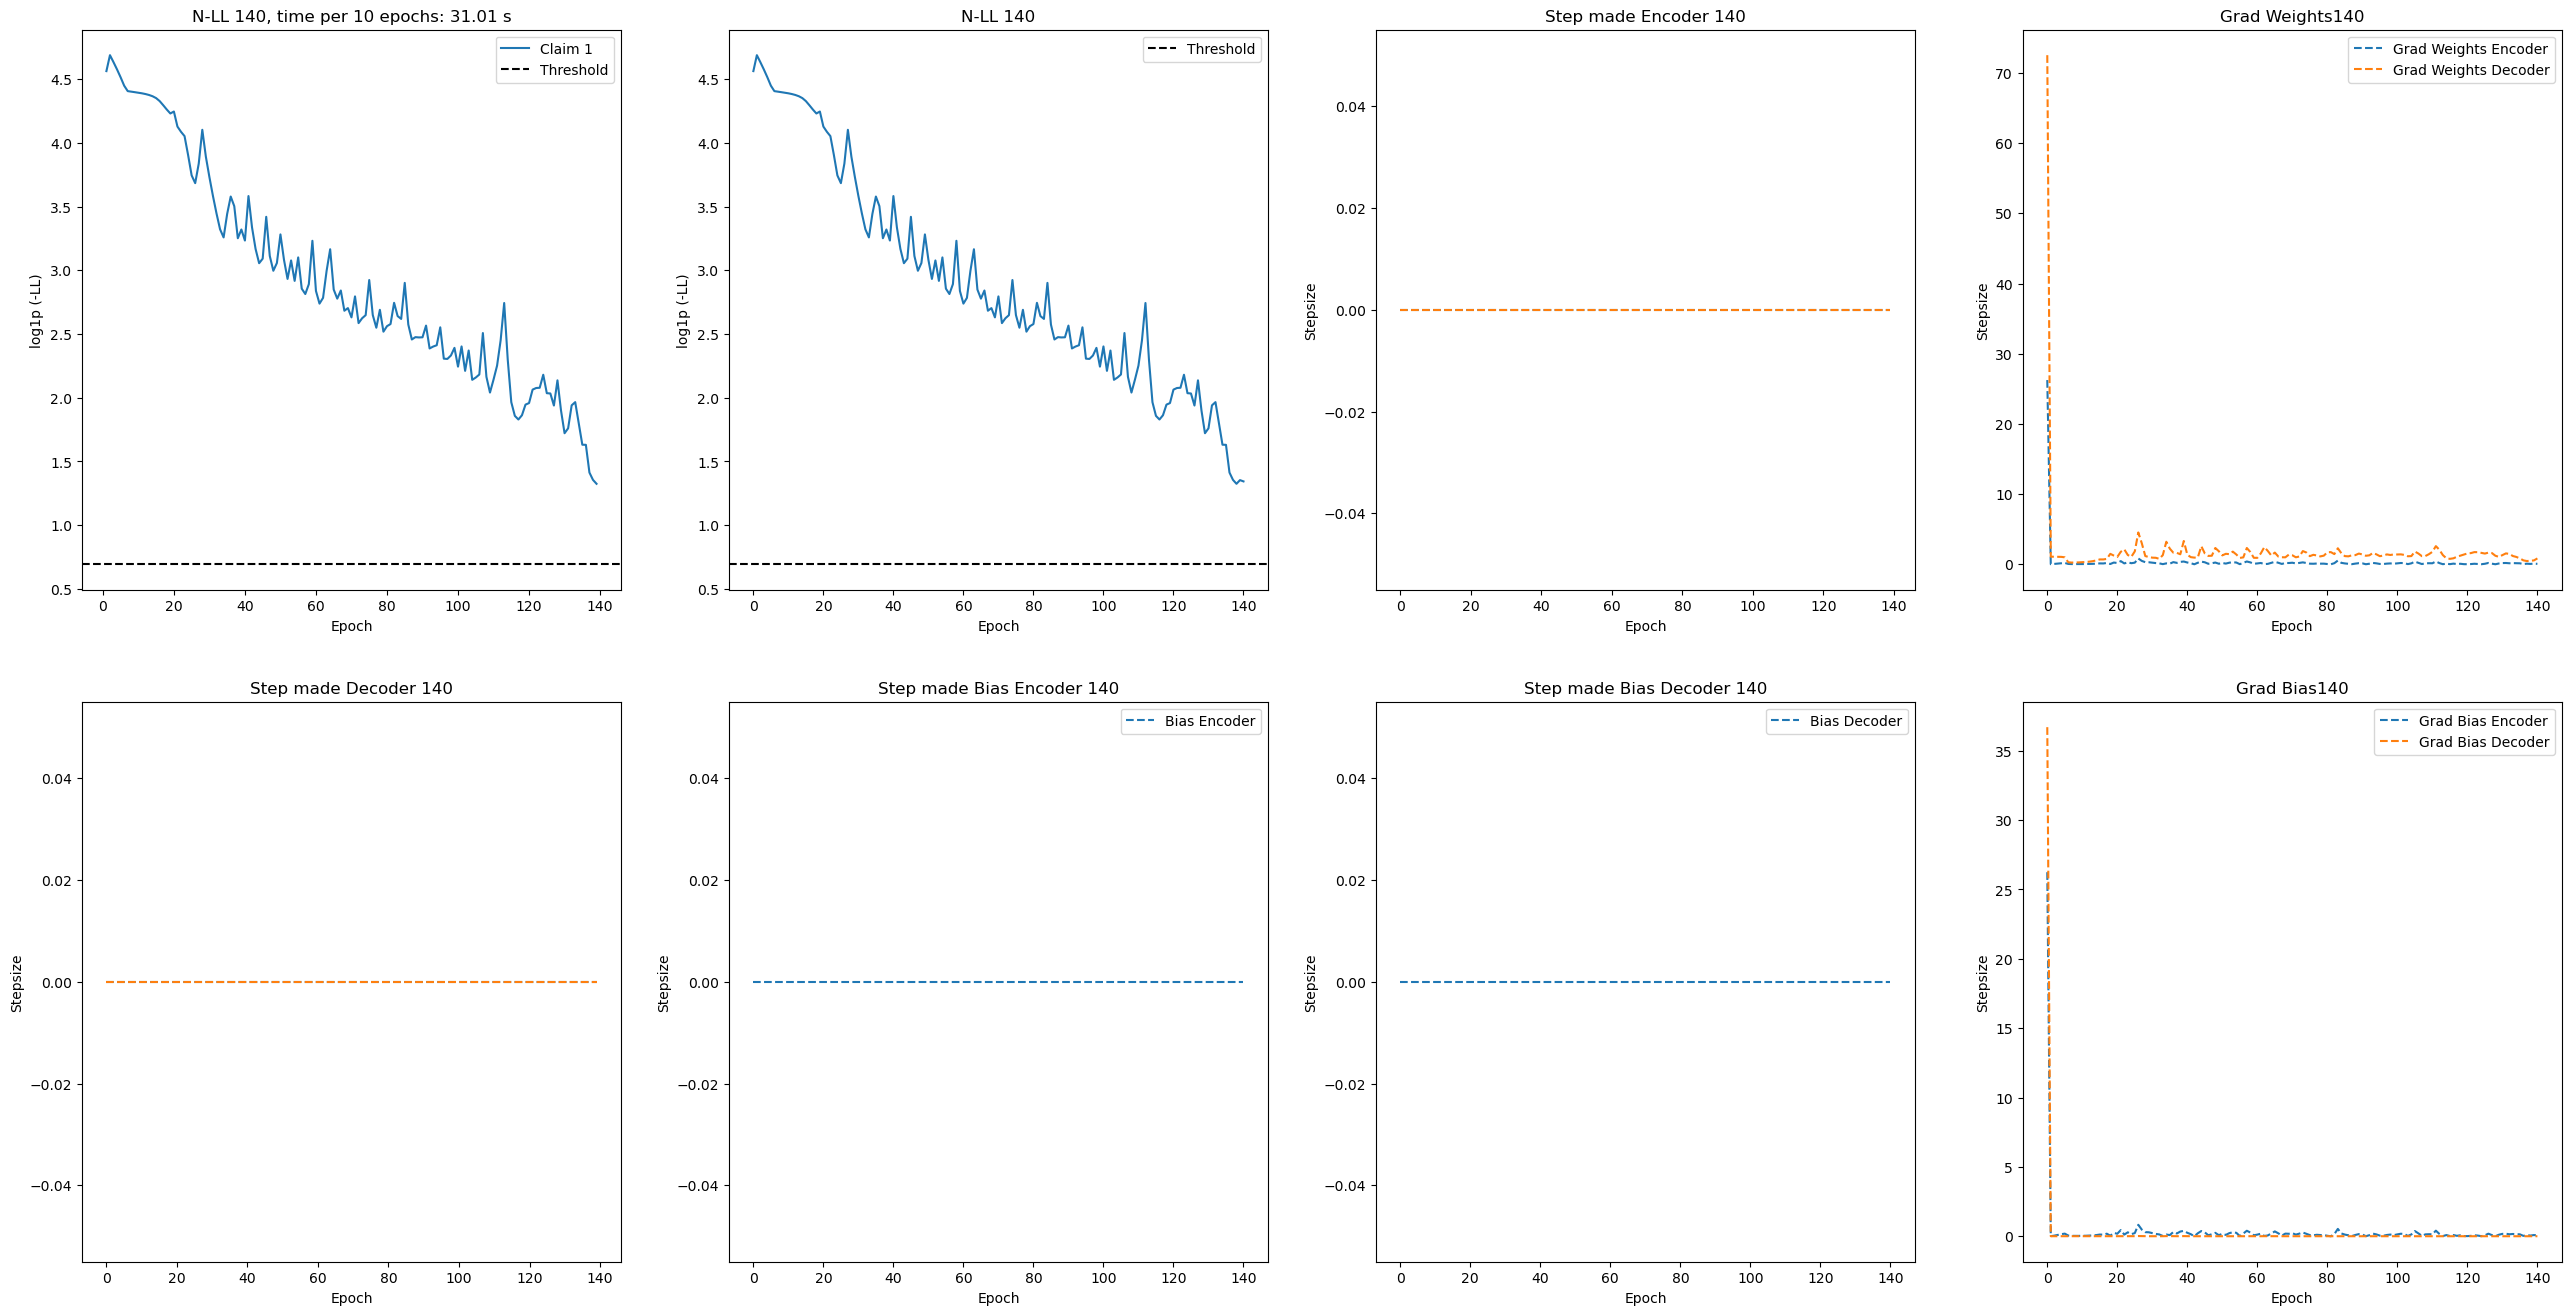

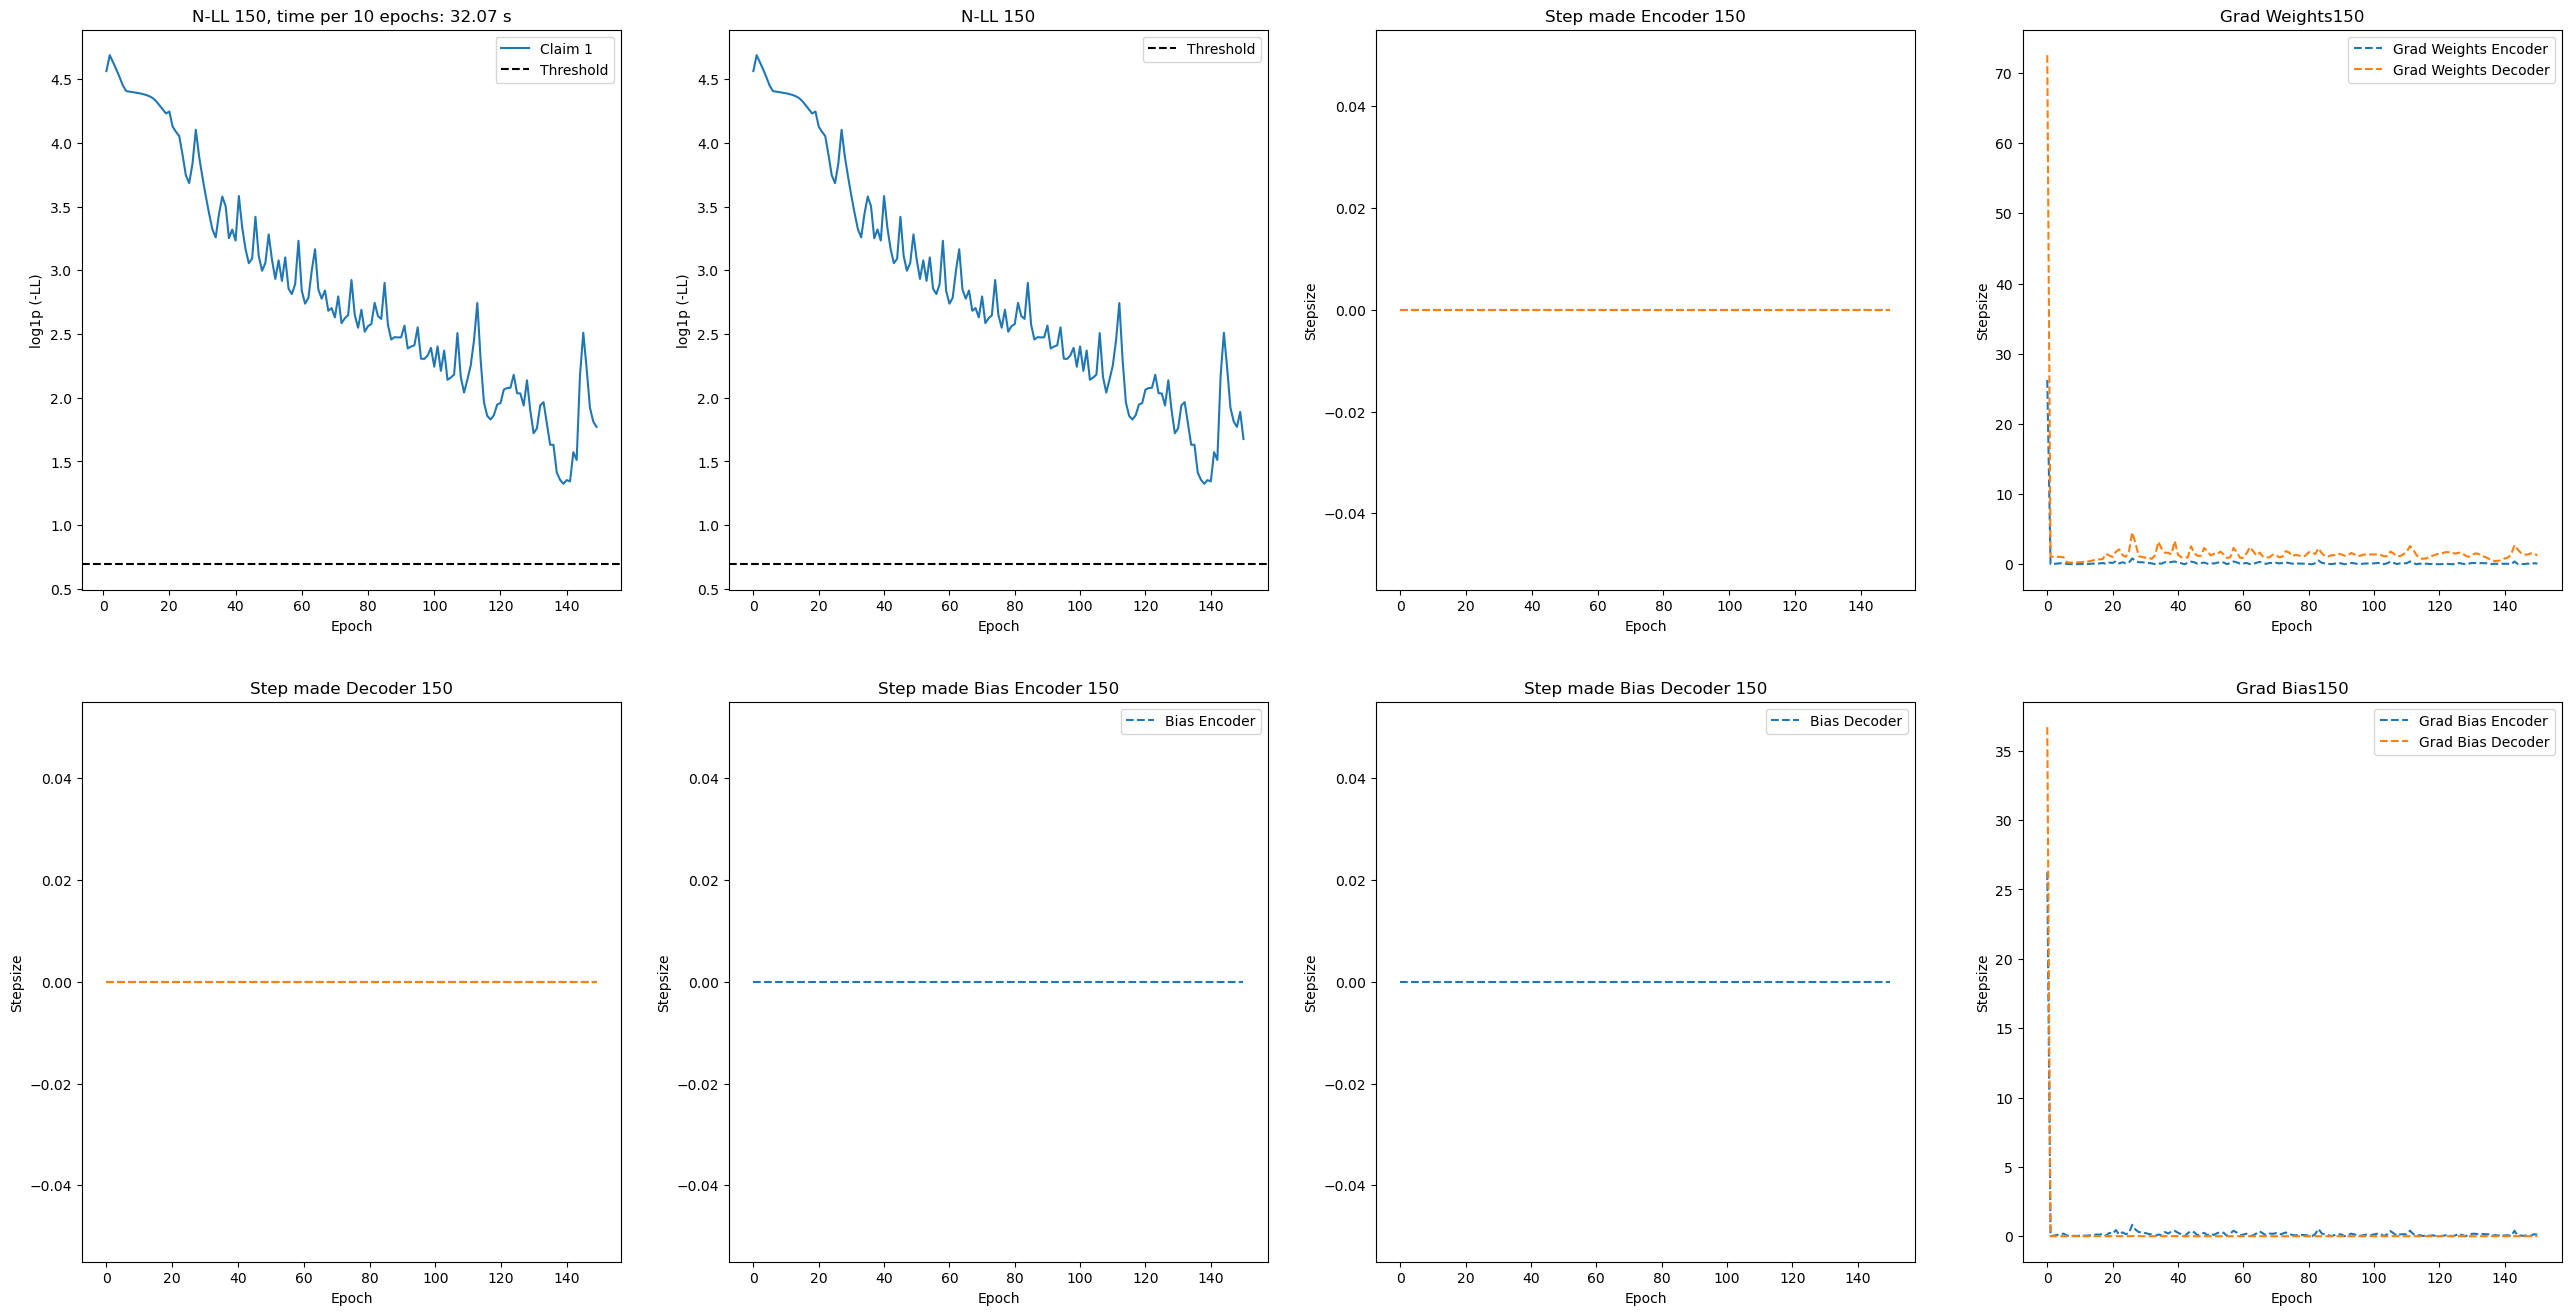

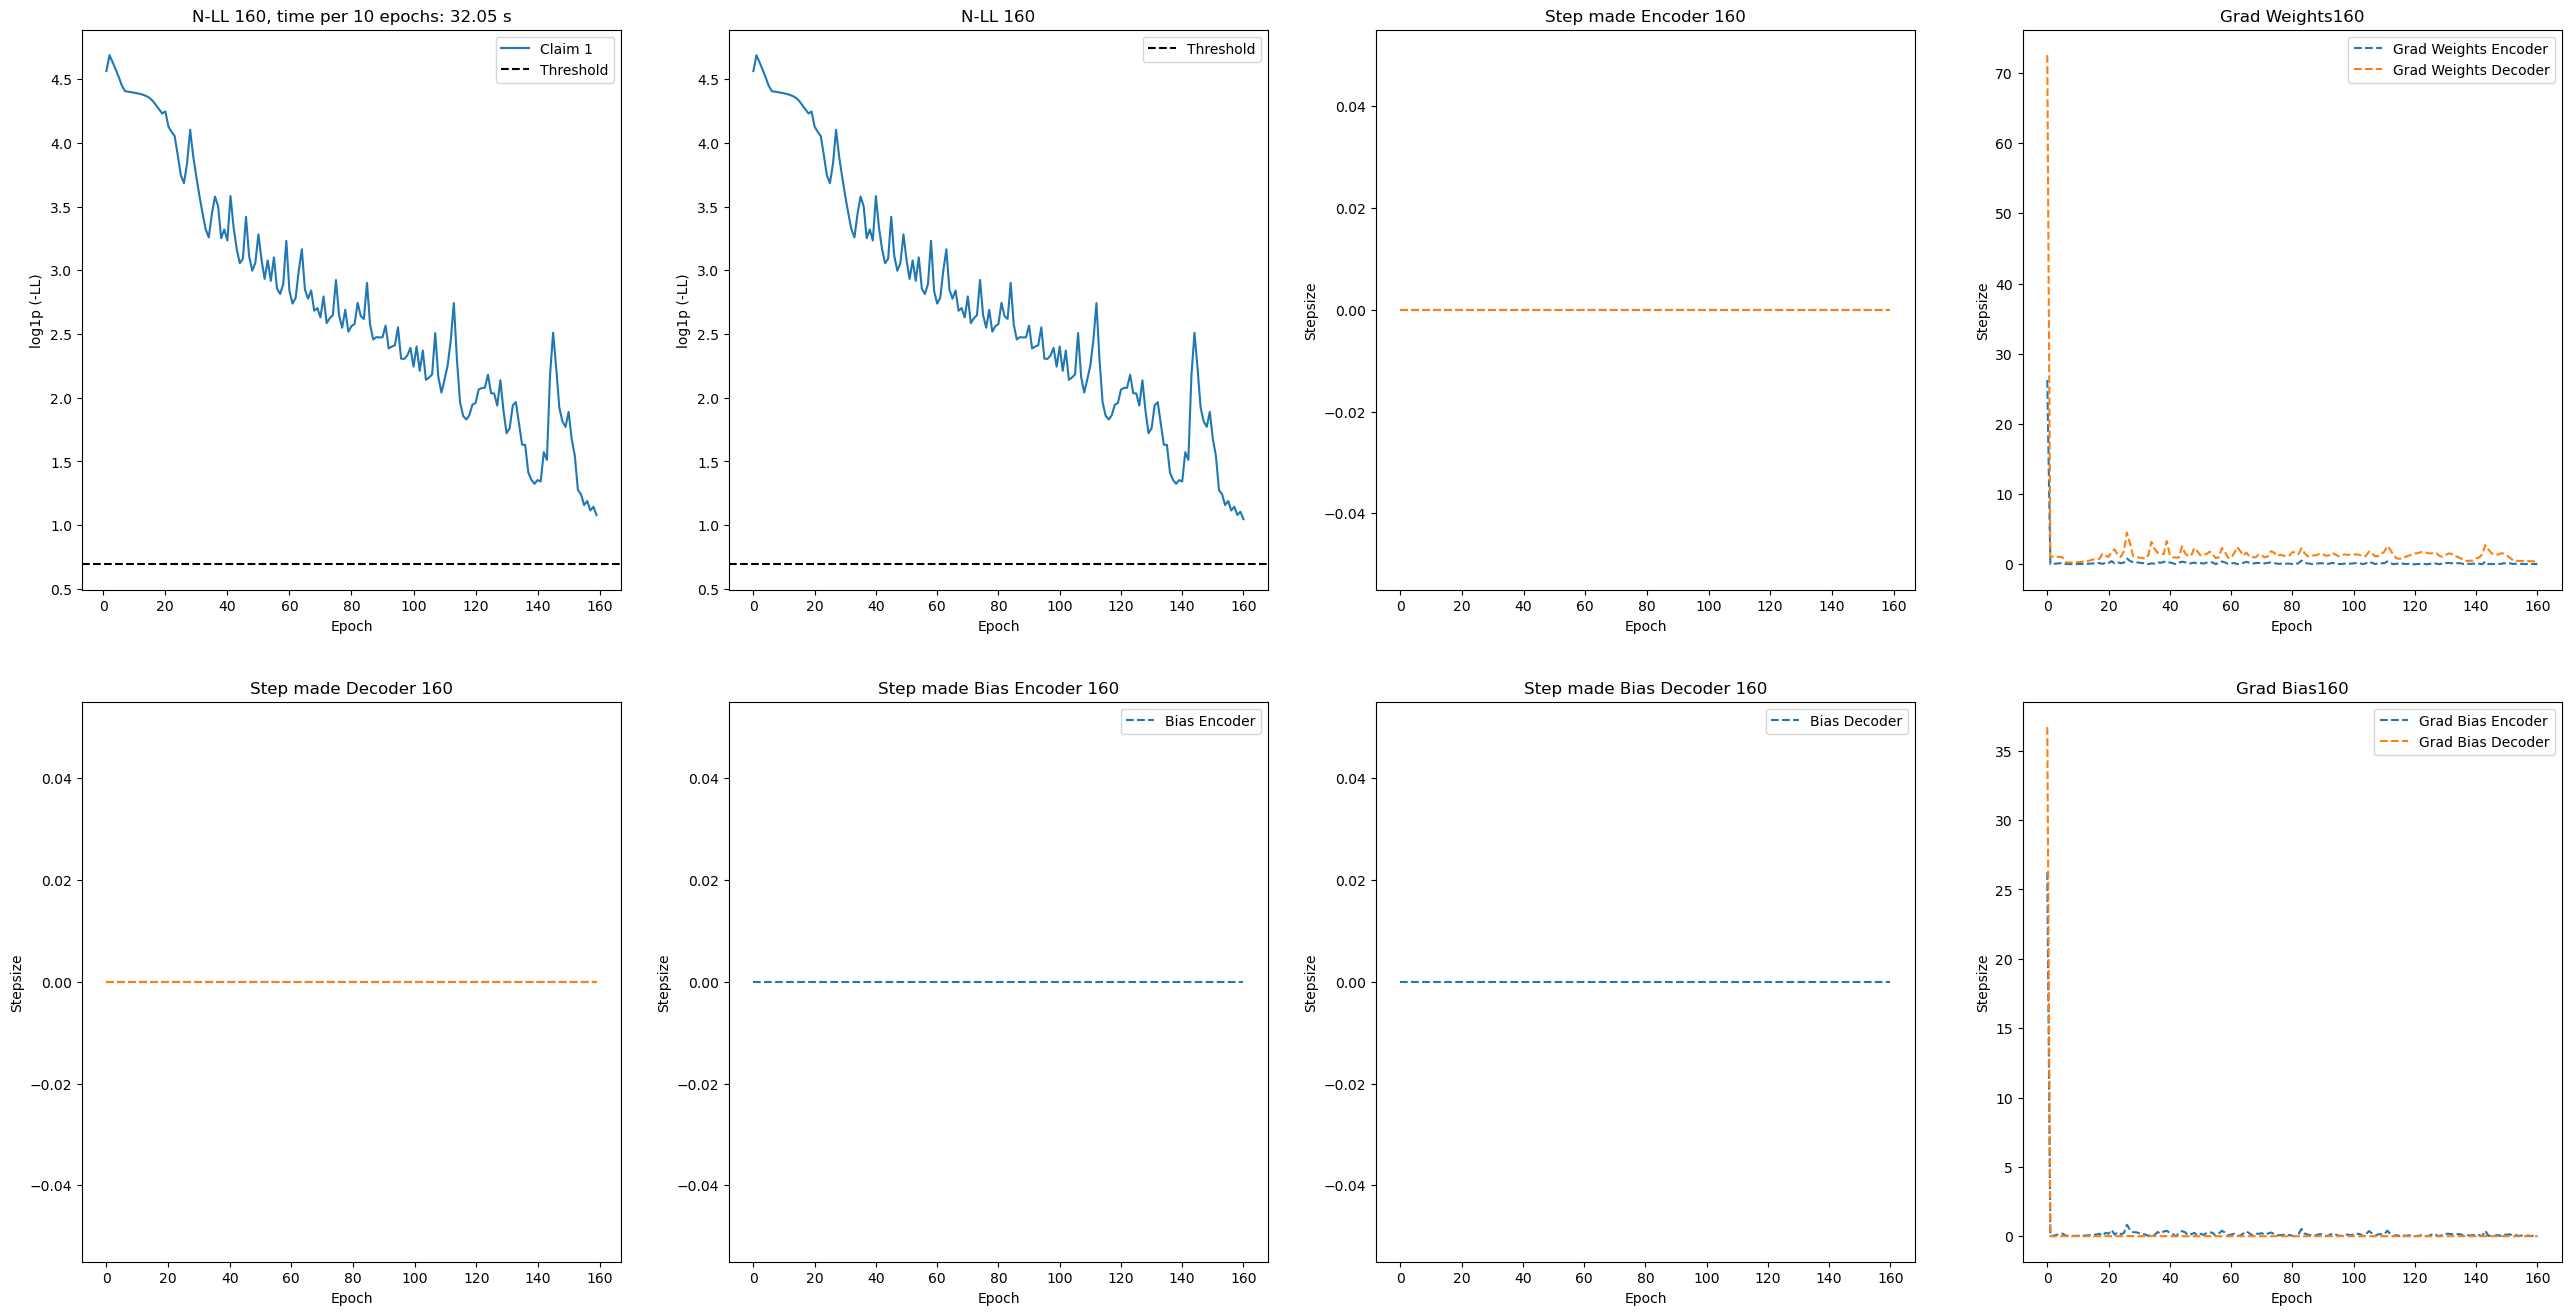

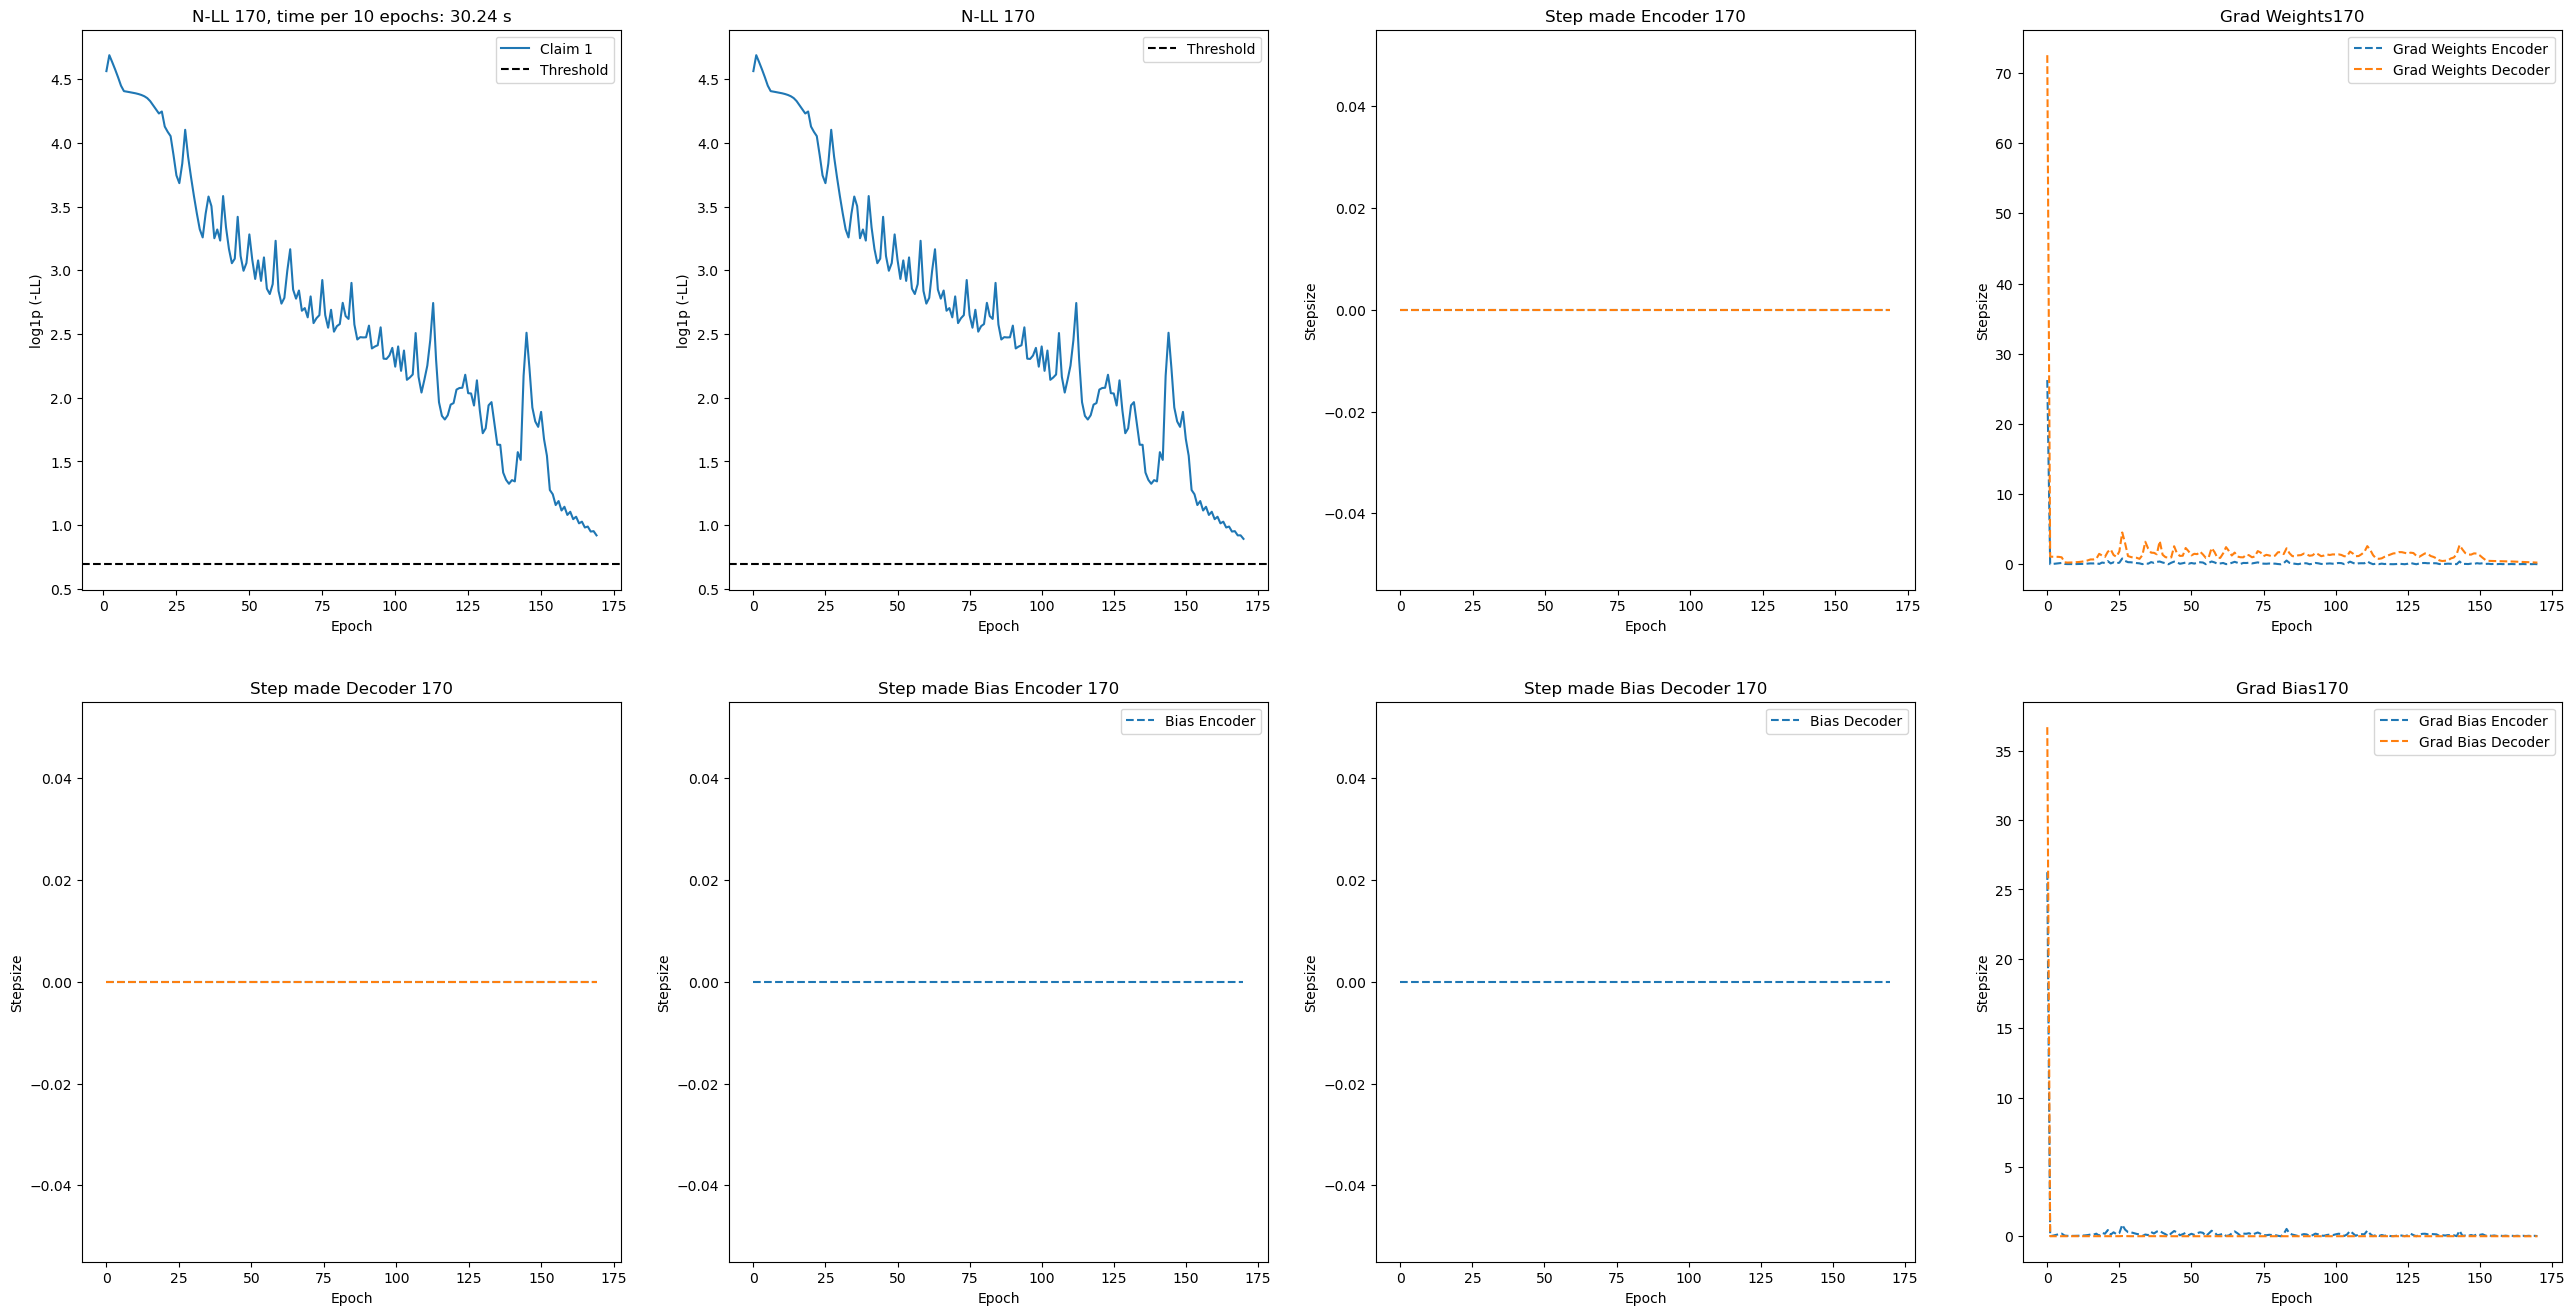

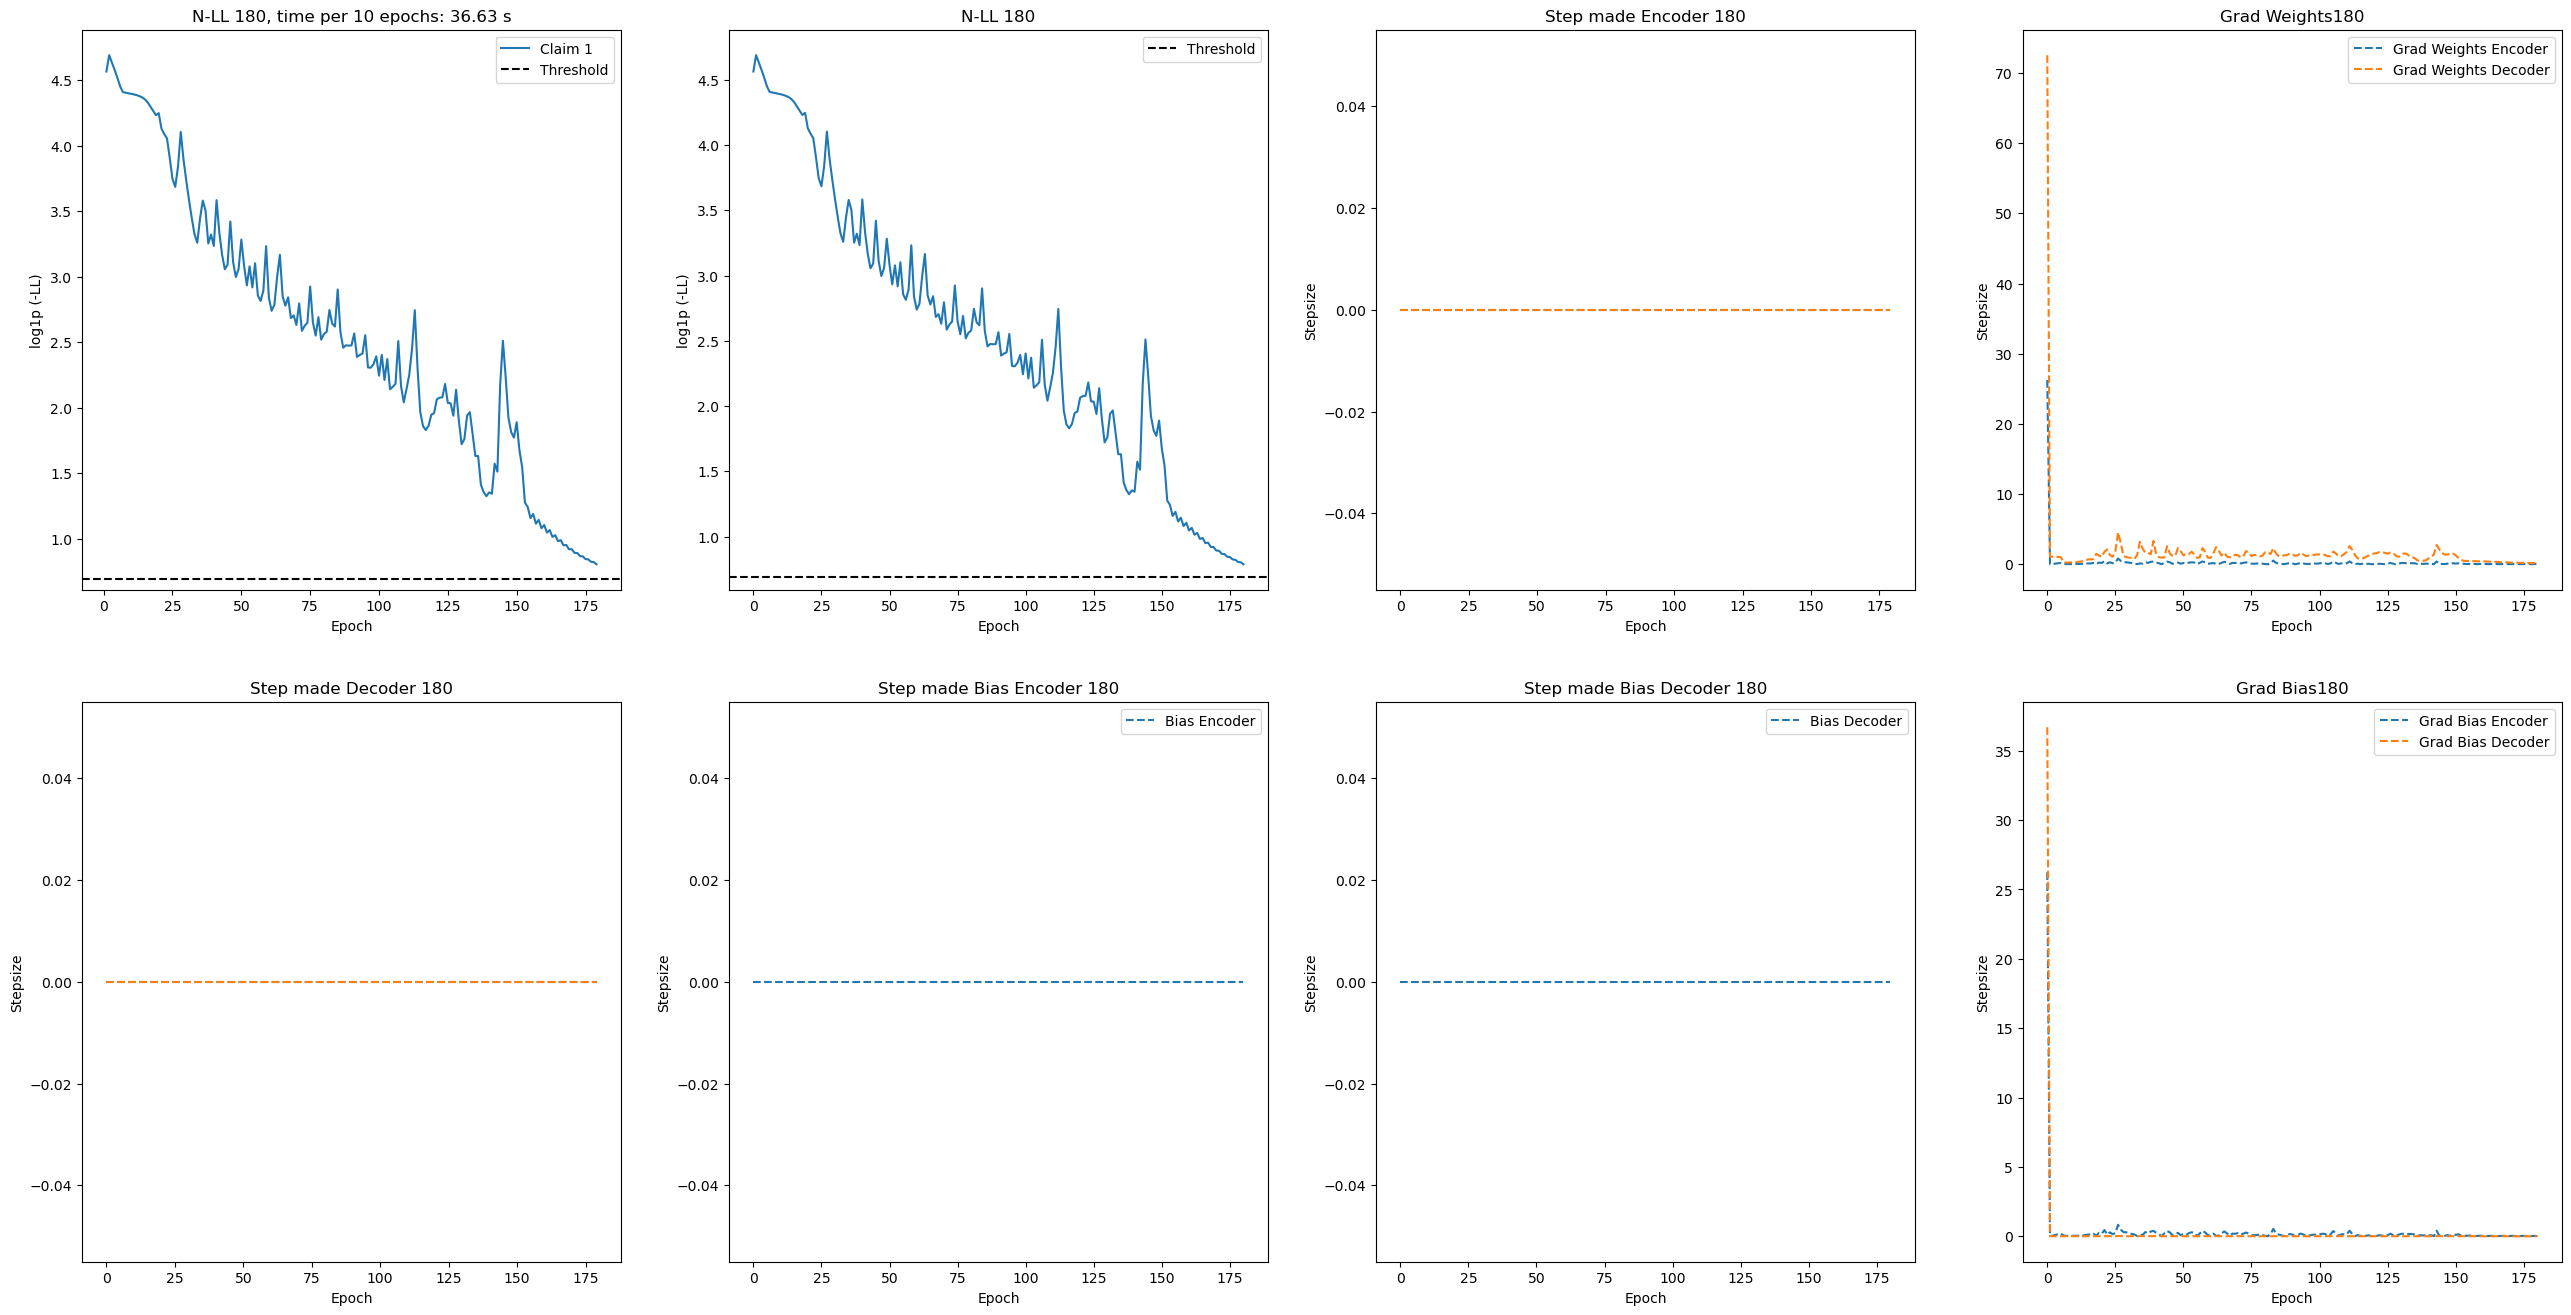

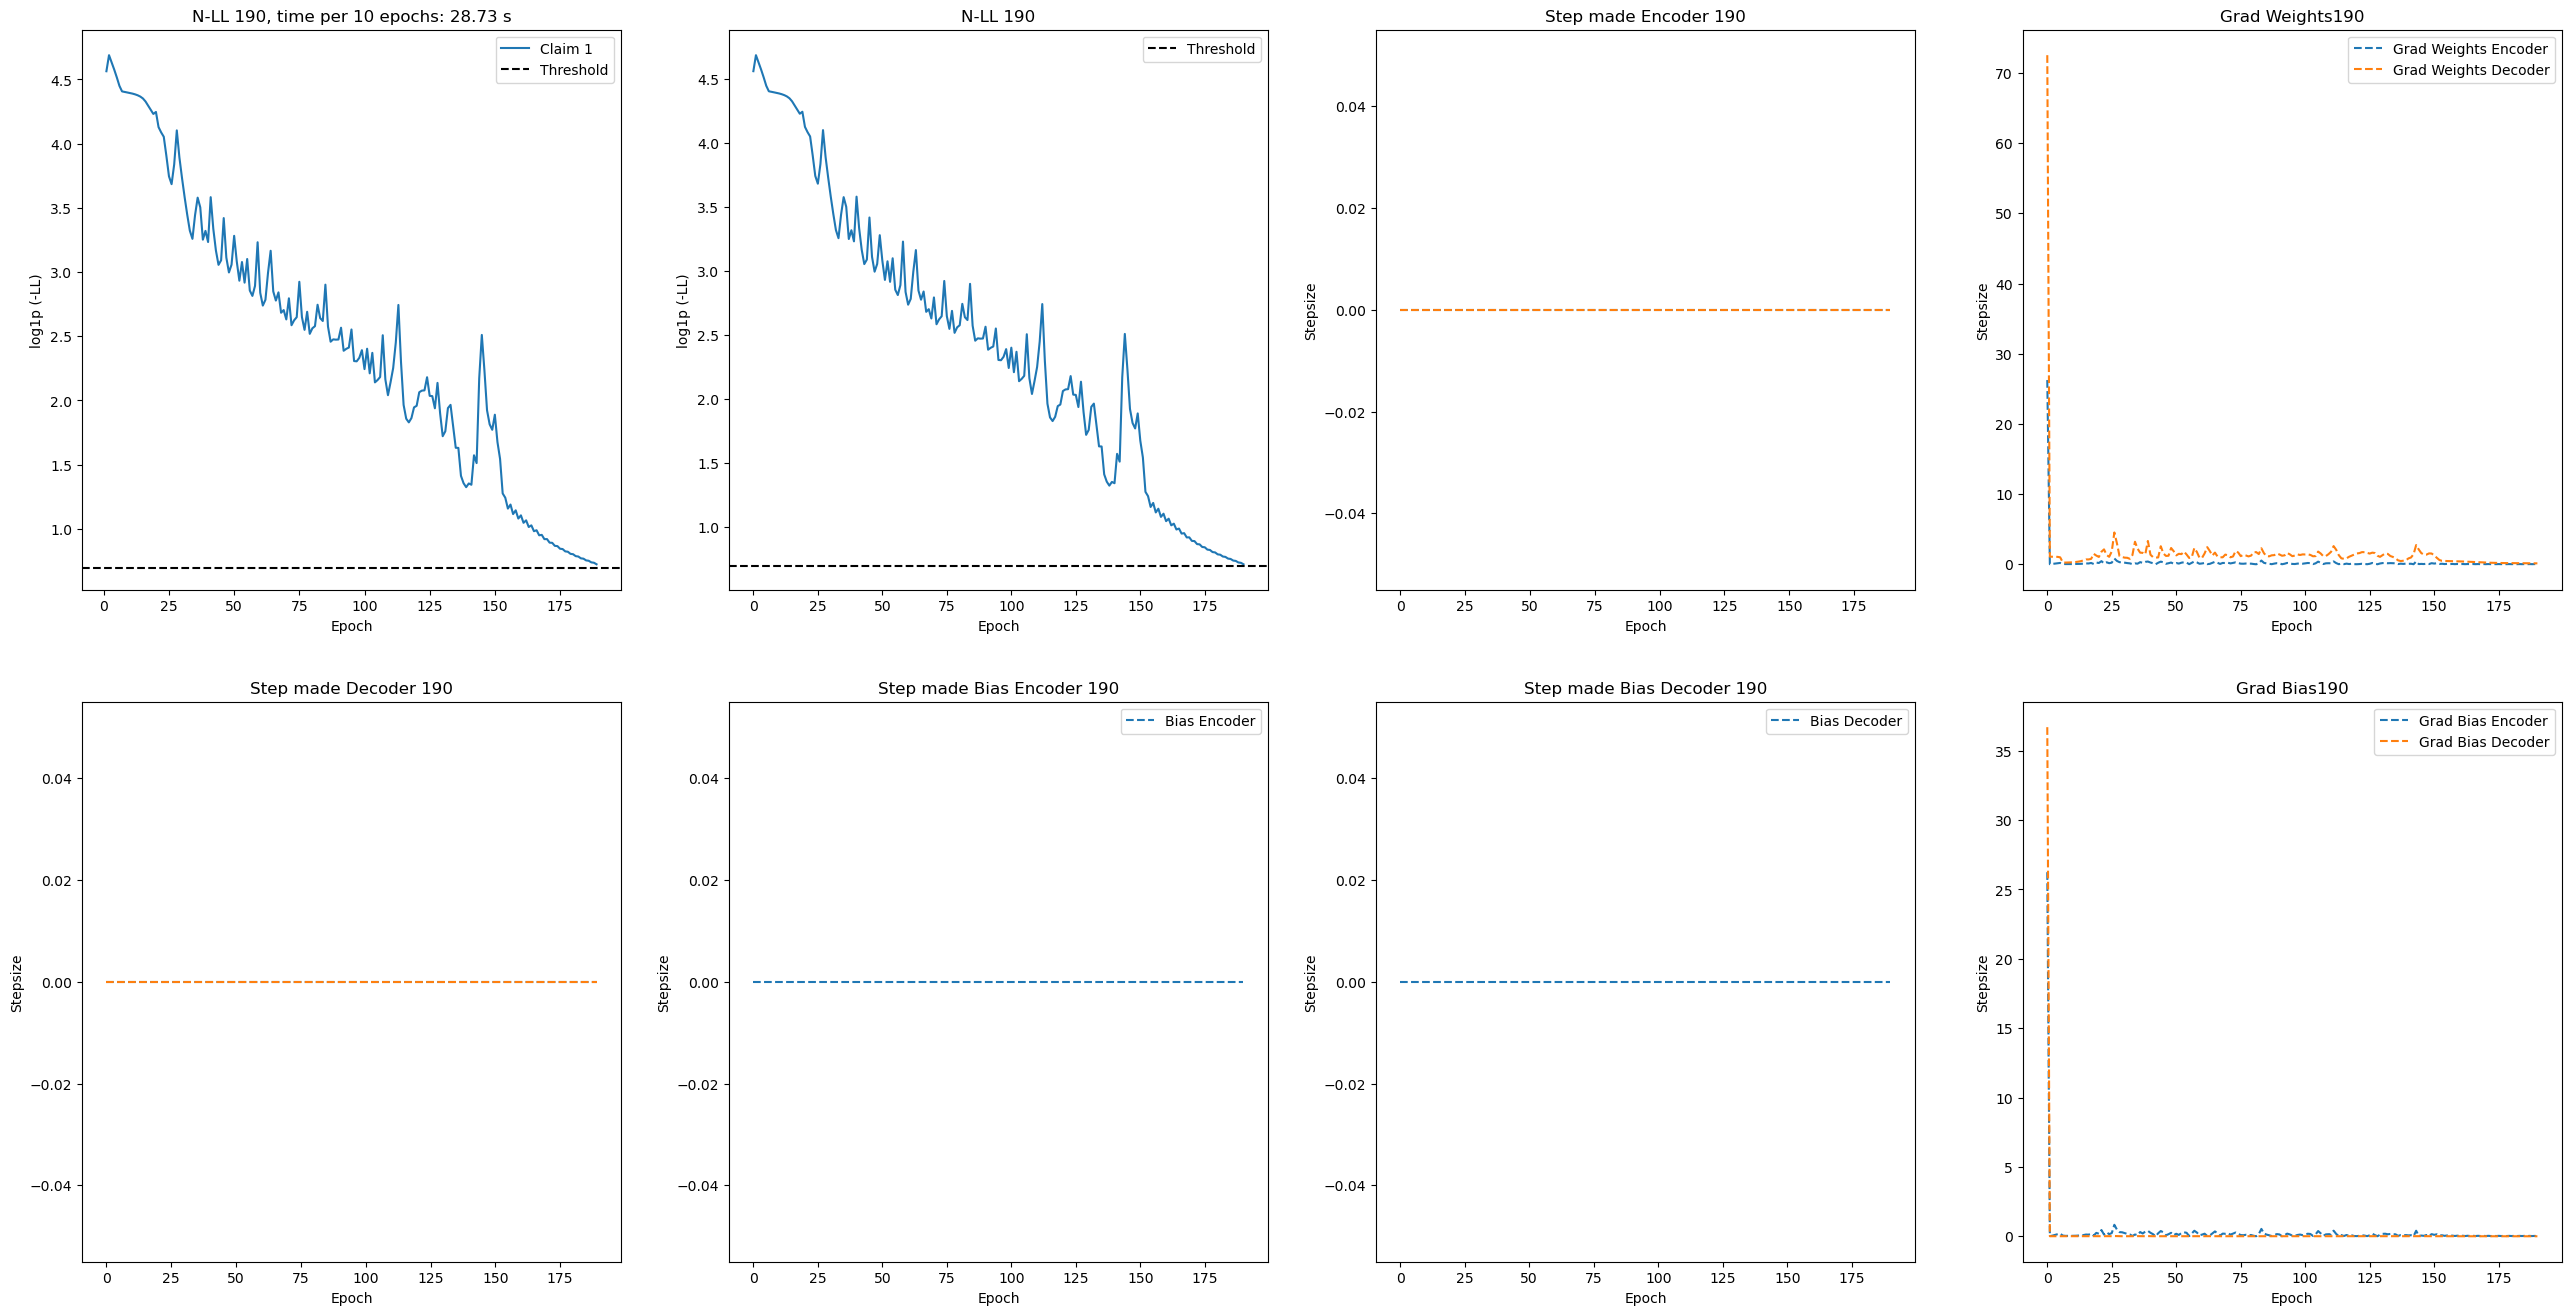

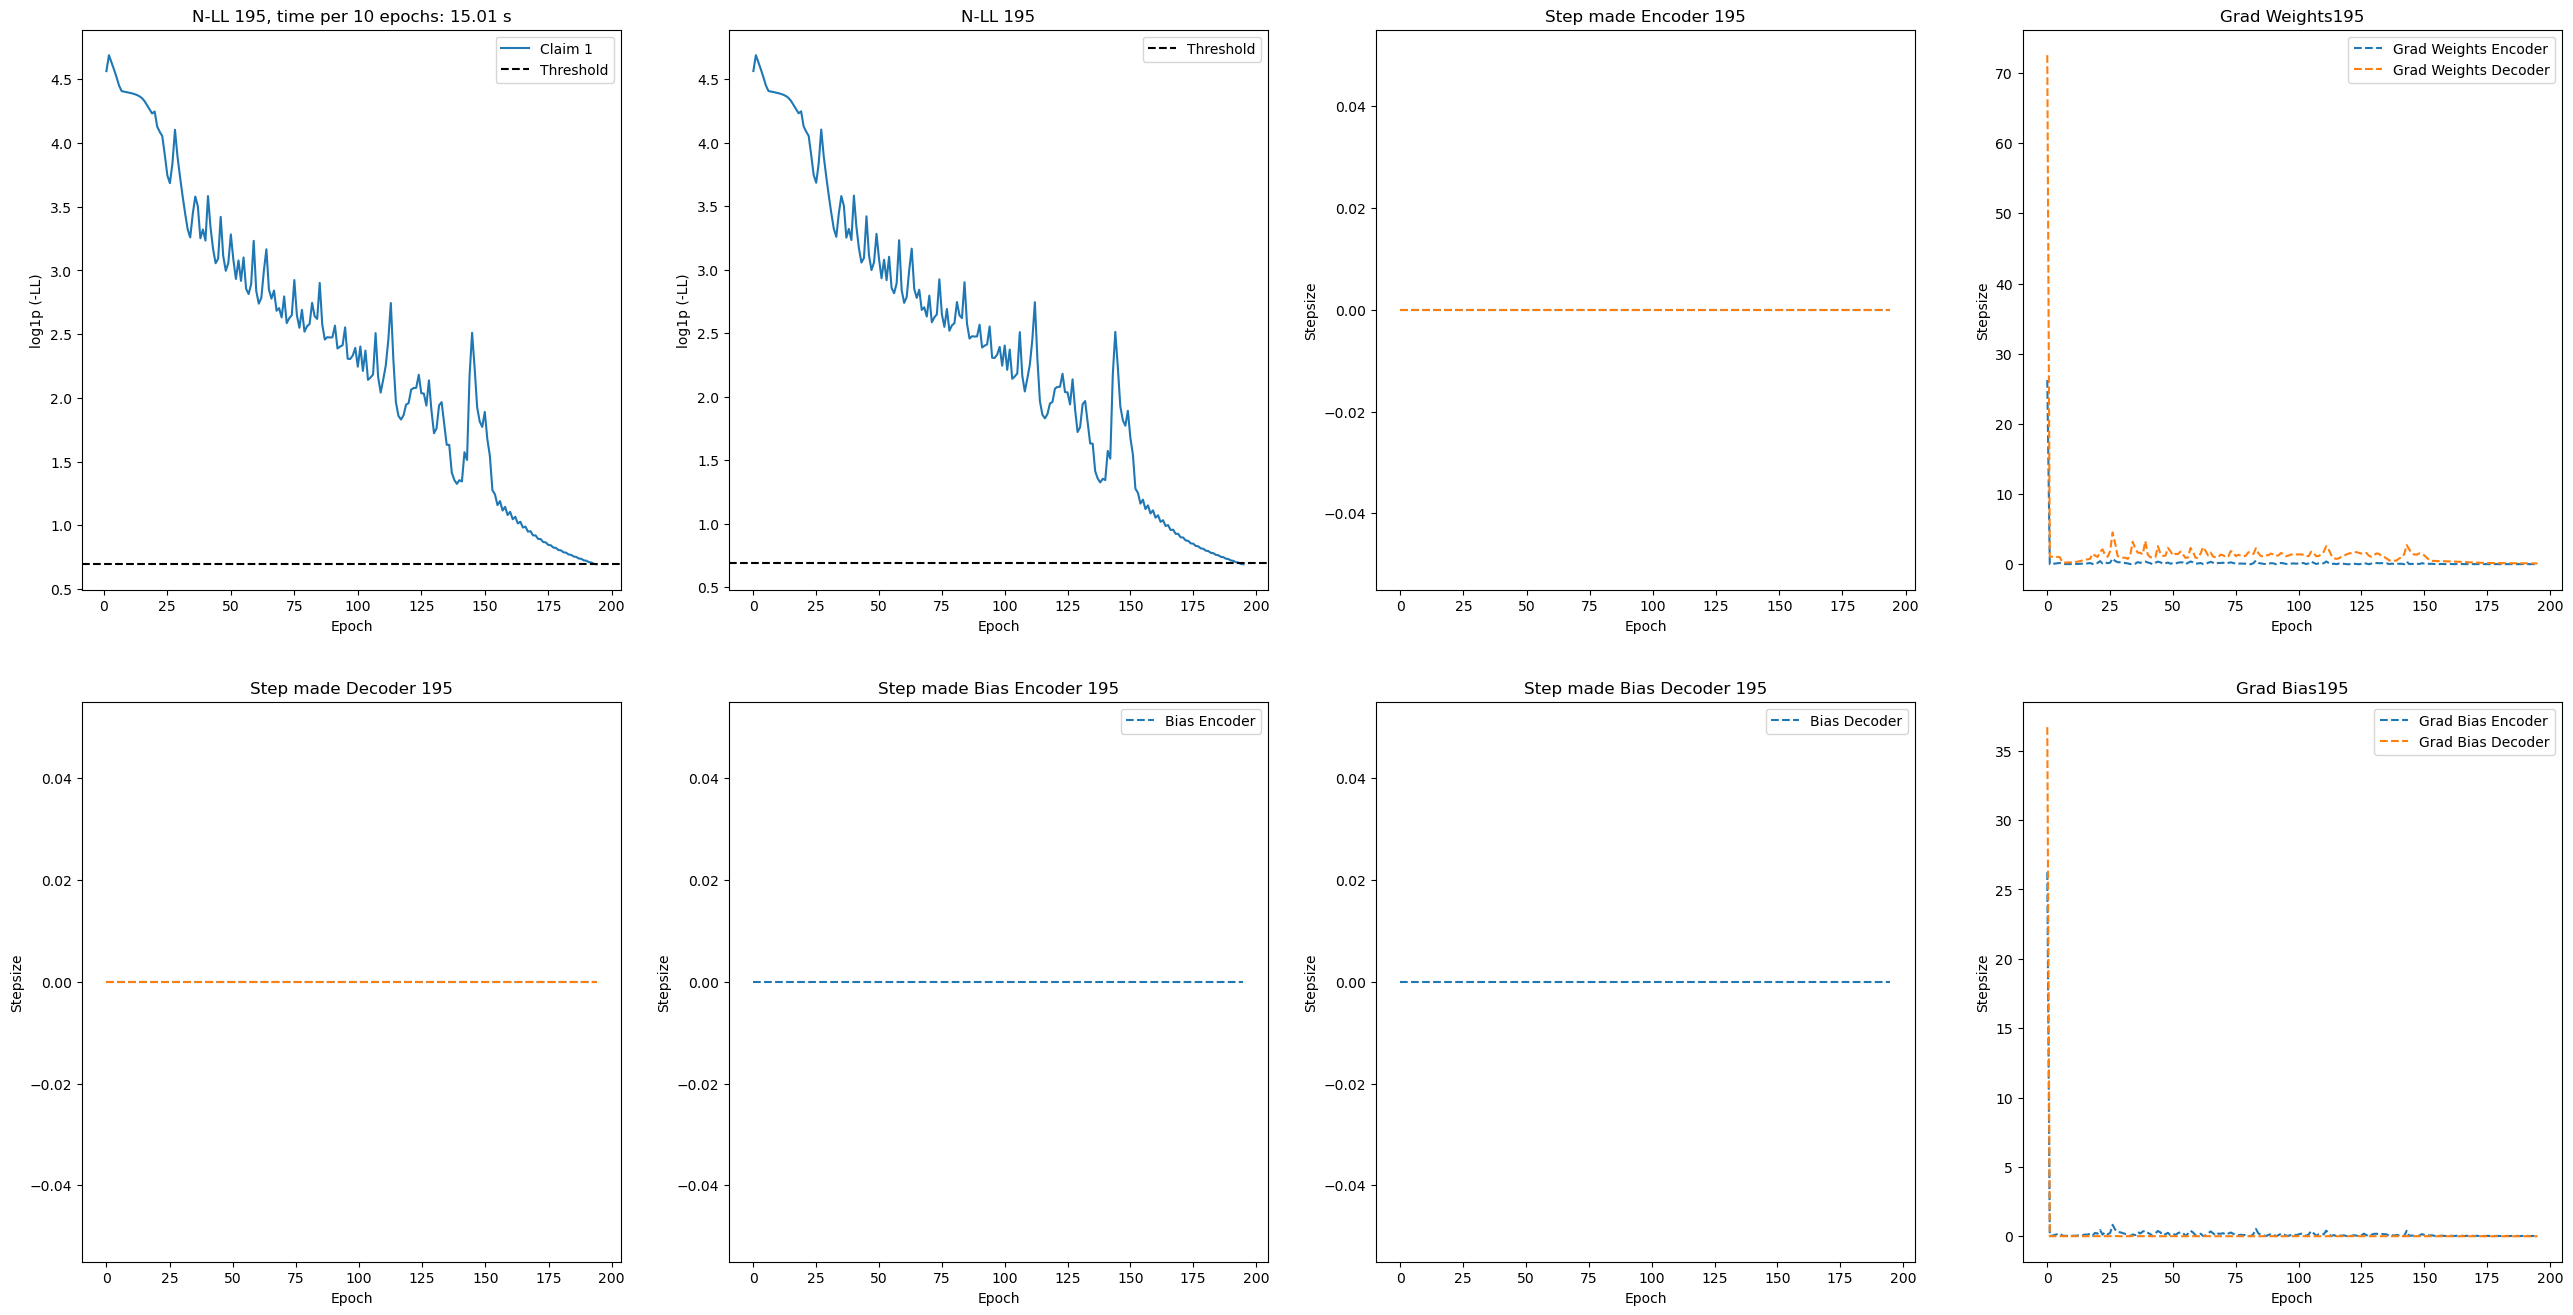

In [18]:
tic_total = time.time()
tic = time.time()

while not bStop:

    # Forward pass, Generate and compute loss
    tAEOutputs = ae(tOHETarget).reshape(tOHETarget.shape[0], 1, -1)

    # BUG: Generated less that iMaxTokens elements for all claims, then crashed
    outputs = fn_generate_max(tAEOutputs)
  
    loss, loss_monitor = LLikelihood(outputs.scores, tTargetStrings, iMaxTokens, iClaims, iVocab)
    lLoss.append(loss.item())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()

    # Check stopping criterion; logging
    aLLHistory = np.vstack([aLLHistory, loss_monitor.cpu().detach().numpy()])
    bStop = loss < dEps
    bStop = np.all(aLLHistory[iEpoch, :] < dEps)
    
    tDecoderWOld = ae.decoder[0].weight.cpu().detach().numpy()
    tDecoderBOld = ae.decoder[0].bias.cpu().detach().numpy()
    tEncoderWOld = ae.encoder[0].weight.cpu().detach().numpy()
    tEncoderBOld = ae.encoder[0].bias.cpu().detach().numpy()
    
    lGradWeightsDecoder.append(torch.norm(ae.decoder[0].weight.grad).cpu().detach().numpy())
    lGradBiasDecoder.append(torch.norm(ae.decoder[0].bias.grad).cpu().detach().numpy())
    lGradWeightsEncoder.append(torch.norm(ae.encoder[0].weight.grad).cpu().detach().numpy())
    lGradBiasEncoder.append(torch.norm(ae.encoder[0].bias.grad).cpu().detach().numpy())
    
    optimizer.step()
    # optimizer.step(closure)
    
    lStepsWeightsDecoder.append(np.abs(ae.decoder[0].weight.cpu().detach().numpy() - tDecoderWOld))
    lStepsBiasDecoder.append(np.abs(ae.decoder[0].bias.cpu().detach().numpy() - tDecoderBOld))
    lStepsWeightsEncoder.append(np.abs(ae.encoder[0].weight.cpu().detach().numpy() - tEncoderWOld))
    lStepsBiasEncoder.append(np.abs(ae.encoder[0].bias.cpu().detach().numpy() - tEncoderBOld))

    # Monitoring
    if (iEpoch % 10 == 0) or bStop:
        toc = time.time()
        dTime = np.round(toc - tic, 2)
        tic = time.time()
        plot_results(dTime, sNameAEModel, iEncodingDim, ae, lLoss, aLLHistory, lStepsWeightsEncoder, lStepsBiasEncoder, lStepsWeightsDecoder, lStepsBiasDecoder, lGradWeightsEncoder, lGradBiasEncoder, lGradWeightsDecoder, lGradBiasDecoder, iEpoch, dEps, tOHETarget, fn_generate_max, tokenizer)
        print(f"time: {dTime} s")
        
    if (iEpoch % 50 == 0) or bStop:
        torch.save(ae.state_dict(), sNameAEModel + "_checkpoint_" + "_dict.pt")
        model_scripted = torch.jit.script(ae) # Export to TorchScript
        model_scripted.save(sNameAEModel + "_checkpoint" + ".pt") # Save

    iEpoch = 1 + iEpoch

toc = time.time()
print(f"Total time: {np.round(toc - tic_total, 2)} s")

print(f"Verify the final generation...\n\n")
tGenNew = fn_generate_max(ae(tOHETarget).reshape(tOHETarget.shape[0], 1, -1)).sequences
for i in range(tOHETarget.shape[0]):
    print(f"Claim {i}: {tokenizer.decode(tGenNew[i])}")